# Citation Intent Classification - SciBERT_UNCASED

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## A survey of methodologies for Citation Intent Classification
#### Brief description of the task
The aim of this project is to walk through the building of a Machine Learning model capable of classifying citation intents in scientific papers.

I will make use of a Pre-trained language model (PLM) to build a meaningful comparison between some of the different techniques that could be used to produce the final outcome, in order to investigate which works better for the task.

The techniques I aim to compare are:
- The fine-tuning of a PLM;
- The construction of an ensemble multi-class classifier based on binary classifiers.

#### Requirements

Download additional libraries and modules.

In [2]:
!pip install transformers datasets scikit-learn accelerate ray[tune]==2.9.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 1.4 MB/s eta 0:00:00


Below you will find all the necessary imports for the project, together with the version of the main libraries.

In [3]:
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
import missingno as msno
import seaborn as sns
import sklearn
import tensorflow as tf
import datasets
from datasets import load_dataset
import random
from torch.utils.data import DataLoader
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer

print(f"Python Version: {sys.version}\n\nMain libraries of the project:\n")
print(f"- NumPy Version: {np.__version__}")
print(f"- Pandas Version: {pd.__version__}")
print(f"- Matplotlib Version: {mpl.__version__}")
print(f"- Seaborn Version: {sns.__version__}")
print(f"- Scikit-learn Version: {sklearn.__version__}")
print(f"- TensorFlow Version: {tf.__version__}")
print(f"- PyTorch Version: {torch.__version__}")
print(f"- Datasets Version: {datasets.__version__}")
print(f"- Transformers Version: {transformers.__version__}")

Python Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]

Main libraries of the project:

- NumPy Version: 1.23.5
- Pandas Version: 1.5.3
- Matplotlib Version: 3.7.1
- Seaborn Version: 0.13.1
- Scikit-learn Version: 1.2.2
- TensorFlow Version: 2.15.0
- PyTorch Version: 2.1.0+cu121
- Datasets Version: 2.16.1
- Transformers Version: 4.35.2


Retrieve GPU device for PyTorch based operations

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 1. Dataset loading and inspection

I download the SciCite dataset directly from the datasets library provided by Huggingface. The dataset will be stored inside a dict-like object yet splitted, consistently with the benchmark dataset, into train, validation and test sets.

In [5]:
dataset = load_dataset("allenai/scicite", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/8194 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/916 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1859 [00:00<?, ? examples/s]

Here I print some information about the dataset we are using. Mainly, we get a brief description of it, as well as the link to access the original dataset.

In [ ]:
print(dataset['train'].description, '\n\n')
print(dataset['train'].homepage)


This is a dataset for classifying citation intents in academic papers.
The main citation intent label for each Json object is specified with the label
key while the citation context is specified in with a context key. Example:
{
 'string': 'In chacma baboons, male-infant relationships can be linked to both
    formation of friendships and paternity success [30,31].'
 'sectionName': 'Introduction',
 'label': 'background',
 'citingPaperId': '7a6b2d4b405439',
 'citedPaperId': '9d1abadc55b5e0',
 ...
 }
You may obtain the full information about the paper using the provided paper ids
with the Semantic Scholar API (https://api.semanticscholar.org/).
The labels are:
Method, Background, Result
 


https://github.com/allenai/scicite


Let's start inspecting our dataset.

At first, we print the shape of each one of the three splits.

In [ ]:
print(dataset.shape)

{'train': (8194, 14), 'validation': (916, 14), 'test': (1859, 14)}


Now, let's look at the specific columns of each one the splits.

For simplicty, I will work around the train split for inspection purposes, but first asserting that all the splits have the same columns.

In [ ]:
assert(dataset['train'].column_names==dataset['validation'].column_names==dataset['test'].column_names)
print(dataset['train'].column_names)

['string', 'sectionName', 'label', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id']


Let's now inspect the types of data contained in these columns.

In [ ]:
dataset['train'].features

{'string': Value(dtype='string', id=None),
 'sectionName': Value(dtype='string', id=None),
 'label': ClassLabel(names=['method', 'background', 'result'], id=None),
 'citingPaperId': Value(dtype='string', id=None),
 'citedPaperId': Value(dtype='string', id=None),
 'excerpt_index': Value(dtype='int32', id=None),
 'isKeyCitation': Value(dtype='bool', id=None),
 'label2': ClassLabel(names=['supportive', 'not_supportive', 'cant_determine', 'none'], id=None),
 'citeEnd': Value(dtype='int64', id=None),
 'citeStart': Value(dtype='int64', id=None),
 'source': ClassLabel(names=['properNoun', 'andPhrase', 'acronym', 'etAlPhrase', 'explicit', 'acronymParen', 'nan'], id=None),
 'label_confidence': Value(dtype='float32', id=None),
 'label2_confidence': Value(dtype='float32', id=None),
 'id': Value(dtype='string', id=None)}

The dataset has been thought to represent a real distribution of citation intents in the average research paper. Thus, it presents an higly imbalanced distribution of labels. </br>To better see this, let's visualize the distribution for each of the splits.

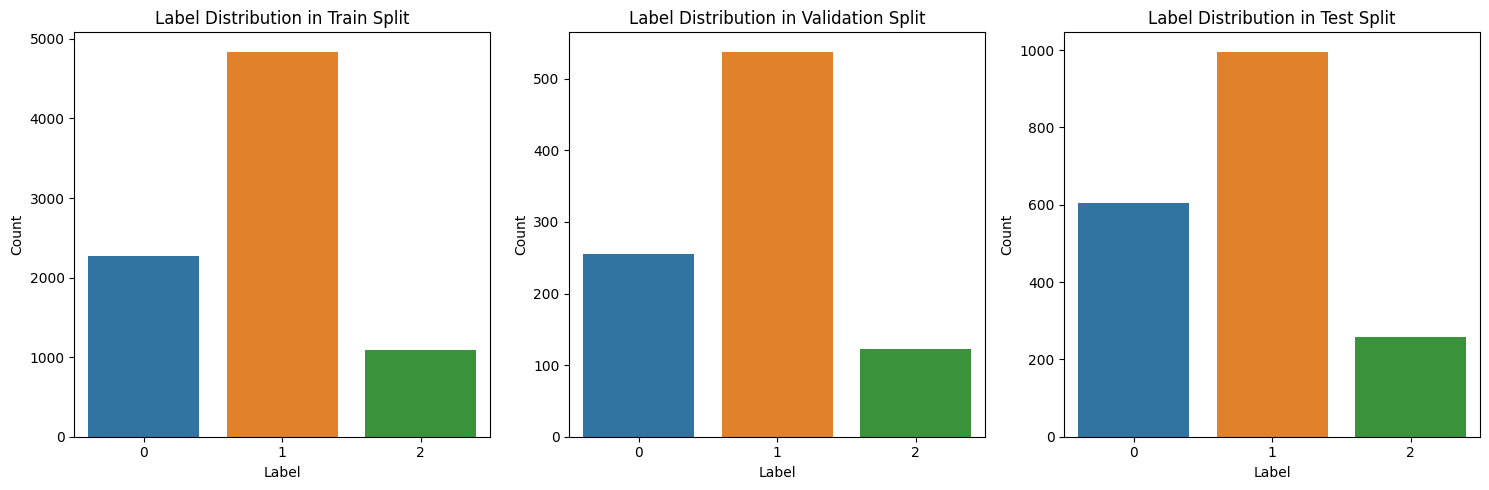

In [ ]:
splits = ['train', 'validation', 'test']

fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i, split in enumerate(splits):
    labels = [example['label'] for example in dataset[split]]
    # Here I count the occurrence of each label thanks to counter, imported from collections
    label_counts = Counter(labels)

    df = pd.DataFrame({'label': list(label_counts.keys()), 'count': list(label_counts.values())})
    sns.barplot(x='label', y='count', data=df, ax=axs[i])

    axs[i].set_title(f'Label Distribution in {split.capitalize()} Split')
    axs[i].set_xlabel('Label')
    axs[i].set_ylabel('Count')

# Below is to adjust padding
plt.tight_layout()
plt.show()

As stated above, the distribution of labels is consistent within the splits.

Now, let's inspect the missing values from the dataset.

According to how the dataset has been created, <b>NaN</b> values are not present in the huggingface version. Thus, in order to have a grasp of which columns present missing values, and how many of them we have to deal with, we should made a simple conversion from "", or " ", to np.nan.</br>Then, we plot a mtrix like representation of missing values for each of the splits.

Missing values in Train: 587
Missing values in Train Split:
Missing values in Validation: 71
Missing values in Validation Split:
Missing values in Test: 66
Missing values in Test Split:


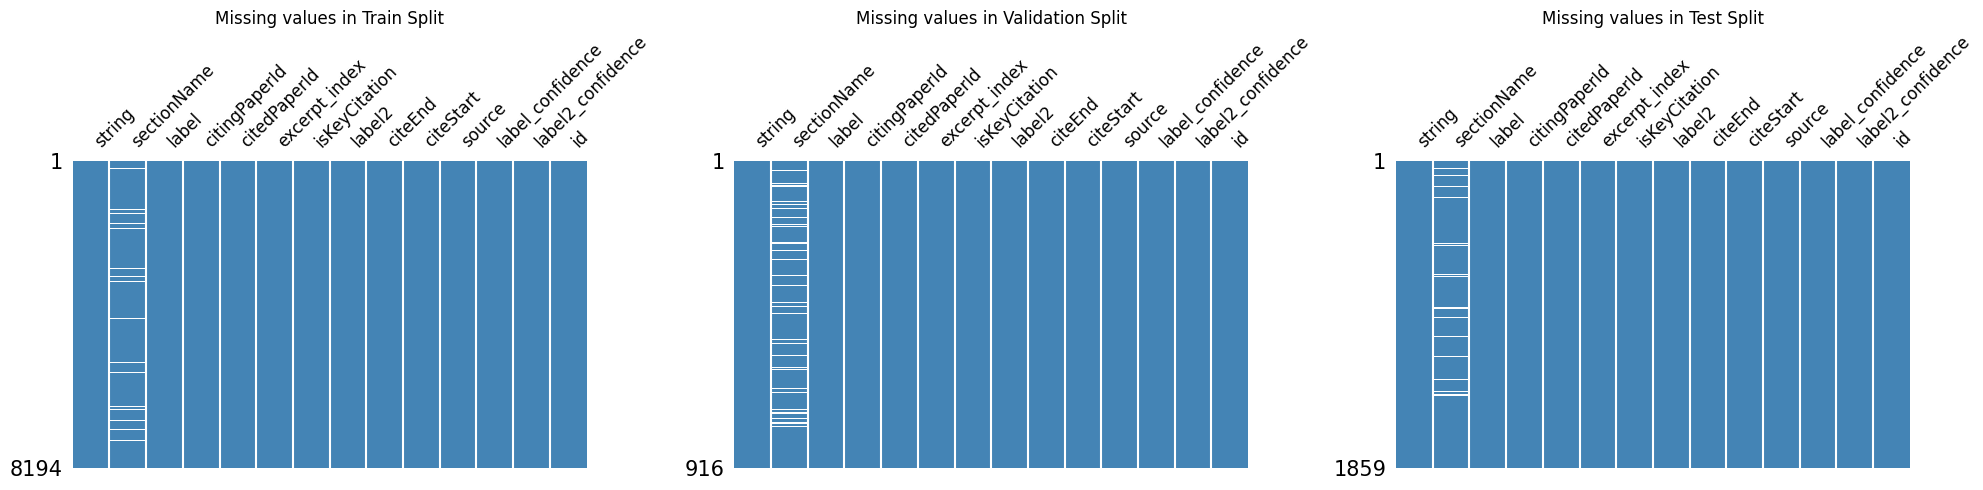

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for i, split in enumerate(splits):
    df = pd.DataFrame(dataset[split])
    # Conversion of empty cells into np.nan
    df.replace({"": np.nan, " ": np.nan}, inplace=True)
    # Find missing values
    missing_values = df.isna().sum().sum()
    print(f"Missing values in {split.capitalize()}: {missing_values}")
    # Visualizing the missing values with missingno library
    print(f"Missing values in {split.capitalize()} Split:")
    msno.matrix(df, ax=axs[i], sparkline=False, fontsize=12, color=(0.27, 0.52, 0.71))
    axs[i].set_title(f'Missing values in {split.capitalize()} Split')

plt.tight_layout()
plt.show()

From this dataset, we are mainly interested in seeing how to deal with string, sectionName, and label columns. All the other information can be discarded because are not useful for the task.

## 2. Brief discussion: PLMs and SOTA

The Citation Intent Classification task has been studied intensively, and the current state of the art is a Macro-F1 score of 88.93 obtained with an XLNet based model ([SOTA page](https://paperswithcode.com/sota/citation-intent-classification-on-scicite)). Other methodologies, like embedding based analyses, together with LSTM based approaches, show a much lower performance.

As you can imagine, the task can be tackled from very different perspectives, we could use prompt-tuning, fine-tuning, zero-shot, few-shot, sentence-transformer based similarity, and so on... But, for the aim of this project, I'd like to go deeper on the scores we can obtain by using an ensemble based approach, and see whether or not it will outperform the scores obtained with task specific fine-tuning. Additionally, I'd like to investigate the impact that a mix of feature and prompt engineering, correctly applied to these PLMs could have.

In order to move our first steps into the task, we must first decide which model we would like to use. To make such decision, I have a list of candidate PLMs.

The models I will take into consideration are the following:
- <b>SciBERT</b>: A BERT based model trained on a corpus of scientific texts. Its main advantages is its good understanding of the scientific domain and the SciVocab, a newly designed vocabulary containing a great number of terms from the scientific literature - [Reference Paper](https://arxiv.org/abs/1903.10676);
- <b>XLNet</b>: A model presenting an evolution of the way in which LMs are trained for Language Understanding tasks. As said before, it is also the current base-model of SOTA results for this task - [Reference Paper](https://arxiv.org/abs/1906.08237);
- <b>Galactica</b>: A big open source science based language model from META. It is a controversial model for the results it has obtained in text generation tasks, but it is now back on track - [Reference Paper](https://arxiv.org/abs/2211.09085).

Each of these models could be particularly suited for the task.

## 3. SciBERT_uncased Fine-Tuning
In this section, I will tackle the problem with the raw fine-tuning of the SciBERT model on the SciCite dataset.

Fine tuning is an approach that involves changing the weights of the PLM to adapt it to a new task. Additionally, the process involves the use of a classification head in this specific case. Such head is useful to classify, by means of the logits of the model, its answers into either one of the three possible classes.

For this part, I will solely rely on Huggingface for fine tuning and Ray Tune for hyperparameter optimization.

Below, you can see and inspect SciBERT configuration.

In [6]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

ckp = "allenai/scibert_scivocab_uncased"
model = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=3)
model.to(device)

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
layer_count=0
for layer in model.bert.encoder.layer:
    layer_count+=1
    print(layer)

print(layer_count)

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)
BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (qu

#### 3.a) Tokenization and Model download

The tokenization part is mostly carried out by the AutoTokenizer object of  Huggingface. What we need to do is simply load the tokenizer we want to use, and then define a mapping function to the dataset.

For what concerns the model download, the same is true. We can easily rely on huggingface to download the model we want to use, and add a mapping from labels to numerical values of them.

#### 3.b) Ray Tune for HP optimization

To optimize the search in the HP space, we will make use of ray tune library. This library gives us the possibility to define in high details the way in which we want to perform such search.

<b><u>"Unfortunately", seen the dimension of these PLMs, I will need to define each of the steps I am describing inside a single function, otherwise Ray Tune wouldn't be able to correctly handle GPU RAM.</b></u>

For what concerns the task specific Fine-Tuning, I would like to make use of some prompt and feature engineering on the sentences that the model will need to classify. Additionally, I will implement a Population Based Search for HP optimization.

The main HP I will deal with are the following:
- Learning Rate;
- Weighted loss or non-weighted loss (since the dataset is higly imbalanced, a weighted loss could, or not, help);
- Weight decay for the optimizer;
- Batch size.

Additionally, these models are highly sensible to weights initialization and data order, which may result in drastically different performances, as stated in [Fine-Tuning Pretrained Language Models:
Weight Initializations, Data Orders, and Early Stopping](https://arxiv.org/pdf/2002.06305v1.pdf). Thus, searching also through the seeds could be a good idea but, for memory and efficiency requirements, I will manually set a pre-defined seed.

#### 3.c) Training loop

Inside the main function, that you will see below, I have implemented a particular training loop.

This is not the standard training suggested for PLMs fine tuning (which is way less flexible...), I have implemented an early stopping condition to deal with the fact that such PLMs heavily tends to overfit. Moreover, since the problem of overfitting is real, I will save the model with the best generalization performance in terms of validation loss at each step, to finally retrieve the best performing overall.

Additionally, seen that PLMs need really low learning rate values in their fine tuning, they risk many times to get stuck. Thus, instead of opting for a linear decrease of the learning rate through epochs, I found way better results with a static reduction of the learning rate when the model gets stuck in a plateau.

Since the number of epochs needed for PLMs is relatively low (around 5 epochs at most, or they will for sure overfit...), I have decided to add a fine-grained evaluation of generalization performances. This means that the model will look into validation data more than once during each epoch, and these data are used to implement LR reduction and Early Stopping.

Finally, to speed up the fine tuning process, I have used mixed precision training thanks to Autocast and GradScaler. The former is useful to perform forward and backward passes at half precision (float16 instead of float32), thus reducing memory requirements and speeding up the process, while the latter serves to purpose of mitigating numerical instability issues due to the half precision. With this strategy, we are in the end able to obtain more or less the same results but with a significantly lower use of resources and with a training that requires less than a half of the time that a normal loop would need.

#### 3.d) Implementation

Below I implement and describe through comments all the steps I have discussed above.

In [ ]:
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
from ray import tune, train
from sklearn.metrics import f1_score, accuracy_score
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import tempfile
from ray.train import Checkpoint


def train_model(config):
    dataset = load_dataset("allenai/scicite", trust_remote_code=True)

    # Use config from ray Tune
    ckp = config["model_ckp"]
    loss_balance = config["loss_balance"]
    seed = config["seed"]
    lr = config["lr"]
    weight_decay = config["weight_decay"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    ray_checkpoint_interval = config['ray_checkpoint_interval']
    tokens_max_length = config["tokens_max_length"]

    # Here I define the mapping from numerical to string labels, and viceversa
    # This is useful for Huggingface automodel
    id2label = {0: "method", 1: "background", 2: "result"}
    label2id = {"method": 0, "background": 1, "result": 2}

    # Download the model from the checkpoint of SciBERT, and move it on GPU
    model = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=3, id2label=id2label, label2id=label2id)

    num_layers_to_freeze = 3
    for layer in model.bert.encoder.layer[:num_layers_to_freeze]:
        for param in layer.parameters():
            param.requires_grad = False

    model = model.to(device)

    loss = torch.nn.CrossEntropyLoss()

    # Load SciBERT tokenizer
    tokenizer = AutoTokenizer.from_pretrained(ckp)

    # The function below defines the tokenization process
    def tokenize_function(examples):
        augmented = ['[SECTION] ' + section + '. [CITATION] ' + string + ". Has function:" for section, string in zip(examples['sectionName'], examples['string'])]
        tokenized = tokenizer(augmented, max_length=tokens_max_length, padding='max_length', truncation=True)
        tokenized['augmented'] = augmented
        return tokenized

    tokenized_datasets = dataset.map(tokenize_function, batched=True)
    tokenized_datasets = tokenized_datasets.remove_columns(['augmented', 'string', 'sectionName', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id'])
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
    tokenized_datasets.set_format("torch")

    # Set seed
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Define train and validation sets according to the standard splits
    train_dataset = tokenized_datasets["train"]
    val_dataset = tokenized_datasets["validation"]

    # Define the dataloaders
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=128)

    # It is good norm to not applying weight decay to the following two layers if present
    # I will check if they are in the model and in case set their weight decay to 0
    no_decay = ['bias', 'LayerNorm.weight']

    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

    # Define the optimizer and the scheduler
    optimizer = AdamW(optimizer_grouped_parameters, lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=6, factor=0.75, min_lr=8e-7, cooldown=2, verbose=True)

    batch_counter = 0
    # Accumulation steps are only useful if the GPU is not sufficiently big,
    # in this case I leave it to 1, so it is like if it is not here
    accumulation_steps = 1
    validation_interval = ray_checkpoint_interval
    step_counter = 0
    evaluation_counter = 0

    # Set extreme values to have checkpointing
    best_val_loss = float('inf')
    best_val_f1 = float('-inf')

    scaler = GradScaler()

    no_improvement = 0
    early_stopping_patience = 8 # Number of evaluations without performance improvement before stopping

    start_epoch = 0
    last_batch_index = 0

    # If `train.get_checkpoint()` is populated, then we are resuming from a checkpoint.
    checkpoint = train.get_checkpoint()
    if checkpoint:
        print("GETTING BACK CHECKPOINT AFTER PAUSED TRAINING")
        with checkpoint.as_directory() as checkpoint_dir:
            checkpoint_dict = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))

        model.load_state_dict(checkpoint_dict["model_state_dict"])
        optimizer.load_state_dict(checkpoint_dict["optimizer_state_dict"])
        step_counter = checkpoint_dict["step"]
        best_val_loss = checkpoint_dict["best_val_loss"]
        evaluation_counter = checkpoint_dict["performed_evaluation"]
        scheduler.load_state_dict(checkpoint_dict["scheduler_state_dict"])

        # Give a cooldown step
        no_improvement = checkpoint_dict["no_improvement_steps"]
        if no_improvement >= 1:
            no_improvement-=1

        start_epoch = checkpoint_dict["last_epoch_index"]
        last_batch_index = checkpoint_dict["last_batch_index"]
        print(f"Resuming training from Epoch {start_epoch}, Batch Index: {last_batch_index}")
        metrics = checkpoint_dict["metrics"]

    # Training loop
    for epoch in range(start_epoch, num_epochs):
        train_loss = 0.0
        num_train_batches = 0
        train_predictions_list = []
        train_labels_list = []

        optimizer.zero_grad()

        for batch_index, batch in enumerate(train_dataloader):
            if epoch == start_epoch and batch_index < last_batch_index:
                continue  # Skip batches up to checkpoint

            batch = {k: v.to(device) for k, v in batch.items()}
            # Mixed precision below
            with autocast():
                outputs = model(**batch)
                loss = outputs.loss

            scaler.scale(loss).backward()
            batch_counter += 1

            if batch_counter % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                batch_counter = 0

            train_loss += loss.item()
            num_train_batches += 1

            train_preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
            train_predictions_list.extend(train_preds)
            train_labels_list.extend(batch["labels"].cpu().numpy())

            # This below should ensure that the same amount of data has been seen by the model
            # even if it has the smallest batch size (16) between the searched ones.
            # This is useful to have a meaningful comparison of val_loss at the evaluation time,
            # because both bs=32 and bs=16 models should have seen the same amount of data.
            if batch_size==16:
                step_counter += 0.5
            else:
                step_counter += 1

            # Evaluation on Validation data + Ray Checkpoint creation
            if step_counter % validation_interval == 0:
                model.eval()
                val_loss = 0.0
                num_val_batches = 0
                val_predictions_list = []
                val_labels_list = []

                with torch.no_grad():
                    for batch in val_dataloader:
                        batch = {k: v.to(device) for k, v in batch.items()}

                        with autocast():
                            outputs = model(**batch)
                            loss = outputs.loss

                        val_loss += loss.item()
                        num_val_batches += 1

                        val_preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
                        val_predictions_list.extend(val_preds)
                        val_labels_list.extend(batch["labels"].cpu().numpy())

                val_loss /= num_val_batches
                val_f1 = f1_score(val_labels_list, val_predictions_list, average="macro")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    no_improvement = 0
                else:
                    no_improvement += 1

                evaluation_counter += 1

                if no_improvement >= early_stopping_patience:
                    print("No improvement in validation loss for {} evaluations, stopping.".format(early_stopping_patience))
                    train.report(metrics)
                    break

                scheduler.step(val_loss)
                intermediate_train_loss = train_loss/num_train_batches

                metrics = {"training_iteration":step_counter, "performed_evaluation":evaluation_counter, "best_val_loss": best_val_loss, "train_loss":intermediate_train_loss, "current_val_loss":val_loss, "current_val_f1":val_f1}

                # Checkpointing with Ray Tune/Train
                with tempfile.TemporaryDirectory() as tmpdir:
                    torch.save(
                        {
                            "performed_evaluation": evaluation_counter,
                            "step": step_counter,
                            "model_state_dict": model.state_dict(),
                            "optimizer_state_dict": optimizer.state_dict(),
                            "best_val_loss": best_val_loss,
                            "no_improvement_steps": no_improvement,
                            "scheduler_state_dict": scheduler.state_dict(),
                            "last_batch_index": batch_index,
                            "last_epoch_index": epoch,
                            "metrics": metrics
                        },
                        os.path.join(tmpdir, "checkpoint.pt"),
                    )
                    train.report(metrics, checkpoint=Checkpoint.from_directory(tmpdir)) # tmpdir
                    print(f"Checkpoint stored at Epoch:{epoch}, Batch:{batch_index} - batch size:{batch_size}")

        if no_improvement >= early_stopping_patience:
            break

        train.report(metrics)
        print(f"EPOCH {epoch} finished")


Below I define the configuration, as well as the population based training. Finally, I start the training process, of which you will be able to see the results under the cell.

In [ ]:
seeds = [1482]
"""
For simplicity, here I will consider a single seed, without performing any kind of search.
Normally, the seed do not need to be searched, but, according to https://arxiv.org/pdf/2002.06305v1.pdf
in a LLM, a different weight initialization, and data order, can higly impact the performances of the
fine tuned model.
"""
# After evaluation_interval batches (depending on batch_size, if 32 is 30, if 16 is 60) -> I consider step_counter as time_attr
evaluation_interval = 30

# Define configuration space
config = {
    "num_epochs": 5,
    "batch_size": tune.grid_search([16, 32]),
    "seed": tune.grid_search(seeds),
    "lr": tune.uniform(1e-5, 2e-5), # These are the recommended learning rates for similar tasks
    "weight_decay": tune.uniform(0.02, 0.01), # Weight decay may highly influence the final results
    "model_ckp": ckp,
    "loss_balance": False, #tune.grid_search([True, False]),
    "tokens_max_length": tune.grid_search([256, 312]),
    "ray_checkpoint_interval": evaluation_interval
}

For the population based training, I have defined a perturbation interval every 30 steps. This means that, after 30 evaluations on validation data for each possible model, the worst (also called explorers) will be randomly mutated according to the parameters defined below. Thus, their learning rate, or weight decay, could be changed in the range defined. Additionally, these modified explorers will be re-trained from zero up to 2x number of perturbation interval (so for 60 evaluations), and the process is repeated.

The best performing models, called exploiters, are then modified according to the best performing explorers in a random way. Finally, the worst performing HP are discarded and the ones that gave best results replace them in following iterations.

This process of "evolution" goes on until all the models have completed their training.

Usually, with Population Based Training (PBT), models converge faster and a broader HP search space is explored. Unfortunately, since I am running this on single GPU on Colab platform, the process is pretty slow because training cannot be parallelized.

In [ ]:
from ray.tune.schedulers import PopulationBasedTraining
import ray

scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    perturbation_interval=evaluation_interval*8,
    metric="best_val_loss",
    mode="min",
    #burn_in_period=120.0, # Number of training steps before starting with Exploitation/Exploration process
    quantile_fraction=0.5,
    resample_probability=0.3,
    perturbation_factors=(1.15,0.85),
    hyperparam_mutations={
        "lr": tune.uniform(9e-6, 3e-5),
        "weight_decay": tune.uniform(0.001, 0.03),
    },
    synch=True
)

In [ ]:
import time

start_time = time.time()

if ray.is_initialized():
    ray.shutdown()
ray.init()

# This tune.with_resources is basically the same of resources_per_trial
# So this is allocating 3 CPUs and 1/4 GPU for trial, making it possible to
# train more model in parallel (Slows a bit the performances but it's ok)
train_model_with_resources = tune.with_resources(train_model, {"cpu": 3, "gpu":0.25})

tuner = tune.Tuner(
    train_model_with_resources, #train_model,
    run_config=train.RunConfig(
        name="SciBERT_PBT_Uncased",
        stop={"training_iteration": 800}, # a bit more than 3 epochs
        checkpoint_config=train.CheckpointConfig(
            checkpoint_score_attribute="best_val_loss",
            checkpoint_score_order="min",
            num_to_keep=6,
        ),
        storage_path="/content/tmp/ray_results", #"/content/drive/MyDrive/Models/SciBERT_Models/FT_SciBERT/Ray_PBT_Checkpoints", # "/tmp/ray_results",
    ),
    tune_config=tune.TuneConfig(
        scheduler=scheduler,
        num_samples=2,
    ),
    param_space=config,
)

results_grid = tuner.fit()
end_time = time.time()

2024-01-21 11:12:21,395	INFO worker.py:1724 -- Started a local Ray instance.
2024-01-21 11:12:22,876	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 1. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+----------------------------------------------------------+
| Configuration for experiment     SciBERT_PBT_Uncased     |
+----------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator   |
| Scheduler                        PopulationBasedTraining |
| Number of trials                 8                       |
+----------------------------------------------------------+

View detailed results here: /content/tmp/ray_results/SciBERT_PBT_Uncased
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/SciBERT_PBT_Uncased`

Trial status: 8 PENDING
Current time: 2024-01-21 11:12:23. Total running time: 0s
Logical resource usage: 0/12 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:A100)
+-----------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length 

(train_model pid=2302) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(train_model pid=2302) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(train_model pid=2300) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
vocab.txt: 100%|██████████| 228k/228k [00:00<00:00, 34.0MB/s]
Map:  98%|█████████▊| 8000/8194 [00:02<00:00, 3658.39 examples/s]
(train_model pid=2301) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight'] [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_


Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-21 11:12:53. Total running time: 30s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+-----------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length |
+-----------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0.0161011             16     1482                   256 |
| train_model_f34bc_00001   RUNNING    1.60415e-05        0.0121374             32     1482                   256 |
| train_model_f34bc_00002   RUNNING    1.52899e-05        0.019412              16     1482                   312 |
| train_model_f34bc_00003   RUNNING    1.83255e-05        0.0192756             32     1482                   312 |
| train_mod

(train_model pid=2301) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0121_2024-01-21_11-12-23/checkpoint_000000)
Map: 100%|██████████| 8194/8194 [00:02<00:00, 3494.75 examples/s] [repeated 3x across cluster]


Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-21 11:13:23. Total running time: 1min 0s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0.0161011             16     1482                   256                                      

(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000000)


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:29 - batch size:32
(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:59 - batch size:16


(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000000)


Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-21 11:13:53. Total running time: 1min 30s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0.0161011             16     1482                   256       30            60.5005         

(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000001) [repeated 3x across cluster]


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:59 - batch size:32 [repeated 3x across cluster]
(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:119 - batch size:16


(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000001)
(train_model pid=2302) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000001)


(train_model pid=2302) Checkpoint stored at Epoch:0, Batch:119 - batch size:16
Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-21 11:14:23. Total running time: 2min 0s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0.0161011     

(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000002) [repeated 2x across cluster]


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:89 - batch size:32 [repeated 2x across cluster]
(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:179 - batch size:16


(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000002)
(train_model pid=2302) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000002)


(train_model pid=2302) Checkpoint stored at Epoch:0, Batch:179 - batch size:16
Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-21 11:14:53. Total running time: 2min 30s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0.0161011    

(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000003) [repeated 2x across cluster]


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:119 - batch size:32 [repeated 2x across cluster]
(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:239 - batch size:16


(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000003)


Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-21 11:15:23. Total running time: 3min 0s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0.0161011             16     1482                   256      120            166.357          

(train_model pid=2302) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000003)


(train_model pid=2302) Checkpoint stored at Epoch:0, Batch:239 - batch size:16
(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:299 - batch size:16 [repeated 3x across cluster]


(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000004) [repeated 3x across cluster]


(train_model pid=2301) Checkpoint stored at Epoch:0, Batch:179 - batch size:32


(train_model pid=2301) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0121_2024-01-21_11-12-23/checkpoint_000005)


Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-21 11:15:56. Total running time: 3min 33s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0.0161011             16     1482                   256      150            186.042         

(train_model pid=2302) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000004)


(train_model pid=2302) Checkpoint stored at Epoch:0, Batch:299 - batch size:16
(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:359 - batch size:16


(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000005)
(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000005)


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:179 - batch size:32


(train_model pid=2302) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000005) [repeated 2x across cluster]


(train_model pid=2302) Checkpoint stored at Epoch:0, Batch:359 - batch size:16 [repeated 2x across cluster]
Trial status: 4 RUNNING | 4 PENDING
Current time: 2024-01-21 11:16:26. Total running time: 4min 3s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98

(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000006)


(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:419 - batch size:16


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000006)


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:209 - batch size:32

Trial train_model_f34bc_00004 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_f34bc_00004 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ..._scivocab_uncased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         256 |
| weight_decay                                          0.01975 |
+---------------------------------------------------------------+


(train_model pid=2301) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(train_model pid=2301) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(train_model pid=2302) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000006) [repeated 2x across cluster]



Trial status: 4 RUNNING | 1 PAUSED | 3 PENDING
Current time: 2024-01-21 11:16:56. Total running time: 4min 33s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0.0161011             16     1482                   256      210            255.

Map: 100%|██████████| 916/916 [00:00<00:00, 5229.43 examples/s]
(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000007)



Trial train_model_f34bc_00005 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_f34bc_00005 config                          |
+---------------------------------------------------------------+
| batch_size                                                 32 |
| loss_balance                                            False |
| lr                                                    0.00001 |
| model_ckp                                ..._scivocab_uncased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         256 |
| weight_decay                                          0.01702 |
+---------------------------------------------------------------+


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000007)



Trial train_model_f34bc_00006 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_f34bc_00006 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ..._scivocab_uncased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.01718 |
+---------------------------------------------------------------+


(train_model pid=2300) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
(train_model pid=2300) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:  54%|█████▍    | 1000/1859 [00:00<00:00, 6628.93 examples/s]



Trial train_model_f34bc_00007 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_f34bc_00007 config                          |
+---------------------------------------------------------------+
| batch_size                                                 32 |
| loss_balance                                            False |
| lr                                                    0.00001 |
| model_ckp                                ..._scivocab_uncased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.01559 |
+---------------------------------------------------------------+


Map: 100%|██████████| 1859/1859 [00:00<00:00, 6574.62 examples/s]
(train_model pid=2302) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000007)
Map: 100%|██████████| 1859/1859 [00:01<00:00, 992.49 examples/s] 
(train_model pid=2303) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(train_model pid=2301) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000000)


(train_model pid=2301) Checkpoint stored at Epoch:0, Batch:59 - batch size:16 [repeated 2x across cluster]


(train_model pid=2303) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 916/916 [00:00<00:00, 4686.89 examples/s]
(train_model pid=2302) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:   0%|          | 0/1859 [00:00<?, ? examples/s]
(train_model pid=2302) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
Map: 100%|██████████| 1859/1859 [00:00<00:00, 5377.84 examples/s]



Trial status: 4 PAUSED | 4 RUNNING
Current time: 2024-01-21 11:17:26. Total running time: 5min 3s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00004   RUNNING    1.94977e-05        0.0197524             16     1482                   256       30            29.1147          

(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000000)


(train_model pid=2301) Checkpoint stored at Epoch:0, Batch:119 - batch size:16


(train_model pid=2301) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000001)


Trial status: 4 PAUSED | 4 RUNNING
Current time: 2024-01-21 11:17:56. Total running time: 5min 33s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00004   RUNNING    1.94977e-05        0.0197524             16     1482                   256       60            49.0948          

(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000000)


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:59 - batch size:16
(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:59 - batch size:32


(train_model pid=2301) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000002) [repeated 3x across cluster]
(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000001)


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:119 - batch size:16 [repeated 3x across cluster]
Trial status: 4 PAUSED | 4 RUNNING
Current time: 2024-01-21 11:18:26. Total running time: 6min 3s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00004   RUNNING    1.949

(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000002)
(train_model pid=2302) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0156_2024-01-21_11-12-23/checkpoint_000001)


(train_model pid=2302) Checkpoint stored at Epoch:0, Batch:59 - batch size:32


(train_model pid=2301) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000003)


(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:119 - batch size:32 [repeated 3x across cluster]


(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000003) [repeated 2x across cluster]


Trial status: 4 PAUSED | 4 RUNNING
Current time: 2024-01-21 11:18:56. Total running time: 6min 33s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00004   RUNNING    1.94977e-05        0.0197524             16     1482                   256      120           121.572           

(train_model pid=2302) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0156_2024-01-21_11-12-23/checkpoint_000002)


(train_model pid=2302) Checkpoint stored at Epoch:0, Batch:89 - batch size:32
(train_model pid=2301) Checkpoint stored at Epoch:0, Batch:299 - batch size:16


(train_model pid=2301) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000004)


Trial status: 4 PAUSED | 4 RUNNING
Current time: 2024-01-21 11:19:26. Total running time: 7min 3s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00004   RUNNING    1.94977e-05        0.0197524             16     1482                   256      150            153.051           

(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000003)


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:239 - batch size:16
(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:149 - batch size:32


(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000004)
(train_model pid=2302) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0156_2024-01-21_11-12-23/checkpoint_000003)


(train_model pid=2302) Checkpoint stored at Epoch:0, Batch:119 - batch size:32
(train_model pid=2301) Checkpoint stored at Epoch:0, Batch:359 - batch size:16


(train_model pid=2301) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000005)


Trial status: 4 PAUSED | 4 RUNNING
Current time: 2024-01-21 11:19:56. Total running time: 7min 33s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00004   RUNNING    1.94977e-05        0.0197524             16     1482                   256      180            177.821          

(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000005)


(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:179 - batch size:32


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000004)


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:299 - batch size:16


(train_model pid=2301) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000006) [repeated 2x across cluster]


(train_model pid=2301) Checkpoint stored at Epoch:0, Batch:419 - batch size:16 [repeated 2x across cluster]
Trial status: 4 PAUSED | 4 RUNNING
Current time: 2024-01-21 11:20:26. Total running time: 8min 3s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00004   RUNNING    1.949

(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000006)


(train_model pid=2300) Checkpoint stored at Epoch:0, Batch:209 - batch size:32


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000005)


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:359 - batch size:16


(train_model pid=2301) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000007) [repeated 2x across cluster]
(train_model pid=2300) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000007)


Trial status: 6 PAUSED | 2 RUNNING
Current time: 2024-01-21 11:20:56. Total running time: 8min 33s
Logical resource usage: 6.0/12 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00006   RUNNING    1.76424e-05        0.0171768             16     1482                   312      180            208.738           

(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000006)


(train_model pid=2303) Checkpoint stored at Epoch:0, Batch:419 - batch size:16 [repeated 2x across cluster]
Trial status: 6 PAUSED | 2 RUNNING
Current time: 2024-01-21 11:21:26. Total running time: 9min 3s
Logical resource usage: 6.0/12 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00006   RUNNING    1.7642

(train_model pid=2302) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0156_2024-01-21_11-12-23/checkpoint_000007) [repeated 2x across cluster]
2024-01-21 11:21:27,513	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial f34bc_00000 (score = -0.359101) into trial f34bc_00007 (score = -0.394492)

2024-01-21 11:21:27,514	INFO pbt.py:905 -- 

[PopulationBasedTraining] [Explore] Perturbed the hyperparameter config of trialf34bc_00007:
lr : 1.983824614281347e-05 --- (* 0.85) --> 1.686250922139145e-05
weight_decay : 0.016101105114407037 --- (resample) --> 0.010604106903788046

2024-01-21 11:21:27,518	INFO pbt.py:878 -- 

[PopulationBasedTraining] [Exploit] Cloning trial f34bc_00006 (score = -0.354035) into trial f34bc_00005 (score = -0.392237)

2024-01-21 11:21:27,519	INFO pbt.py:905 -- 

[PopulationBasedTraining


Trial train_model_f34bc_00000 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_f34bc_00000 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ..._scivocab_uncased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         256 |
| weight_decay                                           0.0161 |
+---------------------------------------------------------------+


(train_model pid=2303) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000007)



Trial train_model_f34bc_00001 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_f34bc_00001 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ..._scivocab_uncased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.02788 |
+---------------------------------------------------------------+


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000007)
(train_model pid=5091) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000007)
(train_model pid=2303) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(train_model pid=2303) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=2303) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING
(train_model pid=2302) Checkpoint stored at Epoch:0, Batch:209 - batch size:32

Trial train_model_f34bc_00002 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_f34bc_00002 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ..._scivocab_uncased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                          0.01941 |
+

(train_model pid=5158) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000007)


(train_model pid=2303) Resuming training from Epoch 0, Batch Index: 479


(train_model pid=5091) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
(train_model pid=5091) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Trial train_model_f34bc_00003 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_f34bc_00003 config                          |
+---------------------------------------------------------------+
| batch_size                                                 16 |
| loss_balance                                            False |
| lr                                                    0.00002 |
| model_ckp                                ..._scivocab_uncased |
| num_epochs                                                  5 |
| ray_checkpoint_interval                                    30 |
| seed                                                     1482 |
| tokens_max_length                                         312 |
| weight_decay                                           0.0165 |
+---------------------------------------------------------------+
(train_model pid=2303) EPOCH 0 finished
(train_model pid=5091) GETTING BACK CHECKPO

(train_model pid=5158) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(train_model pid=5235) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000007)


(train_model pid=5091) Resuming training from Epoch 0, Batch Index: 479


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000008)
(train_model pid=5158) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']


(train_model pid=2303) Checkpoint stored at Epoch:1, Batch:25 - batch size:16
(train_model pid=5091) EPOCH 0 finished
(train_model pid=5158) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING


(train_model pid=5235) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']


(train_model pid=5235) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING


2024-01-21 11:21:51,877	WARNING util.py:202 -- The `on_step_begin` operation took 2.051 s, which may be a performance bottleneck.


(train_model pid=5158) Resuming training from Epoch 0, Batch Index: 479

Trial status: 4 RUNNING | 1 PENDING | 3 PAUSED
Current time: 2024-01-21 11:21:56. Total running time: 9min 33s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0.016101

(train_model pid=5235) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0121_2024-01-21_11-12-23/checkpoint_000008)


(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:25 - batch size:16


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000009)


(train_model pid=5158) EPOCH 0 finished
(train_model pid=2303) Checkpoint stored at Epoch:1, Batch:85 - batch size:16
Trial status: 4 RUNNING | 1 PENDING | 3 PAUSED
Current time: 2024-01-21 11:22:26. Total running time: 10min 3s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_0

(train_model pid=5235) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000008)


(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:25 - batch size:16


(train_model pid=5158) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000008)
(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000010) [repeated 2x across cluster]


(train_model pid=2303) Checkpoint stored at Epoch:1, Batch:145 - batch size:16 [repeated 3x across cluster]


(train_model pid=5235) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000009)


(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:85 - batch size:16


2024-01-21 11:22:53,601	WARNING util.py:202 -- The `on_step_begin` operation took 0.686 s, which may be a performance bottleneck.


Trial status: 4 RUNNING | 1 PENDING | 3 PAUSED
Current time: 2024-01-21 11:22:56. Total running time: 10min 33s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0.0161011             16     1482                   256      330            350.

(train_model pid=5158) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000009)
(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0121_2024-01-21_11-12-23/checkpoint_000010)


(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:145 - batch size:16


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000011)


(train_model pid=2303) Checkpoint stored at Epoch:1, Batch:205 - batch size:16
Trial status: 4 RUNNING | 1 PENDING | 3 PAUSED
Current time: 2024-01-21 11:23:26. Total running time: 11min 3s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0.

(train_model pid=5158) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000010) [repeated 2x across cluster]


(train_model pid=5158) Checkpoint stored at Epoch:1, Batch:145 - batch size:16 [repeated 2x across cluster]


2024-01-21 11:23:34,827	WARNING util.py:202 -- The `on_step_begin` operation took 0.769 s, which may be a performance bottleneck.
(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00000_0_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0161_2024-01-21_11-12-23/checkpoint_000012)


(train_model pid=2303) Checkpoint stored at Epoch:1, Batch:265 - batch size:16
(train_model pid=2303) Epoch 00014: reducing learning rate of group 0 to 1.4879e-05.
(train_model pid=2303) Epoch 00014: reducing learning rate of group 1 to 1.4879e-05.


(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0121_2024-01-21_11-12-23/checkpoint_000011)


(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:205 - batch size:16
Trial status: 4 RUNNING | 1 PENDING | 3 PAUSED
Current time: 2024-01-21 11:23:56. Total running time: 11min 33s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00000   RUNNING    1.98382e-05        0

(train_model pid=5235) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000011)
(train_model pid=5158) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000011)


(train_model pid=5158) Checkpoint stored at Epoch:1, Batch:205 - batch size:16 [repeated 2x across cluster]


2024-01-21 11:24:08,412	WARNING util.py:202 -- The `on_step_begin` operation took 2.450 s, which may be a performance bottleneck.
(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0121_2024-01-21_11-12-23/checkpoint_000012) [repeated 2x across cluster]


(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:265 - batch size:16 [repeated 2x across cluster]
(train_model pid=5091) Epoch 00014: reducing learning rate of group 0 to 1.3232e-05.
(train_model pid=5091) Epoch 00014: reducing learning rate of group 1 to 1.3232e-05.
Trial status: 4 RUNNING | 1 PENDING | 3 PAUSED
Current time: 2024-01-21 11:24:26. Total running time: 12min 3s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status              lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+-----------------------------------------------------------------------------------

(train_model pid=5235) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000012)


(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:265 - batch size:16
(train_model pid=5235) Epoch 00014: reducing learning rate of group 0 to 1.1467e-05.
(train_model pid=5235) Epoch 00014: reducing learning rate of group 1 to 1.1467e-05.
(train_model pid=5158) Checkpoint stored at Epoch:1, Batch:265 - batch size:16


(train_model pid=5158) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000012)
(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0121_2024-01-21_11-12-23/checkpoint_000013) [repeated 2x across cluster]


(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:325 - batch size:16 [repeated 2x across cluster]
(train_model pid=5158) Epoch 00014: reducing learning rate of group 0 to 1.1467e-05.
(train_model pid=5158) Epoch 00014: reducing learning rate of group 1 to 1.1467e-05.

Trial train_model_f34bc_00000 completed after 450.0 iterations at 2024-01-21 11:24:49. Total running time: 12min 26s
+--------------------------------------------------+
| Trial train_model_f34bc_00000 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                          7.7644 |
| time_total_s                             479.165 |
| training_iteration                           450 |
| best_val_loss                             0.3591 |
| current_val_f1                           0.82643 |
| current_val_loss                         0.41135 |
| performed_evaluation                          15 |
| train_loss         

(train_model pid=2303) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000007)
(train_model pid=2303) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(train_model pid=2303) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=2303) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING


(train_model pid=5235) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000013)


(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:325 - batch size:16

Trial status: 1 TERMINATED | 4 RUNNING | 1 PENDING | 2 PAUSED
Current time: 2024-01-21 11:24:56. Total running time: 12min 33s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00001   RUNNING  

(train_model pid=5158) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00002_2_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0194_2024-01-21_11-12-23/checkpoint_000013)


(train_model pid=5158) Checkpoint stored at Epoch:1, Batch:325 - batch size:16


(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00001_1_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0121_2024-01-21_11-12-23/checkpoint_000014)


(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:385 - batch size:16
Trial status: 1 TERMINATED | 4 RUNNING | 1 PENDING | 2 PAUSED
Current time: 2024-01-21 11:25:27. Total running time: 13min 4s
Logical resource usage: 12.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00001   RUNNING    

(train_model pid=5091) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000007)
(train_model pid=5235) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00003_3_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0193_2024-01-21_11-12-23/checkpoint_000014)


(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:385 - batch size:16


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000008)
(train_model pid=5091) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
(train_model pid=5091) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Trial train_model_f34bc_00003 completed after 450.0 iterations at 2024-01-21 11:25:33. Total running time: 13min 10s
+--------------------------------------------------+
| Trial train_model_f34bc_00003 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         5.65012 |
| time_total_s                             517.853 |
| training_iteration                           450 |
| best_val_loss                            0.36399 |
| current_val_f1                           0.84416 |
| current_val_loss                         0.38824 |
| performed_evaluation                          15 |
| train_loss                               0.25144 |
+--------------------------------------------------+

Trial train_model_f34bc_00006 started with configuration:
+---------------------------------------------------------------+
| Trial train_model_f34bc_00006 config                          |
+-

(train_model pid=5235) Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000007)


(train_model pid=5158) Checkpoint stored at Epoch:1, Batch:385 - batch size:16

Trial train_model_f34bc_00002 completed after 450.0 iterations at 2024-01-21 11:25:40. Total running time: 13min 17s
+--------------------------------------------------+
| Trial train_model_f34bc_00002 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         4.73471 |
| time_total_s                             528.223 |
| training_iteration                           450 |
| best_val_loss                            0.36399 |
| current_val_f1                           0.84416 |
| current_val_loss                         0.38824 |
| performed_evaluation                          15 |
| train_loss                               0.25144 |
+--------------------------------------------------+
(train_model pid=5158) No improvement in validation loss for 8 evaluations, stopping.

Trial train_model_f34bc_000

2024-01-21 11:25:40,408	ERROR tune_controller.py:1374 -- Trial task failed for trial train_model_f34bc_00007
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.restore() (pid=5158, ip=172.28.0.12, actor_id=6b91bb3608a343779c2ac52501000000, repr=train_model)
  File "/usr/local/lib/python3.10/dist-packages/ray/tune/trainable/trainable.py", line 556, in restore
    raise ValueError(
ValueError: Co


Trial train_model_f34bc_00007 errored after 240 iterations at 2024-01-21 11:25:40. Total running time: 13min 17s
Error file: /root/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00007_7_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0156_2024-01-21_11-12-23/error.txt
+------------------------------------------------------------+
| Trial train_model_f34bc_00007 result                       |
+------------------------------------------------------------+
| checkpoint_dir_name                      checkpoint_000007 |
| time_this_iter_s                                  17.56808 |
| time_total_s                                     249.98472 |
| training_iteration                                     240 |
| best_val_loss                                      0.39449 |
| current_val_f1                                      0.8265 |
| current_val_loss                                   0.40714 |
| performed_evaluation                                     8 |
| train_los

(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000009) [repeated 2x across cluster]


(train_model pid=2303) Checkpoint stored at Epoch:1, Batch:85 - batch size:16


(train_model pid=5235) Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
(train_model pid=5235) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(train_model pid=5091) Resuming training from Epoch 0, Batch Index: 479
(train_model pid=5235) GETTING BACK CHECKPOINT AFTER PAUSED TRAINING
(train_model pid=5091) EPOCH 0 finished
(train_model pid=5235) Resuming training from Epoch 0, Batch Index: 479


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000010)


(train_model pid=2303) Checkpoint stored at Epoch:1, Batch:145 - batch size:16

Trial status: 4 TERMINATED | 3 RUNNING | 1 ERROR
Current time: 2024-01-21 11:25:57. Total running time: 13min 34s
Logical resource usage: 9.0/12 CPUs, 0.75/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00004   RUNNING      1.94977e-

(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000008)


(train_model pid=5235) EPOCH 0 finished
(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:25 - batch size:16
(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:25 - batch size:16


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000011) [repeated 2x across cluster]


Trial status: 4 TERMINATED | 3 RUNNING | 1 ERROR
Current time: 2024-01-21 11:26:27. Total running time: 14min 4s
Logical resource usage: 9.0/12 CPUs, 0.75/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00004   RUNNING      1.94977e-05        0.0197524             16     1482                   256      360       

(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000009)


(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:85 - batch size:16 [repeated 2x across cluster]


(train_model pid=5235) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000009)


(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:85 - batch size:16
(train_model pid=2303) Checkpoint stored at Epoch:1, Batch:265 - batch size:16


(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000010) [repeated 2x across cluster]


(train_model pid=2303) Epoch 00014: reducing learning rate of group 0 to 1.4623e-05.
(train_model pid=2303) Epoch 00014: reducing learning rate of group 1 to 1.4623e-05.
(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:145 - batch size:16
Trial status: 4 TERMINATED | 3 RUNNING | 1 ERROR
Current time: 2024-01-21 11:26:57. Total running time: 14min 34s
Logical resource usage: 9.0/12 CPUs, 0.75/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+---------------------------------------------------------------------------------------------------------

(train_model pid=5235) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000010)


(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:145 - batch size:16


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000013)


(train_model pid=2303) Checkpoint stored at Epoch:1, Batch:325 - batch size:16
(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:205 - batch size:16
Trial status: 4 TERMINATED | 3 RUNNING | 1 ERROR
Current time: 2024-01-21 11:27:27. Total running time: 15min 4s
Logical resource usage: 9.0/12 CPUs, 0.75/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(train_model pid=5235) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000011) [repeated 2x across cluster]


(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:205 - batch size:16


(train_model pid=2303) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00004_4_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0198_2024-01-21_11-12-23/checkpoint_000014)


(train_model pid=2303) Checkpoint stored at Epoch:1, Batch:385 - batch size:16


(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000012)


(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:265 - batch size:16 [repeated 2x across cluster]

Trial train_model_f34bc_00004 completed after 450.0 iterations at 2024-01-21 11:27:57. Total running time: 15min 34s
+--------------------------------------------------+
| Trial train_model_f34bc_00004 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         6.28395 |
| time_total_s                             424.153 |
| training_iteration                           450 |
| best_val_loss                            0.35612 |
| current_val_f1                           0.84205 |
| current_val_loss                         0.40477 |
| performed_evaluation                          15 |
| train_loss                               0.24403 |
+--------------------------------------------------+
(train_model pid=2303) No improvement in validation loss for 8 evaluations, stopping.

(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000013) [repeated 2x across cluster]


(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:325 - batch size:16
(train_model pid=5235) Epoch 00014: reducing learning rate of group 1 to 1.3232e-05. [repeated 2x across cluster]


(train_model pid=5235) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00006_6_batch_size=16,lr=0.0000,seed=1482,tokens_max_length=312,weight_decay=0.0172_2024-01-21_11-12-23/checkpoint_000013)


(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:325 - batch size:16


(train_model pid=5091) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/tmp/ray_results/SciBERT_PBT_Uncased/train_model_f34bc_00005_5_batch_size=32,lr=0.0000,seed=1482,tokens_max_length=256,weight_decay=0.0170_2024-01-21_11-12-23/checkpoint_000014)


(train_model pid=5091) Checkpoint stored at Epoch:1, Batch:385 - batch size:16
Trial status: 5 TERMINATED | 2 RUNNING | 1 ERROR
Current time: 2024-01-21 11:28:27. Total running time: 16min 4s
Logical resource usage: 6.0/12 CPUs, 0.5/1 GPUs (0.0/1.0 accelerator_type:A100)
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                status                lr     weight_decay     batch_size     seed     tokens_max_length     iter     total time (s)     performed_evaluation     best_val_loss     train_loss     current_val_loss |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| train_model_f34bc_00005   RUNNING      1.90507e-05 

2024-01-21 11:28:35,846	ERROR tune.py:1038 -- Trials did not complete: [train_model_f34bc_00007]


(train_model pid=5235) Checkpoint stored at Epoch:1, Batch:385 - batch size:16

Trial train_model_f34bc_00006 completed after 450.0 iterations at 2024-01-21 11:28:35. Total running time: 16min 12s
+--------------------------------------------------+
| Trial train_model_f34bc_00006 result             |
+--------------------------------------------------+
| checkpoint_dir_name                              |
| time_this_iter_s                         4.76196 |
| time_total_s                             436.863 |
| training_iteration                           450 |
| best_val_loss                            0.35404 |
| current_val_f1                           0.83427 |
| current_val_loss                         0.40371 |
| performed_evaluation                          15 |
| train_loss                               0.24626 |
+--------------------------------------------------+

Trial status: 7 TERMINATED | 1 ERROR
Current time: 2024-01-21 11:28:35. Total running time: 16min 12s
Logical res

Extract best model, and print out search results.

In [ ]:
from ray.train import Result

# Function to convert elapsed time in seconds to minutes and seconds
def convert_seconds_to_minutes_seconds(seconds):
    minutes = seconds // 60
    remaining_seconds = seconds % 60
    return minutes, remaining_seconds

elapsed_time = end_time - start_time  # Calculate the elapsed time
minutes, seconds = convert_seconds_to_minutes_seconds(elapsed_time)
print(f"Time taken: {minutes} minutes and {seconds} seconds")


num_results = len(results_grid)
print("Number of results:", num_results)
# Check if there have been errors
if results_grid.errors:
    print("At least one of the trials failed!")
else:
    print("No errors!")

# Iterate over results
for i, result in enumerate(results_grid):
    if result.error:
        print(f"Trial #{i} had an error:", result.error)
        continue

    print(
        f"Trial #{i} finished successfully with a validation loss of:",
        result.metrics["current_val_loss"],
        " and the best validation loss through the training has been:",
        result.metrics["best_val_loss"]
    )


# Get the result with the maximum test set `mean_accuracy`
best_result: Result = results_grid.get_best_result(
    metric="best_val_loss", mode="min"
)

# Get the result with the minimum `mean_accuracy`
worst_performing_result: Result = results_grid.get_best_result(
    metric="best_val_loss", mode="max"
)

Time taken: 16.0 minutes and 16.64460325241089 seconds
Number of results: 8
At least one of the trials failed!
Trial #0 finished successfully with a validation loss of: 0.4113522954285145  and the best validation loss through the training has been: 0.35910115763545036
Trial #1 finished successfully with a validation loss of: 0.40371448546648026  and the best validation loss through the training has been: 0.3540354371070862
Trial #2 finished successfully with a validation loss of: 0.38823990523815155  and the best validation loss through the training has been: 0.36398913338780403
Trial #3 finished successfully with a validation loss of: 0.38823990523815155  and the best validation loss through the training has been: 0.36398913338780403
Trial #4 finished successfully with a validation loss of: 0.40476758778095245  and the best validation loss through the training has been: 0.35611891001462936
Trial #5 finished successfully with a validation loss of: 0.40371448546648026  and the best vali

Retrieve final HP configuration of the best model.

In [ ]:
print("Best model - final configuration after HP perturbations:\n")
tokenizer_length = best_result.config['tokens_max_length']
best_result.config

Best model - final configuration after HP perturbations:



{'num_epochs': 5,
 'batch_size': 16,
 'seed': 1482,
 'lr': 2.0288708364037887e-05,
 'weight_decay': 0.02788212025776536,
 'model_ckp': 'allenai/scibert_scivocab_uncased',
 'loss_balance': False,
 'tokens_max_length': 312,
 'ray_checkpoint_interval': 30}

Plot experiments results to see convergence.

<Figure size 30000x15000 with 0 Axes>

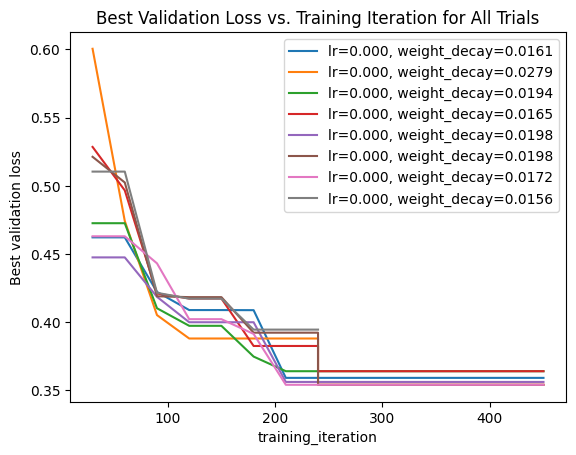

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(300, 150))

ax = None
for result in results_grid:
    label = f"lr={result.config['lr']:.3f}, weight_decay={result.config['weight_decay']:.4f}"
    if ax is None:
        ax = result.metrics_dataframe.plot("training_iteration", "best_val_loss", label=label)
    else:
        result.metrics_dataframe.plot("training_iteration", "best_val_loss", ax=ax, label=label)

ax.set_title("Best Validation Loss vs. Training Iteration for All Trials")
ax.set_ylabel("Best validation loss")
plt.show()  # Display the plot


As you might have noticed, the PBT is not exactly correct: it doesn't re-use models but re-starts training for all models without considering to continue any of them. This is due to the difficulty in providing a working trainable object with this particular train loop.

The positive thing about it is that it ensures HP perturbations and that it maintains only the best performing HP.

#### 3.e) Performance assessment and evaluation

Below, I will assess the performances of the best model obtained above on the test set.

In [ ]:
# Load the best fine tuned model and move it to GPU
id2label = {0: "method", 1: "background", 2: "result"}
label2id = {"method": 0, "background": 1, "result": 2}

best_model = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=3, id2label=id2label, label2id=label2id)

with best_result.checkpoint.as_directory() as checkpoint_dir:
    checkpoint = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))
    model_state_dict = checkpoint['model_state_dict']  # Extract only the model's state dictionary
    best_model.load_state_dict(model_state_dict)

best_model = best_model.to(device)

full_model_path = "/content/drive/MyDrive/Models/SciBERT_Models/FT_SciBERT/Uncased/SciBERT_uncased_ft.pt"
torch.save(best_model.state_dict(), full_model_path)

print(f"Model saved to {full_model_path}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model saved to /content/drive/MyDrive/Models/SciBERT_Models/FT_SciBERT/Uncased/SciBERT_uncased_ft.pt


Tokenize.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(ckp)

def tokenize_function(examples):
    augmented = ['[SECTION] ' + section + '. [CITATION] ' + string + ". Has function:" for section, string in zip(examples['sectionName'], examples['string'])]
    tokenized = tokenizer(augmented, max_length=tokenizer_length, padding='max_length', truncation=True)
    tokenized['augmented'] = augmented
    return tokenized

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['augmented', 'string', 'sectionName', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id'])#, 'token_type_ids'])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

In [ ]:
# Test dataset and dataloader
test_dataset = tokenized_datasets["test"]
eval_dataloader = DataLoader(test_dataset, batch_size=128)

In [ ]:
###############################################################################
########################### Performance assessment ############################
###############################################################################
from tqdm.auto import tqdm

predictions_list = []
labels_list = []

best_model.eval() # Set the model to evaluation mode
test_loss = 0.0
num_test_batches = 0

test_progress_bar = tqdm(eval_dataloader, desc="Evaluating on Test Set")

with torch.no_grad():  # Disable gradient computation
    for batch in test_progress_bar:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = best_model(**batch)
        loss = outputs.loss

        test_loss += loss.item()
        num_test_batches += 1

        # Store predictions and labels
        preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
        predictions_list.extend(preds)
        labels_list.extend(batch["labels"].cpu().numpy())

        test_progress_bar.set_postfix({"loss": loss.item()})

test_loss /= num_test_batches

print(f"Test Loss: {test_loss:.4f}")

# Calculate F1 score and accuracy using the stored predictions and labels
test_f1 = f1_score(labels_list, predictions_list, average="macro")
test_f1_none = f1_score(labels_list, predictions_list, average=None)
test_acc = accuracy_score(labels_list, predictions_list)

print(f"Test F1: {test_f1:.4f}, Test_f1_None: {test_f1_none} Test Acc: {test_acc:.4f}")
#was 86.50 macro-f1

Evaluating on Test Set:   0%|          | 0/15 [00:00<?, ?it/s]

Test Loss: 0.3218
Test F1: 0.8706, Test_f1_None: [0.8976249  0.89613035 0.81801126] Test Acc: 0.8854


## 4. Ensemble model

#### 4.a) Introduction to the methodology

In order to develop an ensemble model we first need to produce some base models capable of carrying out a part of the entire classification task. To this aim, I will build three different binary classifiers, each of which trained in recognizing whether a specific sentence can or cannot be classified as being part of a specific class.

In the end, I will obtain three binary classifiers:
- Background based model: aimed at correctly classifying whether a sentence is of type background or not;
- Method based model: aimed at correctly classifying whether a sentence is of type method or not;
- Result based model: aimed at correctly classifying whether a sentence is of type result or not.

Once I have the final predictions made by the models, I will use them as input to an ensemble classifier, for which I will inspect different possibilities.

#### 4.b) Base functions

Here, I define the basic functions useful to map labels to their binary counterpart.

In [7]:
def background_transform_labels(example):
    if example['label'] == 1:
        example['label'] = 1  # 'yes'
    elif example['label'] in [0, 2]:
        example['label'] = 0  # 'no'
    return example

def method_transform_labels(example):
    if example['label'] == 0:
        example['label'] = 1  # 'yes'
    elif example['label'] in [1, 2]:
        example['label'] = 0  # 'no'
    return example

def result_transform_labels(example):
    if example['label'] == 2:
        example['label'] = 1  # 'yes'
    elif example['label'] in [0, 1]:
        example['label'] = 0  # 'no'
    return example

Now, we need a training loop for these binary classifiers we aim at building. For these base models, I will not make use of Hyperparameter search strategies. The loop below is based on the same theoretical information given above (scaled, fine-grained eveluation...).

In [8]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from tqdm.auto import tqdm
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler

def train_model(model, class_weights_tensor, train_dataloader, val_dataloader, model_path):
    loss = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
    no_decay = ['bias', 'LayerNorm.weight']

    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

    # Replace StepLR with ReduceLROnPlateau
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=6, factor=0.2, cooldown=8, verbose=True)

    num_epochs = 5
    batch_counter = 0
    accumulation_steps = 1
    validation_interval = 10
    step_counter = 0

    best_val_loss = float('inf')
    best_model_path = model_path # 'background_model_loss.pt'
    best_val_f1 = float('-inf')
    #best_model_f1_path = 'background_model_f1.pt'

    # For mixed precision training
    scaler = GradScaler()

    # For early stopping
    no_improvement = 0
    early_stopping_patience = 50  # Number of evaluations with no improvement after which training will be stopped

    for epoch in range(num_epochs):
        train_loss = 0.0
        num_train_batches = 0
        train_predictions_list = []
        train_labels_list = []

        epoch_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")

        optimizer.zero_grad()

        for batch in epoch_progress_bar:
            batch = {k: v.to(device) for k, v in batch.items()}

            # Use autocast for mixed precision
            with autocast():
                outputs = model(**batch)
                loss = outputs.loss

            # Use scaler for backward
            scaler.scale(loss).backward()

            batch_counter += 1

            if batch_counter % accumulation_steps == 0:
                scaler.unscale_(optimizer)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                batch_counter = 0

            train_loss += loss.item()
            num_train_batches += 1

            train_preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
            train_predictions_list.extend(train_preds)
            train_labels_list.extend(batch["labels"].cpu().numpy())

            epoch_progress_bar.set_postfix({"train_loss": train_loss / num_train_batches})

            step_counter += 1

            if step_counter % validation_interval == 0:
                model.eval()
                val_loss = 0.0
                num_val_batches = 0
                val_predictions_list = []
                val_labels_list = []

                with torch.no_grad():
                    for batch in val_dataloader:
                        batch = {k: v.to(device) for k, v in batch.items()}

                        # Use autocast for mixed precision
                        with autocast():
                            outputs = model(**batch)
                            loss = outputs.loss

                        val_loss += loss.item()
                        num_val_batches += 1

                        val_preds = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
                        val_predictions_list.extend(val_preds)
                        val_labels_list.extend(batch["labels"].cpu().numpy())

                val_loss /= num_val_batches

                val_f1 = f1_score(val_labels_list, val_predictions_list, average="macro")
                val_acc = accuracy_score(val_labels_list, val_predictions_list)

                if val_f1 > best_val_f1:
                    best_val_f1 = val_f1
                    #torch.save(model_background.state_dict(), best_model_f1_path)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(model.state_dict(), best_model_path)
                    no_improvement = 0
                else:
                    no_improvement += 1
                    if no_improvement >= early_stopping_patience:
                        print("No improvement in validation loss for {} steps, stopping.".format(early_stopping_patience))
                        break

                scheduler.step(val_loss)

                print(f"Step {step_counter}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}, Val Acc: {val_acc:.4f}")
                print(f"Best Val Loss: {best_val_loss:.4f}")
                print(f"Best Val Macro-F1: {best_val_f1:.4f}")

                model.train()

        if no_improvement >= early_stopping_patience:
            break

        train_loss /= num_train_batches

        train_f1 = f1_score(train_labels_list, train_predictions_list, average="macro")
        train_acc = accuracy_score(train_labels_list, train_predictions_list)
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Train Acc: {train_acc:.4f}")

Finally, I write a function to compute class weights.

In [9]:
def compute_weight_tensor(tokenized_datasets):
    label_counts = Counter(tokenized_datasets['train']['label'])
    # Calculate weights
    class_weights = {k: 1.0 / v for k, v in label_counts.items()}
    # Normalize weights such that the sum of weights equals the number of classes
    total_weights = sum(class_weights.values())
    class_weights = {k: v * len(label_counts) / total_weights for k, v in class_weights.items()}
    # Transform the dict to a tensor and give it to device
    class_weights_tensor = torch.tensor([class_weights[i] for i in [0, 1]], dtype=torch.float).to(device)
    return class_weights_tensor

Now, we can go inside the specificity of each particular binary classifiers, each of which will make use of different weight for loss balance, and will work on different dataloaders.

#### 4.c) Base models

The operations for each model will be basically the same but with different objects and computations. Thus, I will explain them in detail only for their first appeareance.

First of all, let's download the dataset again and set the GPU device.

In [10]:
dataset = load_dataset("allenai/scicite", trust_remote_code=True)

if torch.cuda.is_available():
    print('cuda')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

cuda


Let's map the labels to the binary case thanks to the functions defined in the previous section.

In [11]:
background_datasets = dataset.map(background_transform_labels)
method_datasets = dataset.map(method_transform_labels)
result_datasets = dataset.map(result_transform_labels)

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Now, let's compute all the weights to balance the loss function.

In [12]:
background_weight_tensor = compute_weight_tensor(background_datasets)
method_weight_tensor = compute_weight_tensor(method_datasets)
result_weight_tensor = compute_weight_tensor(result_datasets)

Now, we can define the various dataloaders. But, before, we write a function to carry on the tokenization part.

In [13]:
tokenizer = AutoTokenizer.from_pretrained(ckp)

def tokenize_function(examples):
    augmented = [section + '. ' + string for section, string in zip(examples['sectionName'], examples['string'])]
    tokenized = tokenizer(augmented, max_length=256, padding='max_length', truncation=True)
    tokenized['augmented'] = augmented
    return tokenized

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [14]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def prepare_dataloader(dataset, batch_size, seed=None):
    if seed is not None:
        set_seed(seed)

    tokenized_datasets = dataset.map(tokenize_function, batched=True)
    tokenized_datasets = tokenized_datasets.remove_columns(['augmented', 'string', 'sectionName', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id'])
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
    tokenized_datasets.set_format("torch")

    train_dataset = tokenized_datasets["train"]
    val_dataset = tokenized_datasets["validation"]

    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    return train_dataloader, val_dataloader

batch_size = 32
random_seed = 1482

background_train_dataloader, background_val_dataloader = prepare_dataloader(background_datasets, batch_size, seed=random_seed)
method_train_dataloader, method_val_dataloader = prepare_dataloader(method_datasets, batch_size, seed=random_seed)
result_train_dataloader, result_val_dataloader = prepare_dataloader(result_datasets, batch_size, seed=random_seed)

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

It is important to notice that I will not use at all the test set with the base models. The first time the test set will be used is with the ensemble classifier.

##### <b>Background model</b>

Now, it is time to define the base models I will use for the ensemble classifier. Let's start with the Background model.

The steps will be the same for each model, so I will not repeat what I do.

The main part consists of a mapping between integer and literal labels. Such map must be fed to the PLM I will use, during the loading.

In [15]:
id2label = {0: "no", 1: "yes"}
label2id = {"no": 0, "yes": 1}

model_background = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
model_background = model_background.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Now, we can procede with the training. In order to do that, I will use the above defined training loop function.

In [16]:
train_model(model_background, background_weight_tensor, background_train_dataloader, background_val_dataloader, "background_model.pt")

Epoch 1/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 10, Val Loss: 0.4828, Val F1: 0.7837, Val Acc: 0.7959
Best Val Loss: 0.4828
Best Val Macro-F1: 0.7837
Step 20, Val Loss: 0.4322, Val F1: 0.8008, Val Acc: 0.8111
Best Val Loss: 0.4322
Best Val Macro-F1: 0.8008
Step 30, Val Loss: 0.4853, Val F1: 0.7876, Val Acc: 0.7893
Best Val Loss: 0.4322
Best Val Macro-F1: 0.8008
Step 40, Val Loss: 0.4440, Val F1: 0.7930, Val Acc: 0.8133
Best Val Loss: 0.4322
Best Val Macro-F1: 0.8008
Step 50, Val Loss: 0.3693, Val F1: 0.8327, Val Acc: 0.8395
Best Val Loss: 0.3693
Best Val Macro-F1: 0.8327
Step 60, Val Loss: 0.3585, Val F1: 0.8347, Val Acc: 0.8417
Best Val Loss: 0.3585
Best Val Macro-F1: 0.8347
Step 70, Val Loss: 0.3600, Val F1: 0.8344, Val Acc: 0.8439
Best Val Loss: 0.3585
Best Val Macro-F1: 0.8347
Step 80, Val Loss: 0.3579, Val F1: 0.8449, Val Acc: 0.8515
Best Val Loss: 0.3579
Best Val Macro-F1: 0.8449
Step 90, Val Loss: 0.3819, Val F1: 0.8312, Val Acc: 0.8428
Best Val Loss: 0.3579
Best Val Macro-F1: 0.8449
Step 100, Val Loss: 0.3461, Val F1: 0

Epoch 2/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 260, Val Loss: 0.3407, Val F1: 0.8560, Val Acc: 0.8624
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 270, Val Loss: 0.3435, Val F1: 0.8573, Val Acc: 0.8635
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 280, Val Loss: 0.3427, Val F1: 0.8607, Val Acc: 0.8646
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 290, Val Loss: 0.3424, Val F1: 0.8583, Val Acc: 0.8624
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 300, Val Loss: 0.3428, Val F1: 0.8549, Val Acc: 0.8592
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 310, Val Loss: 0.3441, Val F1: 0.8584, Val Acc: 0.8635
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 320, Val Loss: 0.3461, Val F1: 0.8612, Val Acc: 0.8668
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 330, Val Loss: 0.3479, Val F1: 0.8593, Val Acc: 0.8635
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 340, Val Loss: 0.3521, Val F1: 0.8552, Val Acc: 0.8592
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 350, Val Loss: 0.3426, 

Epoch 3/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 520, Val Loss: 0.3463, Val F1: 0.8666, Val Acc: 0.8712
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Epoch 00053: reducing learning rate of group 0 to 1.6000e-07.
Epoch 00053: reducing learning rate of group 1 to 1.6000e-07.
Step 530, Val Loss: 0.3458, Val F1: 0.8654, Val Acc: 0.8701
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 540, Val Loss: 0.3455, Val F1: 0.8654, Val Acc: 0.8701
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 550, Val Loss: 0.3455, Val F1: 0.8654, Val Acc: 0.8701
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 560, Val Loss: 0.3456, Val F1: 0.8666, Val Acc: 0.8712
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 570, Val Loss: 0.3458, Val F1: 0.8666, Val Acc: 0.8712
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 580, Val Loss: 0.3459, Val F1: 0.8666, Val Acc: 0.8712
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 590, Val Loss: 0.3459, Val F1: 0.8654, Val Acc: 0.8701
Best Val Loss: 0.3326
Best Val Macro-F1: 0.8677
Step 600, Va

##### <b>Method model</b>

In [17]:
id2label = {0: "no", 1: "yes"}
label2id = {"no": 0, "yes": 1}

model_method = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
model_method = model_method.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
train_model(model_method, method_weight_tensor, method_train_dataloader, method_val_dataloader, "method_model.pt")

Epoch 1/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 10, Val Loss: 0.3677, Val F1: 0.8116, Val Acc: 0.8657
Best Val Loss: 0.3677
Best Val Macro-F1: 0.8116
Step 20, Val Loss: 0.3225, Val F1: 0.8416, Val Acc: 0.8723
Best Val Loss: 0.3225
Best Val Macro-F1: 0.8416
Step 30, Val Loss: 0.3212, Val F1: 0.8491, Val Acc: 0.8799
Best Val Loss: 0.3212
Best Val Macro-F1: 0.8491
Step 40, Val Loss: 0.3123, Val F1: 0.8484, Val Acc: 0.8832
Best Val Loss: 0.3123
Best Val Macro-F1: 0.8491
Step 50, Val Loss: 0.3037, Val F1: 0.8600, Val Acc: 0.8865
Best Val Loss: 0.3037
Best Val Macro-F1: 0.8600
Step 60, Val Loss: 0.2887, Val F1: 0.8657, Val Acc: 0.8963
Best Val Loss: 0.2887
Best Val Macro-F1: 0.8657
Step 70, Val Loss: 0.2826, Val F1: 0.8682, Val Acc: 0.8985
Best Val Loss: 0.2826
Best Val Macro-F1: 0.8682
Step 80, Val Loss: 0.3015, Val F1: 0.8604, Val Acc: 0.8865
Best Val Loss: 0.2826
Best Val Macro-F1: 0.8682
Step 90, Val Loss: 0.2923, Val F1: 0.8642, Val Acc: 0.8963
Best Val Loss: 0.2826
Best Val Macro-F1: 0.8682
Step 100, Val Loss: 0.2811, Val F1: 0

Epoch 2/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 260, Val Loss: 0.2537, Val F1: 0.8703, Val Acc: 0.8985
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 270, Val Loss: 0.2542, Val F1: 0.8715, Val Acc: 0.8996
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 280, Val Loss: 0.2555, Val F1: 0.8712, Val Acc: 0.8996
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 290, Val Loss: 0.2567, Val F1: 0.8699, Val Acc: 0.8985
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 300, Val Loss: 0.2573, Val F1: 0.8661, Val Acc: 0.8941
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 310, Val Loss: 0.2587, Val F1: 0.8705, Val Acc: 0.8963
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 320, Val Loss: 0.2614, Val F1: 0.8729, Val Acc: 0.8974
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 330, Val Loss: 0.2569, Val F1: 0.8701, Val Acc: 0.8963
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 340, Val Loss: 0.2565, Val F1: 0.8725, Val Acc: 0.8996
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 350, Val Loss: 0.2570, 

Epoch 3/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 520, Val Loss: 0.2570, Val F1: 0.8787, Val Acc: 0.9039
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 530, Val Loss: 0.2567, Val F1: 0.8771, Val Acc: 0.9028
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 540, Val Loss: 0.2578, Val F1: 0.8722, Val Acc: 0.8996
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Epoch 00055: reducing learning rate of group 0 to 1.6000e-07.
Epoch 00055: reducing learning rate of group 1 to 1.6000e-07.
Step 550, Val Loss: 0.2589, Val F1: 0.8736, Val Acc: 0.9017
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 560, Val Loss: 0.2590, Val F1: 0.8736, Val Acc: 0.9017
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 570, Val Loss: 0.2590, Val F1: 0.8740, Val Acc: 0.9017
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 580, Val Loss: 0.2589, Val F1: 0.8740, Val Acc: 0.9017
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 590, Val Loss: 0.2586, Val F1: 0.8743, Val Acc: 0.9017
Best Val Loss: 0.2523
Best Val Macro-F1: 0.8794
Step 600, Va

##### <b>Result model</b>

In [19]:
id2label = {0: "no", 1: "yes"}
label2id = {"no": 0, "yes": 1}

model_result = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
model_result = model_result.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
train_model(model_result, result_weight_tensor, result_train_dataloader, result_val_dataloader, "result_model.pt")

Epoch 1/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 10, Val Loss: 0.3016, Val F1: 0.4806, Val Acc: 0.8679
Best Val Loss: 0.3016
Best Val Macro-F1: 0.4806
Step 20, Val Loss: 0.1977, Val F1: 0.8352, Val Acc: 0.9192
Best Val Loss: 0.1977
Best Val Macro-F1: 0.8352
Step 30, Val Loss: 0.1889, Val F1: 0.8534, Val Acc: 0.9323
Best Val Loss: 0.1889
Best Val Macro-F1: 0.8534
Step 40, Val Loss: 0.1905, Val F1: 0.8505, Val Acc: 0.9258
Best Val Loss: 0.1889
Best Val Macro-F1: 0.8534
Step 50, Val Loss: 0.1698, Val F1: 0.8518, Val Acc: 0.9301
Best Val Loss: 0.1698
Best Val Macro-F1: 0.8534
Step 60, Val Loss: 0.1708, Val F1: 0.8418, Val Acc: 0.9247
Best Val Loss: 0.1698
Best Val Macro-F1: 0.8534
Step 70, Val Loss: 0.1659, Val F1: 0.8411, Val Acc: 0.9236
Best Val Loss: 0.1659
Best Val Macro-F1: 0.8534
Step 80, Val Loss: 0.1658, Val F1: 0.8602, Val Acc: 0.9432
Best Val Loss: 0.1658
Best Val Macro-F1: 0.8602
Step 90, Val Loss: 0.1725, Val F1: 0.8557, Val Acc: 0.9290
Best Val Loss: 0.1658
Best Val Macro-F1: 0.8602
Step 100, Val Loss: 0.1629, Val F1: 0

Epoch 2/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 260, Val Loss: 0.1401, Val F1: 0.8850, Val Acc: 0.9454
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 270, Val Loss: 0.1460, Val F1: 0.8790, Val Acc: 0.9443
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 280, Val Loss: 0.1560, Val F1: 0.8796, Val Acc: 0.9432
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 290, Val Loss: 0.1425, Val F1: 0.8838, Val Acc: 0.9465
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Epoch 00030: reducing learning rate of group 0 to 4.0000e-06.
Epoch 00030: reducing learning rate of group 1 to 4.0000e-06.
Step 300, Val Loss: 0.1381, Val F1: 0.8826, Val Acc: 0.9454
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 310, Val Loss: 0.1357, Val F1: 0.8897, Val Acc: 0.9498
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 320, Val Loss: 0.1361, Val F1: 0.8897, Val Acc: 0.9498
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 330, Val Loss: 0.1340, Val F1: 0.8938, Val Acc: 0.9520
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 340, Va

Epoch 3/5:   0%|          | 0/257 [00:00<?, ?it/s]

Step 520, Val Loss: 0.1446, Val F1: 0.8905, Val Acc: 0.9498
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 530, Val Loss: 0.1451, Val F1: 0.8905, Val Acc: 0.9498
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 540, Val Loss: 0.1456, Val F1: 0.8905, Val Acc: 0.9498
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 550, Val Loss: 0.1466, Val F1: 0.8960, Val Acc: 0.9520
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 560, Val Loss: 0.1479, Val F1: 0.8940, Val Acc: 0.9509
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 570, Val Loss: 0.1487, Val F1: 0.8940, Val Acc: 0.9509
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 580, Val Loss: 0.1492, Val F1: 0.8940, Val Acc: 0.9509
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Step 590, Val Loss: 0.1485, Val F1: 0.8940, Val Acc: 0.9509
Best Val Loss: 0.1282
Best Val Macro-F1: 0.8969
Epoch 00060: reducing learning rate of group 0 to 1.6000e-07.
Epoch 00060: reducing learning rate of group 1 to 1.6000e-07.
Step 600, Va

##### <b>Best models</b>

Now, I retrieve and load back all the best models.

In [21]:
ckp = "allenai/scibert_scivocab_uncased"

# Paths of models checkpoints
background_model_path = "background_model.pt"
method_model_path = "method_model.pt"
result_model_path = "result_model.pt"

# Usual mapping
id2label = {0: "no", 1: "yes"}
label2id = {"no": 0, "yes": 1}

# Load the best fine-tuned models and move them to GPU
background_model_best = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
background_model_best.load_state_dict(torch.load(background_model_path))
background_model_best = background_model_best.to(device)
model_path = "/content/drive/MyDrive/Models/SciBERT_Models/Ensemble_SciBERT/Uncased/"+background_model_path
torch.save(background_model_best.state_dict(), model_path)

method_model_best = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
method_model_best.load_state_dict(torch.load(method_model_path))
method_model_best = method_model_best.to(device)
model_path = "/content/drive/MyDrive/Models/SciBERT_Models/Ensemble_SciBERT/Uncased/"+method_model_path
torch.save(method_model_best.state_dict(), model_path)

result_model_best = AutoModelForSequenceClassification.from_pretrained(ckp, num_labels=2, id2label=id2label, label2id=label2id)
result_model_best.load_state_dict(torch.load(result_model_path))
result_model_best = result_model_best.to(device)
model_path = "/content/drive/MyDrive/Models/SciBERT_Models/Ensemble_SciBERT/Uncased/"+result_model_path
torch.save(result_model_best.state_dict(), model_path)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### 4.d) Ensemble models

In this section, I will play around with some different possibilities for the ensemble classifier. Each of which will be explained in its core parts.

I will start with main ML algorithms, to then move into something more elaborated.

The first step, common to all the methodologies, is the use of the three base models, which won't be re-trained according to the final output, but I decide to use their predictions according to what their original training has produced.

To do so, I define a function to extract the binary predictions.

In [22]:
from tqdm import tqdm

def generate_predictions(dataloader, model1, model2, model3, device):
    model1 = model1.to(device).eval()
    model2 = model2.to(device).eval()
    model3 = model3.to(device).eval()

    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating predictions"):
            input_data = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            out1 = torch.softmax(model1(**input_data).logits, dim=-1)
            out2 = torch.softmax(model2(**input_data).logits, dim=-1)
            out3 = torch.softmax(model3(**input_data).logits, dim=-1)

            # The probabilities predicted for each class, for each model, are stacked
            out = torch.stack([out1, out2, out3], dim=-1)

            all_outputs.append(out)
            all_labels.append(labels)

    # Concatenate all outputs and labels along the batch dimension
    all_outputs = torch.cat(all_outputs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    return all_outputs, all_labels

Now, let's make use of this function to retrieve the base predictions.

In order to do this, we must first define the new dataloaders and class weights.

In [23]:
# To be sure we have back the original, I load again the dataset
dataset = load_dataset("allenai/scicite", trust_remote_code=True)

In [24]:
label_counts = Counter(dataset['train']['label'])
class_weights = {k: 1.0 / v for k, v in label_counts.items()}

total_weights = sum(class_weights.values())
class_weights = {k: v * len(label_counts) / total_weights for k, v in class_weights.items()}

class_weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float).to(device)
class_weights_tensor

tensor([0.8449, 0.3955, 1.7596], device='cuda:0')

In [25]:
tokenizer = AutoTokenizer.from_pretrained(ckp)

def tokenize_function(examples):
    augmented = [section + '. ' + string for section, string in zip(examples['sectionName'], examples['string'])]
    tokenized = tokenizer(augmented, max_length=256, padding='max_length', truncation=True)
    tokenized['augmented'] = augmented
    return tokenized

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['augmented', 'string', 'sectionName', 'citingPaperId', 'citedPaperId', 'excerpt_index', 'isKeyCitation', 'label2', 'citeEnd', 'citeStart', 'source', 'label_confidence', 'label2_confidence', 'id']) #'token_type_ids'])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1859 [00:00<?, ? examples/s]

In [26]:
train_dataset = tokenized_datasets["train"]
val_dataset = tokenized_datasets["validation"]
test_dataset = tokenized_datasets["test"]

train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)
eval_dataloader = DataLoader(test_dataset, batch_size=128)

In the following snippet, I extract the predictions done by base models. These will be used as input for the ML models I will try on the task.

In [27]:
base_model_outputs_train = generate_predictions(train_dataloader, background_model_best, method_model_best, result_model_best, device)
base_model_outputs_val = generate_predictions(val_dataloader, background_model_best, method_model_best, result_model_best, device)
base_model_outputs_test = generate_predictions(eval_dataloader, background_model_best, method_model_best, result_model_best, device)

Generating predictions: 100%|██████████| 15/15 [00:15<00:00,  1.05s/it]


Let's now set up a train, validation, test split with our data.

In [28]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Get the numpy arrays from the datasets
X_train = base_model_outputs_train[0].view(len(base_model_outputs_train[0]), -1).cpu().numpy()
y_train = base_model_outputs_train[1].cpu().numpy()

X_val = base_model_outputs_val[0].view(len(base_model_outputs_val[0]), -1).cpu().numpy()
y_val = base_model_outputs_val[1].cpu().numpy()

X_test = base_model_outputs_test[0].view(len(base_model_outputs_test[0]), -1).cpu().numpy()
y_test = base_model_outputs_test[1].cpu().numpy()

Before moving on, we need to create Dataset and Dataloader objects in order to handle data. These, will be used as input/output providers for our deep learning experiments.

In [29]:
from torch.utils.data import Dataset

class MetaClassifierDataset(Dataset):
    def __init__(self, outputs, labels):
        self.outputs = outputs.view(len(outputs), -1)  # Flatten the inputs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.outputs[idx], self.labels[idx]

train_dataset = MetaClassifierDataset(base_model_outputs_train[0], base_model_outputs_train[1])
val_dataset = MetaClassifierDataset(base_model_outputs_val[0], base_model_outputs_val[1])
test_dataset = MetaClassifierDataset(base_model_outputs_test[0], base_model_outputs_test[1])

# I do not build Dataloaders here because I will do it when necessary

#train_dataloader_dl = DataLoader(train_dataset, batch_size=32, shuffle=True)
#val_dataloader_dl = DataLoader(val_dataset, batch_size=64, shuffle=False)
#eval_dataloader_dl = DataLoader(test_dataset, batch_size=64, shuffle=False)

##### <b>Confidence based selection</b>

Before getting into ML algorithms, I'd like to try a confidence based selection of the most probable class. To do so, I will make use of the same generate predictions functions, together with a function useful to extract the prediction with higher probability among the others.

Now, let's inspect a single prediction.

In [30]:
X_test[0]

array([0.7029708 , 0.4767115 , 0.995869  , 0.29702917, 0.5232885 ,
       0.00413101], dtype=float32)

For what we can see, the prediction is a 6-elements array, and it has the following structure:

    [background_negative, method_negative, result_negative, background_positive, method_positive, result_positive]

Thus, in order to get the positive predictions, we have to take into consideration the last three elements of the array.

<b><u>Highest score voting</u></b>

What I will do below, is to extract the final result by simply looking at the highest among the three positive predictions. In this way, we will see whether the 3 base BERT work well, and we have a base for a comparison with more advanced algorithms.

In [31]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

def classify_prediction(predictions):
    """
    Takes in the stacked predictions and returns the label of the highest positive predicted value.

    Parameters:
    - predictions (list or numpy array): Stacked predictions of shape
    [background_positive, method_positive, result_positive]

    Returns:
    - int: 0 (for 'method'), 1 (for 'background'), or 2 (for 'result')
    """

    background_positive = predictions[3]
    method_positive = predictions[4]
    result_positive = predictions[5]

    max_index = np.argmax([method_positive, background_positive, result_positive])

    # Use argmax to get the index of the highest positive predicted value
    # the index is consistent with the integer labels, as explained above
    return max_index

# For each sample in X_test, I classify it using the classify_prediction function
predicted_labels = [classify_prediction(X_test[i]) for i in range(X_test.shape[0])]

# Compare predictions and true labels
accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')

# Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8854
Macro F1-Score: 0.8735
              precision    recall  f1-score   support

      method       0.94      0.84      0.89       604
  background       0.88      0.91      0.90       996
      result       0.79      0.89      0.84       259

    accuracy                           0.89      1859
   macro avg       0.87      0.88      0.87      1859
weighted avg       0.89      0.89      0.89      1859



As we can see, this simple strategy gives yet very good results, producing a macro-F1 score of 87.35%, surpassing most of the models in the [benchmark](https://paperswithcode.com/sota/citation-intent-classification-on-scicite) table, and getting the second best result.

Let's now see if we can further improve this score.

##### <b>Random Forest</b>

The first algorithm I will try is Random Forest. To do so, I will make use of a grid search for HP optimization. The HP for which I want to explore different configurations are:
- n_estimators: number of individual decision trees to be included in the random forest ensemble;
- max_depth: determines the maximum depth of each decision tree in the ensemble;
- min_samples_split: specifies the minimum number of samples required to split an internal node of a decision tree;
- min_samples_leaf: determines the minimum number of samples required to be in a leaf node of a decision tree;
- bootstrap: whether to train or not each tree on the entire dataset (it happens with bootstrap=False);
- criterion: the criterion used for node splitting, can be gini imppurity, or entropy;
- class_weight: to see whether adding weights for class imbalance helps or not.

These HP may determine whether the model overfits, underfits, or is sufficiently well adapted to data. Additionally, we should be able to see whether the model has some particular combination that allows it to better adapt to the task at hand.

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

X_train_val = np.vstack((X_train, X_val))
y_train_val = np.hstack((y_train, y_val))

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [3, 5],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None]
}

# Define the scoring metric
scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

# Create the Random Forest classifier
rf = RandomForestClassifier(random_state=1482)

# Perform grid search with cross-validation
grid_rf = GridSearchCV(rf, param_grid, scoring=scoring, cv=5, refit="f1_macro", verbose=3)

# Fit the grid search to the training data
grid_rf.fit(X_train_val, y_train_val)

# Print the best parameters and the best score
print("Best parameters: ", grid_rf.best_params_)
print("Best score: ", grid_rf.best_score_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV 1/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.888) total time=   0.1s
[CV 2/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.887) total time=   0.1s
[CV 3/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.892) total time=   0.1s
[CV 4/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.881) total time=   0.1s
[CV 5/5] END bootstrap=True, class_weight=balanced, criterion=gini, max_depth=3, min_samples_leaf=3, min_samples_split=2, n_estimators=10; f1_macro: (test=0.861) total time=   0.1s
[CV 1/5] END bootstrap=True, cla

And now, let's check the best performing model on our test set.

In [33]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

predicted_labels = grid_rf.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8817
Macro F1-Score: 0.8685
              precision    recall  f1-score   support

      method       0.92      0.85      0.89       604
  background       0.90      0.89      0.89       996
      result       0.76      0.90      0.82       259

    accuracy                           0.88      1859
   macro avg       0.86      0.88      0.87      1859
weighted avg       0.89      0.88      0.88      1859



As we can see, the Random Forest algorith do not surpass our highest vote system.

##### <b>XGBoost</b>

Now, I will try XGBoost technique, which implements machine learning algorithms under the Gradient Boosting framework. This means it works by combining the results of several weak learners (typically decision trees) into a single strong learner in an iterative fashion.

I will search in the HP space for:
- learning_rate: Also known as the step size. It determines the step size at each iteration while moving toward a minimum loss function. By default, XGBoost sets it to 0.3. Lower values make the optimization more robust, but require more boosting rounds;
- max_depth: The maximum depth of a tree;
- n_estimators: It defines the number of boosting rounds or trees to build.

In [34]:
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, f1_score

X_train_val = np.vstack((X_train, X_val))
y_train_val = np.hstack((y_train, y_val))

# Define the model
xgb = XGBClassifier(eval_metric='mlogloss', random_state=1482)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.05],
    'max_depth': [3, 5, 10],
    'n_estimators': [10, 50, 100],
    'gamma': [0, 0.05, 0.1]
}

# Define scoring metric
scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

# Create the grid search object
grid_xgb = GridSearchCV(xgb, param_grid, cv=5, scoring=scoring, refit='f1_macro', verbose=3)

# Fit the grid search object to the data
grid_xgb.fit(X_train_val, y_train_val)

# Print the best parameters and the best score
print("Best parameters: ", grid_xgb.best_params_)
print("Best score: ", grid_xgb.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.910) total time=   0.0s
[CV 2/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.903) total time=   0.0s
[CV 3/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.895) total time=   0.0s
[CV 4/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.898) total time=   0.0s
[CV 5/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=10; f1_macro: (test=0.878) total time=   0.0s
[CV 1/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50; f1_macro: (test=0.902) total time=   0.1s
[CV 2/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50; f1_macro: (test=0.903) total time=   0.1s
[CV 3/5] END gamma=0, learning_rate=0.001, max_depth=3, n_estimators=50; f1_macro: (test=0.896) total time=   0.1s
[CV 4/5] END gamma

In [35]:
# The best model is:
model = grid_xgb.best_estimator_
predicted_labels = model.predict(X_test)

accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8908
Macro F1-Score: 0.8777
              precision    recall  f1-score   support

      method       0.94      0.86      0.89       604
  background       0.89      0.92      0.90       996
      result       0.80      0.87      0.83       259

    accuracy                           0.89      1859
   macro avg       0.88      0.88      0.88      1859
weighted avg       0.89      0.89      0.89      1859



As we can see, with XGBoost we have been able to improve base performances to 87.77%.

##### <b>K-Nearest Neighbors</b>

This step involves using KNN algorithm. With this, I operate a grid search only on the number of neighbors.


In [36]:
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Stack the training and validation sets
X_train_val = np.vstack((X_train, X_val))
y_train_val = np.hstack((y_train, y_val))

# Create a K-NN classifier
knn = KNeighborsClassifier() # This time we cannot set a seed, since the KNN is deterministic

# Define the parameter values that should be searched
k_range = list(range(1, 101))

# Create a parameter grid, which maps the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)

# I define the scoring metric
scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

# Instantiate the grid
grid_knn = GridSearchCV(knn, param_grid, cv=5, scoring=scoring, refit='f1_macro', verbose=3)

# Fit the grid with data
grid_knn.fit(X_train_val, y_train_val)

# View the complete results
print(grid_knn.cv_results_)

# Examine the best model
print("Best score: ", grid_knn.best_score_)
print("Best parameters: ", grid_knn.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END ...........n_neighbors=1; f1_macro: (test=0.863) total time=   0.1s
[CV 2/5] END ...........n_neighbors=1; f1_macro: (test=0.858) total time=   0.1s
[CV 3/5] END ...........n_neighbors=1; f1_macro: (test=0.863) total time=   0.1s
[CV 4/5] END ...........n_neighbors=1; f1_macro: (test=0.855) total time=   0.1s
[CV 5/5] END ...........n_neighbors=1; f1_macro: (test=0.827) total time=   0.1s
[CV 1/5] END ...........n_neighbors=2; f1_macro: (test=0.851) total time=   0.1s
[CV 2/5] END ...........n_neighbors=2; f1_macro: (test=0.853) total time=   0.1s
[CV 3/5] END ...........n_neighbors=2; f1_macro: (test=0.856) total time=   0.1s
[CV 4/5] END ...........n_neighbors=2; f1_macro: (test=0.845) total time=   0.1s
[CV 5/5] END ...........n_neighbors=2; f1_macro: (test=0.825) total time=   0.1s
[CV 1/5] END ...........n_neighbors=3; f1_macro: (test=0.882) total time=   0.1s
[CV 2/5] END ...........n_neighbors=3; f1_macr

In [37]:
# The best model is:
model = grid_knn.best_estimator_
predicted_labels = model.predict(X_test)

accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8860
Macro F1-Score: 0.8733
              precision    recall  f1-score   support

      method       0.94      0.85      0.89       604
  background       0.90      0.90      0.90       996
      result       0.76      0.91      0.83       259

    accuracy                           0.89      1859
   macro avg       0.87      0.89      0.87      1859
weighted avg       0.89      0.89      0.89      1859



##### <b>Support Vector Machine</b>

It is now time to try with our last ML algorithm, SVM.
For this, I will operate again a grid search, and this time the HP I will consider are the following:
-

In [38]:
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE

# Stack the training and validation sets
X_train_val = np.vstack((X_train, X_val))
y_train_val = np.hstack((y_train, y_val))


# Define the parameter ranges
param_grid = {
    'C': [0.01, 0.1],
    'gamma': [1, 'scale', 'auto'],
    'kernel': ['rbf', 'sigmoid'], # I exclude linear kernel because hardly could provide good results, I also exclude poly kernel in order to avoid to deal with degree HP
    'class_weight': [None, 'balanced']
}

scoring = {'f1_macro': make_scorer(f1_score, average='macro')}
grid_svm = GridSearchCV(SVC(probability=True, random_state=1482), param_grid, cv=5, scoring=scoring, refit='f1_macro', verbose=3)

# Fit on the data
grid_svm.fit(X_train_val, y_train_val)

# Print the best parameters
print(grid_svm.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.906) total time=   3.1s
[CV 2/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.904) total time=   3.1s
[CV 3/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.889) total time=   3.1s
[CV 4/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.890) total time=   3.1s
[CV 5/5] END C=0.01, class_weight=None, gamma=1, kernel=rbf; f1_macro: (test=0.865) total time=   3.0s
[CV 1/5] END C=0.01, class_weight=None, gamma=1, kernel=sigmoid; f1_macro: (test=0.908) total time=  10.3s
[CV 2/5] END C=0.01, class_weight=None, gamma=1, kernel=sigmoid; f1_macro: (test=0.902) total time=  10.2s
[CV 3/5] END C=0.01, class_weight=None, gamma=1, kernel=sigmoid; f1_macro: (test=0.895) total time=  10.3s
[CV 4/5] END C=0.01, class_weight=None, gamma=1, kernel=sigmoid; f1_macro: (test=0.894) total time=  1

In [39]:
# The best model is:
model = grid_svm.best_estimator_
predicted_labels = model.predict(X_test)

accuracy = accuracy_score(y_test, predicted_labels)
macro_f1 = f1_score(y_test, predicted_labels, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
report = classification_report(y_test, predicted_labels, target_names=['method', 'background', 'result'])
print(report)

Accuracy: 0.8833
Macro F1-Score: 0.8712
              precision    recall  f1-score   support

      method       0.92      0.87      0.89       604
  background       0.91      0.88      0.89       996
      result       0.73      0.94      0.83       259

    accuracy                           0.88      1859
   macro avg       0.86      0.90      0.87      1859
weighted avg       0.89      0.88      0.88      1859



As you can see, SVM do not reach our top model, so we can procede and analyze DL based strategies.

#### <b>Meta Classifiers</b>

In this section, I will work on different NN architectures. In this case, HP search is manually performed through different tests. This is because I would like to have more control over training loop and get to see if and how something doesn't work. This is not so easy to do with Ray Tune Report. In particular, beside model definition, I will play around learning rate, weight decay and batch size.

The first step implies the definition of 3 main functions: one to plot the training history, one to train the models, and one to evaluate them.

In [40]:
def set_seed(seed_value=1482):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed_value)
    random.seed(seed_value)

In [41]:
def plot_metrics(train_metrics, val_metrics, metric_name):
    plt.plot(train_metrics, label=f'Training {metric_name}')
    plt.plot(val_metrics, label=f'Validation {metric_name}')
    plt.legend()
    plt.title(f'Training and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.show()

In [42]:
from torch.optim import lr_scheduler

def train_metaclassifier(meta_classifier, batch_size, num_epochs, lr, weight_decay, train_dataset, val_dataset, model_path):
    set_seed()

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

    train_losses = []
    train_f1_scores = []
    val_losses = []
    val_f1_scores = []

    early_stopping_counter = 0
    early_stopping_patience = 30
    best_val_loss = float('inf')

    # I will only optimize the parameters of the MetaClassifier, not the other models
    optimizer = AdamW(meta_classifier.parameters(), lr=lr, weight_decay=weight_decay)

    # Initialize ReduceLROnPlateau scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, cooldown=5, verbose=True)
    loss_fn = torch.nn.CrossEntropyLoss()#weight=class_weights_tensor

    # Initialize GradScaler for mixed precision
    scaler = GradScaler()

    for epoch in range(num_epochs):
        progress_bar = tqdm(train_dataloader, desc='Epoch {:1d}'.format(epoch), leave=True, disable=False)
        meta_classifier.train()

        train_loss = 0.0
        train_preds = []
        train_labels = []

        for batch_idx, batch in enumerate(progress_bar):
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device).long()

            # Autocast for mixed precision
            with autocast():
                outputs = meta_classifier(inputs)
                loss = loss_fn(outputs, labels)

            # Scales the loss, and calls backward() on scaled loss to create scaled gradients
            scaler.scale(loss).backward()

            # Unscales the gradients of optimizer's assigned params in-place and calls
            # optimizer.step() if no infs/NaNs are found in the gradients.
            # Otherwise, optimizer.step() is skipped to avoid stepping on infs/NaNs
            scaler.step(optimizer)

            # Updates the scale for next iteration.
            scaler.update()

            # Resets gradients
            optimizer.zero_grad()

            train_loss += loss.item()
            train_preds.extend(outputs.detach().cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(inputs))})

        avg_train_loss = train_loss/len(train_dataloader)
        train_f1 = f1_score(train_labels, np.argmax(train_preds, axis=1), average='macro')
        train_losses.append(avg_train_loss)
        train_f1_scores.append(train_f1)
        print(f"\nTraining Loss at end of epoch {epoch}: {avg_train_loss}")
        print(f"Training F1 Score at end of epoch {epoch}: {train_f1}")

        # Evaluate on validation data after each epoch
        meta_classifier.eval()
        val_preds = []
        val_labels = []
        val_loss = 0.0

        with torch.no_grad():
            for batch in val_dataloader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device).long()

                outputs = meta_classifier(inputs)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item()
                val_preds.extend(outputs.detach().cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss/len(val_dataloader)
        val_f1_macro = f1_score(val_labels, np.argmax(val_preds, axis=1), average='macro')

        # Early stopping condition check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0

            # Save the model
            torch.save(meta_classifier.state_dict(), model_path)
            print(f"New best model saved with validation loss: {best_val_loss}")
        else:
            early_stopping_counter += 1

        # Break training loop
        if early_stopping_counter > early_stopping_patience:
            print(f"No improvement in Validation Loss for {early_stopping_patience} epochs. Training stops.")
            break

        val_f1_weighted = f1_score(val_labels, np.argmax(val_preds, axis=1), average=None)
        val_losses.append(avg_val_loss)
        val_f1_scores.append(val_f1_macro)
        print(f"\nValidation Loss at end of epoch {epoch}: {avg_val_loss}")
        print(f"Validation Macro F1 Score at end of epoch {epoch}: {val_f1_macro}")
        print(f"Validation Weighted F1 Score at end of epoch {epoch}: {val_f1_weighted}")
        scheduler.step(avg_val_loss)

    plot_metrics(train_losses, val_losses, 'Loss')
    plot_metrics(train_f1_scores, val_f1_scores, 'F1 Score')

In [43]:
def evaluate_metaclassifier(meta_classifier, test_dataset):
    eval_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    loss_fn = torch.nn.CrossEntropyLoss()
    meta_classifier.eval()  # Set the model to evaluation mode
    test_preds = []
    test_labels = []
    test_loss = 0.0

    with torch.no_grad():
        for batch in eval_dataloader:
            inputs = batch[0].to(device)
            labels = batch[1].to(device).long()

            outputs = meta_classifier(inputs)
            loss = loss_fn(outputs, labels)

            test_loss += loss.item()
            test_preds.extend(outputs.detach().cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss/len(eval_dataloader)
    test_f1_macro = f1_score(test_labels, np.argmax(test_preds, axis=1), average='macro')
    test_f1_weighted = f1_score(test_labels, np.argmax(test_preds, axis=1), average=None)
    test_accuracy = accuracy_score(test_labels, np.argmax(test_preds, axis=1))

    print(f"\nTest Loss: {avg_test_loss}")
    print(f"Test Macro F1 Score: {test_f1_macro}")
    print(f"Test Weighted F1 Score: {test_f1_weighted}")
    print(f"Test Accuracy: {test_accuracy}")

##### <b>Feed Forward NN</b>

The first thing I'd like to try is a simple feed forward NN. In it, I integrate both Batch Normalization and Dropout layers.

In [44]:
import torch.nn as nn
import torch.nn.functional as F

class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()

        self.fc1 = nn.Linear(6, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 3)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout(x)

        x = F.gelu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout(x)

        x = F.selu(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout(x)

        x = F.selu(self.fc4(x))
        x = self.bn4(x)
        x = self.dropout(x)

        x = self.fc5(x)
        x = F.softmax(x, dim=1)

        return x


Epoch 0: 100%|██████████| 65/65 [00:00<00:00, 136.53it/s, training_loss=0.569]



Training Loss at end of epoch 0: 1.0439529473964984
Training F1 Score at end of epoch 0: 0.4470430169889297
New best model saved with validation loss: 0.9640021175146103

Validation Loss at end of epoch 0: 0.9640021175146103
Validation Macro F1 Score at end of epoch 0: 0.8251391090357804
Validation Weighted F1 Score at end of epoch 0: [0.8172043  0.88530466 0.77290837]


Epoch 1: 100%|██████████| 65/65 [00:00<00:00, 143.07it/s, training_loss=0.470]



Training Loss at end of epoch 1: 0.9879275560379028
Training F1 Score at end of epoch 1: 0.5597120209543309
New best model saved with validation loss: 0.8963101506233215

Validation Loss at end of epoch 1: 0.8963101506233215
Validation Macro F1 Score at end of epoch 1: 0.8310160990484962
Validation Weighted F1 Score at end of epoch 1: [0.83366733 0.88202247 0.77735849]


Epoch 2: 100%|██████████| 65/65 [00:00<00:00, 155.78it/s, training_loss=0.519]



Training Loss at end of epoch 2: 0.9457026894275958
Training F1 Score at end of epoch 2: 0.6420639185756017
New best model saved with validation loss: 0.846627838909626

Validation Loss at end of epoch 2: 0.846627838909626
Validation Macro F1 Score at end of epoch 2: 0.8348633107125608
Validation Weighted F1 Score at end of epoch 2: [0.83636364 0.8866171  0.7816092 ]


Epoch 3: 100%|██████████| 65/65 [00:00<00:00, 154.89it/s, training_loss=0.520]



Training Loss at end of epoch 3: 0.905010907466595
Training F1 Score at end of epoch 3: 0.7132154003365457
New best model saved with validation loss: 0.8248298764228821

Validation Loss at end of epoch 3: 0.8248298764228821
Validation Macro F1 Score at end of epoch 3: 0.8337838984885887
Validation Weighted F1 Score at end of epoch 3: [0.832      0.88640596 0.78294574]


Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 156.02it/s, training_loss=0.366]



Training Loss at end of epoch 4: 0.8655399129940913
Training F1 Score at end of epoch 4: 0.760909613073049
New best model saved with validation loss: 0.7908807024359703

Validation Loss at end of epoch 4: 0.7908807024359703
Validation Macro F1 Score at end of epoch 4: 0.8329734800605347
Validation Weighted F1 Score at end of epoch 4: [0.83137255 0.8849392  0.7826087 ]


Epoch 5: 100%|██████████| 65/65 [00:00<00:00, 159.65it/s, training_loss=0.408]



Training Loss at end of epoch 5: 0.8406402101883521
Training F1 Score at end of epoch 5: 0.7968528213401601
New best model saved with validation loss: 0.767162911593914

Validation Loss at end of epoch 5: 0.767162911593914
Validation Macro F1 Score at end of epoch 5: 0.8346978505240731
Validation Weighted F1 Score at end of epoch 5: [0.83910387 0.8880666  0.77692308]


Epoch 6: 100%|██████████| 65/65 [00:00<00:00, 155.51it/s, training_loss=0.525]



Training Loss at end of epoch 6: 0.8225195591266339
Training F1 Score at end of epoch 6: 0.8217726083449058
New best model saved with validation loss: 0.7662821412086487

Validation Loss at end of epoch 6: 0.7662821412086487
Validation Macro F1 Score at end of epoch 6: 0.8311187347723354
Validation Weighted F1 Score at end of epoch 6: [0.82514735 0.88389513 0.78431373]


Epoch 7: 100%|██████████| 65/65 [00:00<00:00, 161.16it/s, training_loss=0.470]



Training Loss at end of epoch 7: 0.8044712708546565
Training F1 Score at end of epoch 7: 0.8373625974622575
New best model saved with validation loss: 0.7473121136426926

Validation Loss at end of epoch 7: 0.7473121136426926
Validation Macro F1 Score at end of epoch 7: 0.8376632986637675
Validation Weighted F1 Score at end of epoch 7: [0.83040936 0.88576779 0.79681275]


Epoch 8: 100%|██████████| 65/65 [00:00<00:00, 161.88it/s, training_loss=0.393]



Training Loss at end of epoch 8: 0.7867508824055012
Training F1 Score at end of epoch 8: 0.8530665533163747
New best model saved with validation loss: 0.7431964799761772

Validation Loss at end of epoch 8: 0.7431964799761772
Validation Macro F1 Score at end of epoch 8: 0.8339446826650617
Validation Weighted F1 Score at end of epoch 8: [0.82666667 0.88151659 0.79365079]


Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 161.76it/s, training_loss=0.524]



Training Loss at end of epoch 9: 0.7798639627603384
Training F1 Score at end of epoch 9: 0.8586399304482665

Validation Loss at end of epoch 9: 0.7433769479393959
Validation Macro F1 Score at end of epoch 9: 0.8351752845017947
Validation Weighted F1 Score at end of epoch 9: [0.83168317 0.88785047 0.78599222]


Epoch 10: 100%|██████████| 65/65 [00:00<00:00, 158.95it/s, training_loss=0.355]



Training Loss at end of epoch 10: 0.7624398396565364
Training F1 Score at end of epoch 10: 0.8631621058730029
New best model saved with validation loss: 0.7328611761331558

Validation Loss at end of epoch 10: 0.7328611761331558
Validation Macro F1 Score at end of epoch 10: 0.8328755292505451
Validation Weighted F1 Score at end of epoch 10: [0.83040936 0.88454376 0.78367347]


Epoch 11: 100%|██████████| 65/65 [00:00<00:00, 156.07it/s, training_loss=0.527]



Training Loss at end of epoch 11: 0.7596302270889282
Training F1 Score at end of epoch 11: 0.8702082769493366

Validation Loss at end of epoch 11: 0.7394518107175827
Validation Macro F1 Score at end of epoch 11: 0.8330172220979647
Validation Weighted F1 Score at end of epoch 11: [0.82666667 0.88022814 0.79215686]


Epoch 12: 100%|██████████| 65/65 [00:00<00:00, 155.19it/s, training_loss=0.350]



Training Loss at end of epoch 12: 0.7442723173361558
Training F1 Score at end of epoch 12: 0.8764715740211733

Validation Loss at end of epoch 12: 0.7367196008563042
Validation Macro F1 Score at end of epoch 12: 0.8338460196172802
Validation Weighted F1 Score at end of epoch 12: [0.83033932 0.8849392  0.78625954]


Epoch 13: 100%|██████████| 65/65 [00:00<00:00, 149.17it/s, training_loss=0.331]



Training Loss at end of epoch 13: 0.7400464195471543
Training F1 Score at end of epoch 13: 0.8761095528920486
New best model saved with validation loss: 0.7249091565608978

Validation Loss at end of epoch 13: 0.7249091565608978
Validation Macro F1 Score at end of epoch 13: 0.8336001674611668
Validation Weighted F1 Score at end of epoch 13: [0.82965932 0.88682746 0.78431373]


Epoch 14: 100%|██████████| 65/65 [00:00<00:00, 151.54it/s, training_loss=0.358]



Training Loss at end of epoch 14: 0.7344215475595914
Training F1 Score at end of epoch 14: 0.8803031336170447
New best model saved with validation loss: 0.7155789956450462

Validation Loss at end of epoch 14: 0.7155789956450462
Validation Macro F1 Score at end of epoch 14: 0.8363715401496602
Validation Weighted F1 Score at end of epoch 14: [0.83070866 0.88640596 0.792     ]


Epoch 15: 100%|██████████| 65/65 [00:00<00:00, 157.04it/s, training_loss=0.325]



Training Loss at end of epoch 15: 0.7302946494175837
Training F1 Score at end of epoch 15: 0.879246306898218

Validation Loss at end of epoch 15: 0.7251332402229309
Validation Macro F1 Score at end of epoch 15: 0.8383981909532605
Validation Weighted F1 Score at end of epoch 15: [0.82868526 0.8880597  0.79844961]


Epoch 16: 100%|██████████| 65/65 [00:00<00:00, 161.47it/s, training_loss=0.519]



Training Loss at end of epoch 16: 0.7280907291632432
Training F1 Score at end of epoch 16: 0.8829002762197495
New best model saved with validation loss: 0.7135093659162521

Validation Loss at end of epoch 16: 0.7135093659162521
Validation Macro F1 Score at end of epoch 16: 0.8414155413150821
Validation Weighted F1 Score at end of epoch 16: [0.8313253  0.8913649  0.80155642]


Epoch 17: 100%|██████████| 65/65 [00:00<00:00, 155.47it/s, training_loss=0.374]



Training Loss at end of epoch 17: 0.7196392994660598
Training F1 Score at end of epoch 17: 0.8858084796449486
New best model saved with validation loss: 0.7069637328386307

Validation Loss at end of epoch 17: 0.7069637328386307
Validation Macro F1 Score at end of epoch 17: 0.8389392053017012
Validation Weighted F1 Score at end of epoch 17: [0.83767535 0.89052438 0.78861789]


Epoch 18: 100%|██████████| 65/65 [00:00<00:00, 151.43it/s, training_loss=0.610]



Training Loss at end of epoch 18: 0.7217395323973436
Training F1 Score at end of epoch 18: 0.8855890660207163

Validation Loss at end of epoch 18: 0.7145899087190628
Validation Macro F1 Score at end of epoch 18: 0.8399142899364563
Validation Weighted F1 Score at end of epoch 18: [0.83168317 0.8880597  0.8       ]


Epoch 19: 100%|██████████| 65/65 [00:00<00:00, 152.96it/s, training_loss=0.558]



Training Loss at end of epoch 19: 0.7174488691183237
Training F1 Score at end of epoch 19: 0.8903197624020135

Validation Loss at end of epoch 19: 0.7120205238461494
Validation Macro F1 Score at end of epoch 19: 0.8411072451622984
Validation Weighted F1 Score at end of epoch 19: [0.83266932 0.88909599 0.80155642]


Epoch 20: 100%|██████████| 65/65 [00:00<00:00, 157.55it/s, training_loss=0.516]



Training Loss at end of epoch 20: 0.7111879064486577
Training F1 Score at end of epoch 20: 0.8922515206090691

Validation Loss at end of epoch 20: 0.7119277194142342
Validation Macro F1 Score at end of epoch 20: 0.8409603279168496
Validation Weighted F1 Score at end of epoch 20: [0.83399209 0.88888889 0.8       ]


Epoch 21: 100%|██████████| 65/65 [00:00<00:00, 157.68it/s, training_loss=0.287]



Training Loss at end of epoch 21: 0.7033180236816406
Training F1 Score at end of epoch 21: 0.8886834897833893

Validation Loss at end of epoch 21: 0.714252844452858
Validation Macro F1 Score at end of epoch 21: 0.8423159097085927
Validation Weighted F1 Score at end of epoch 21: [0.83299799 0.89239332 0.80155642]


Epoch 22: 100%|██████████| 65/65 [00:00<00:00, 151.72it/s, training_loss=0.535]



Training Loss at end of epoch 22: 0.7086412750757658
Training F1 Score at end of epoch 22: 0.8903356974815614

Validation Loss at end of epoch 22: 0.7114121466875076
Validation Macro F1 Score at end of epoch 22: 0.8364021681274174
Validation Weighted F1 Score at end of epoch 22: [0.83070866 0.88472352 0.79377432]


Epoch 23: 100%|██████████| 65/65 [00:00<00:00, 152.85it/s, training_loss=0.506]



Training Loss at end of epoch 23: 0.7050775913091806
Training F1 Score at end of epoch 23: 0.8920950239556494

Validation Loss at end of epoch 23: 0.7096430957317352
Validation Macro F1 Score at end of epoch 23: 0.8365642117274477
Validation Weighted F1 Score at end of epoch 23: [0.83040936 0.88240828 0.796875  ]


Epoch 24: 100%|██████████| 65/65 [00:00<00:00, 150.56it/s, training_loss=0.366]



Training Loss at end of epoch 24: 0.6979891740358792
Training F1 Score at end of epoch 24: 0.8918810260263133
New best model saved with validation loss: 0.7064992785453796

Validation Loss at end of epoch 24: 0.7064992785453796
Validation Macro F1 Score at end of epoch 24: 0.8446031212664277
Validation Weighted F1 Score at end of epoch 24: [0.83467742 0.89444444 0.8046875 ]


Epoch 25: 100%|██████████| 65/65 [00:00<00:00, 151.63it/s, training_loss=0.506]



Training Loss at end of epoch 25: 0.7014525587742145
Training F1 Score at end of epoch 25: 0.8939653038470113

Validation Loss at end of epoch 25: 0.707741305232048
Validation Macro F1 Score at end of epoch 25: 0.8355263157894738
Validation Weighted F1 Score at end of epoch 25: [0.828125   0.88157895 0.796875  ]


Epoch 26: 100%|██████████| 65/65 [00:00<00:00, 150.68it/s, training_loss=0.535]



Training Loss at end of epoch 26: 0.6994433513054481
Training F1 Score at end of epoch 26: 0.8939745298485833

Validation Loss at end of epoch 26: 0.7080738618969917
Validation Macro F1 Score at end of epoch 26: 0.836866285004216
Validation Weighted F1 Score at end of epoch 26: [0.828      0.88723206 0.7953668 ]


Epoch 27: 100%|██████████| 65/65 [00:00<00:00, 145.07it/s, training_loss=0.535]



Training Loss at end of epoch 27: 0.6980700034361619
Training F1 Score at end of epoch 27: 0.8932948758798825
New best model saved with validation loss: 0.7015379071235657

Validation Loss at end of epoch 27: 0.7015379071235657
Validation Macro F1 Score at end of epoch 27: 0.8416594342567754
Validation Weighted F1 Score at end of epoch 27: [0.83196721 0.89459212 0.79841897]


Epoch 28: 100%|██████████| 65/65 [00:00<00:00, 145.50it/s, training_loss=0.338]



Training Loss at end of epoch 28: 0.690232030244974
Training F1 Score at end of epoch 28: 0.8927420093248534

Validation Loss at end of epoch 28: 0.7028205022215843
Validation Macro F1 Score at end of epoch 28: 0.8435425845332759
Validation Weighted F1 Score at end of epoch 28: [0.83232323 0.89361702 0.8046875 ]


Epoch 29: 100%|██████████| 65/65 [00:00<00:00, 154.71it/s, training_loss=0.285]



Training Loss at end of epoch 29: 0.6869282153936532
Training F1 Score at end of epoch 29: 0.8916261269419067

Validation Loss at end of epoch 29: 0.7032168209552765
Validation Macro F1 Score at end of epoch 29: 0.8419039070480795
Validation Weighted F1 Score at end of epoch 29: [0.82965932 0.8913649  0.8046875 ]


Epoch 30: 100%|██████████| 65/65 [00:00<00:00, 154.32it/s, training_loss=0.298]



Training Loss at end of epoch 30: 0.6848064789405236
Training F1 Score at end of epoch 30: 0.8954867491728805
New best model saved with validation loss: 0.7001573443412781

Validation Loss at end of epoch 30: 0.7001573443412781
Validation Macro F1 Score at end of epoch 30: 0.829190485062305
Validation Weighted F1 Score at end of epoch 30: [0.82330097 0.88059701 0.78367347]


Epoch 31: 100%|██████████| 65/65 [00:00<00:00, 158.64it/s, training_loss=0.304]



Training Loss at end of epoch 31: 0.682708087334266
Training F1 Score at end of epoch 31: 0.8938526033147354
New best model saved with validation loss: 0.6995798274874687

Validation Loss at end of epoch 31: 0.6995798274874687
Validation Macro F1 Score at end of epoch 31: 0.8420265030975335
Validation Weighted F1 Score at end of epoch 31: [0.8297456  0.8868101  0.80952381]


Epoch 32: 100%|██████████| 65/65 [00:00<00:00, 155.42it/s, training_loss=0.766]



Training Loss at end of epoch 32: 0.6968891281348009
Training F1 Score at end of epoch 32: 0.8937078110286407
New best model saved with validation loss: 0.6986452341079712

Validation Loss at end of epoch 32: 0.6986452341079712
Validation Macro F1 Score at end of epoch 32: 0.8439972172682294
Validation Weighted F1 Score at end of epoch 32: [0.8340081  0.89483395 0.80314961]


Epoch 33: 100%|██████████| 65/65 [00:00<00:00, 156.76it/s, training_loss=0.288]



Training Loss at end of epoch 33: 0.6808507011486934
Training F1 Score at end of epoch 33: 0.89474571823152

Validation Loss at end of epoch 33: 0.7019245326519012
Validation Macro F1 Score at end of epoch 33: 0.8435425845332759
Validation Weighted F1 Score at end of epoch 33: [0.83232323 0.89361702 0.8046875 ]


Epoch 34: 100%|██████████| 65/65 [00:00<00:00, 157.82it/s, training_loss=0.533]



Training Loss at end of epoch 34: 0.6859784786517803
Training F1 Score at end of epoch 34: 0.8975483429629971

Validation Loss at end of epoch 34: 0.6993990316987038
Validation Macro F1 Score at end of epoch 34: 0.8367388541245759
Validation Weighted F1 Score at end of epoch 34: [0.82840237 0.8849392  0.796875  ]


Epoch 35: 100%|██████████| 65/65 [00:00<00:00, 153.18it/s, training_loss=0.286]



Training Loss at end of epoch 35: 0.678726063324855
Training F1 Score at end of epoch 35: 0.8943410140158442
New best model saved with validation loss: 0.6972000524401665

Validation Loss at end of epoch 35: 0.6972000524401665
Validation Macro F1 Score at end of epoch 35: 0.8449137001064262
Validation Weighted F1 Score at end of epoch 35: [0.83435583 0.8956044  0.80478088]


Epoch 36: 100%|██████████| 65/65 [00:00<00:00, 152.07it/s, training_loss=0.306]



Training Loss at end of epoch 36: 0.6771037110915551
Training F1 Score at end of epoch 36: 0.894821038459622
New best model saved with validation loss: 0.696716845035553

Validation Loss at end of epoch 36: 0.696716845035553
Validation Macro F1 Score at end of epoch 36: 0.8380029615525423
Validation Weighted F1 Score at end of epoch 36: [0.83234714 0.88827331 0.79338843]


Epoch 37: 100%|██████████| 65/65 [00:00<00:00, 148.11it/s, training_loss=0.300]



Training Loss at end of epoch 37: 0.676160506101755
Training F1 Score at end of epoch 37: 0.8958381102952057

Validation Loss at end of epoch 37: 0.7000658065080643
Validation Macro F1 Score at end of epoch 37: 0.8455250829351325
Validation Weighted F1 Score at end of epoch 37: [0.83503055 0.89522059 0.80632411]


Epoch 38: 100%|██████████| 65/65 [00:00<00:00, 148.29it/s, training_loss=0.503]



Training Loss at end of epoch 38: 0.6799374607893137
Training F1 Score at end of epoch 38: 0.8948567352174589

Validation Loss at end of epoch 38: 0.6993863806128502
Validation Macro F1 Score at end of epoch 38: 0.8422436507346406
Validation Weighted F1 Score at end of epoch 38: [0.83234714 0.8880597  0.80632411]


Epoch 39: 100%|██████████| 65/65 [00:00<00:00, 151.38it/s, training_loss=0.530]



Training Loss at end of epoch 39: 0.6798238369134756
Training F1 Score at end of epoch 39: 0.8968740881167016
New best model saved with validation loss: 0.6925522089004517

Validation Loss at end of epoch 39: 0.6925522089004517
Validation Macro F1 Score at end of epoch 39: 0.8483591956955895
Validation Weighted F1 Score at end of epoch 39: [0.83975659 0.8956044  0.8097166 ]


Epoch 40: 100%|██████████| 65/65 [00:00<00:00, 146.00it/s, training_loss=0.525]



Training Loss at end of epoch 40: 0.6795047704990094
Training F1 Score at end of epoch 40: 0.8970994598708155

Validation Loss at end of epoch 40: 0.693061463534832
Validation Macro F1 Score at end of epoch 40: 0.8405868848686454
Validation Weighted F1 Score at end of epoch 40: [0.82956879 0.89377289 0.79841897]


Epoch 41: 100%|██████████| 65/65 [00:00<00:00, 149.57it/s, training_loss=0.524]



Training Loss at end of epoch 41: 0.6790599997227008
Training F1 Score at end of epoch 41: 0.895638841556602

Validation Loss at end of epoch 41: 0.695678249001503
Validation Macro F1 Score at end of epoch 41: 0.8414800920886115
Validation Weighted F1 Score at end of epoch 41: [0.82936508 0.88723206 0.80784314]


Epoch 42: 100%|██████████| 65/65 [00:00<00:00, 156.04it/s, training_loss=0.530]



Training Loss at end of epoch 42: 0.6776796836119432
Training F1 Score at end of epoch 42: 0.8974662631683783
New best model saved with validation loss: 0.6913101822137833

Validation Loss at end of epoch 42: 0.6913101822137833
Validation Macro F1 Score at end of epoch 42: 0.8411712821737574
Validation Weighted F1 Score at end of epoch 42: [0.825      0.89373297 0.80478088]


Epoch 43: 100%|██████████| 65/65 [00:00<00:00, 156.71it/s, training_loss=0.519]



Training Loss at end of epoch 43: 0.6758771071067223
Training F1 Score at end of epoch 43: 0.8972707571505847

Validation Loss at end of epoch 43: 0.6947031319141388
Validation Macro F1 Score at end of epoch 43: 0.8412849036435608
Validation Weighted F1 Score at end of epoch 43: [0.82965932 0.88950789 0.8046875 ]


Epoch 44: 100%|██████████| 65/65 [00:00<00:00, 157.32it/s, training_loss=0.489]



Training Loss at end of epoch 44: 0.6746223330497741
Training F1 Score at end of epoch 44: 0.8982502633249428
New best model saved with validation loss: 0.6900043711066246

Validation Loss at end of epoch 44: 0.6900043711066246
Validation Macro F1 Score at end of epoch 44: 0.8412978333609603
Validation Weighted F1 Score at end of epoch 44: [0.83471074 0.89250226 0.7966805 ]


Epoch 45: 100%|██████████| 65/65 [00:00<00:00, 156.62it/s, training_loss=0.569]



Training Loss at end of epoch 45: 0.6756060591110816
Training F1 Score at end of epoch 45: 0.8962449148203157
New best model saved with validation loss: 0.6885164529085159

Validation Loss at end of epoch 45: 0.6885164529085159
Validation Macro F1 Score at end of epoch 45: 0.8405868848686454
Validation Weighted F1 Score at end of epoch 45: [0.82956879 0.89377289 0.79841897]


Epoch 46: 100%|██████████| 65/65 [00:00<00:00, 150.06it/s, training_loss=0.280]



Training Loss at end of epoch 46: 0.6662515035042396
Training F1 Score at end of epoch 46: 0.8961125594122947

Validation Loss at end of epoch 46: 0.6966630592942238
Validation Macro F1 Score at end of epoch 46: 0.8447804748092634
Validation Weighted F1 Score at end of epoch 46: [0.8340081  0.89400922 0.80632411]


Epoch 47: 100%|██████████| 65/65 [00:00<00:00, 148.00it/s, training_loss=0.283]



Training Loss at end of epoch 47: 0.6644907061870281
Training F1 Score at end of epoch 47: 0.8976815736056825

Validation Loss at end of epoch 47: 0.6923057585954666
Validation Macro F1 Score at end of epoch 47: 0.8427722527436275
Validation Weighted F1 Score at end of epoch 47: [0.82956879 0.89396709 0.80478088]


Epoch 48: 100%|██████████| 65/65 [00:00<00:00, 148.36it/s, training_loss=0.331]



Training Loss at end of epoch 48: 0.6666080878331111
Training F1 Score at end of epoch 48: 0.8987805444226741

Validation Loss at end of epoch 48: 0.6908027306199074
Validation Macro F1 Score at end of epoch 48: 0.838869551988768
Validation Weighted F1 Score at end of epoch 48: [0.83433134 0.88888889 0.79338843]


Epoch 49: 100%|██████████| 65/65 [00:00<00:00, 148.34it/s, training_loss=0.285]



Training Loss at end of epoch 49: 0.6630876229359554
Training F1 Score at end of epoch 49: 0.8986685798056538

Validation Loss at end of epoch 49: 0.6905618906021118
Validation Macro F1 Score at end of epoch 49: 0.8441931366531952
Validation Weighted F1 Score at end of epoch 49: [0.83196721 0.89416058 0.80645161]


Epoch 50: 100%|██████████| 65/65 [00:00<00:00, 149.30it/s, training_loss=0.338]



Training Loss at end of epoch 50: 0.6640702256789575
Training F1 Score at end of epoch 50: 0.8987326744462688
New best model saved with validation loss: 0.6876039877533913

Validation Loss at end of epoch 50: 0.6876039877533913
Validation Macro F1 Score at end of epoch 50: 0.8440205485157276
Validation Weighted F1 Score at end of epoch 50: [0.8340249  0.89468947 0.80334728]


Epoch 51: 100%|██████████| 65/65 [00:00<00:00, 152.65it/s, training_loss=0.398]



Training Loss at end of epoch 51: 0.6662693454669072
Training F1 Score at end of epoch 51: 0.8980533831599865

Validation Loss at end of epoch 51: 0.6881589293479919
Validation Macro F1 Score at end of epoch 51: 0.8428372134354506
Validation Weighted F1 Score at end of epoch 51: [0.83910387 0.89272727 0.7966805 ]


Epoch 52: 100%|██████████| 65/65 [00:00<00:00, 143.63it/s, training_loss=0.532]



Training Loss at end of epoch 52: 0.6700537764109098
Training F1 Score at end of epoch 52: 0.8971001826174708

Validation Loss at end of epoch 52: 0.691656231880188
Validation Macro F1 Score at end of epoch 52: 0.8436906419498552
Validation Weighted F1 Score at end of epoch 52: [0.82828283 0.89154412 0.81124498]


Epoch 53: 100%|██████████| 65/65 [00:00<00:00, 149.85it/s, training_loss=0.296]



Training Loss at end of epoch 53: 0.6606368871835562
Training F1 Score at end of epoch 53: 0.8984662831178339

Validation Loss at end of epoch 53: 0.6900976896286011
Validation Macro F1 Score at end of epoch 53: 0.8437403393098922
Validation Weighted F1 Score at end of epoch 53: [0.83026585 0.89295517 0.808     ]


Epoch 54: 100%|██████████| 65/65 [00:00<00:00, 155.96it/s, training_loss=0.282]



Training Loss at end of epoch 54: 0.6596244546083304
Training F1 Score at end of epoch 54: 0.9007574332045293

Validation Loss at end of epoch 54: 0.693495087325573
Validation Macro F1 Score at end of epoch 54: 0.8447463850119451
Validation Weighted F1 Score at end of epoch 54: [0.82987552 0.89636364 0.808     ]


Epoch 55: 100%|██████████| 65/65 [00:00<00:00, 151.00it/s, training_loss=0.500]



Training Loss at end of epoch 55: 0.6655397662749657
Training F1 Score at end of epoch 55: 0.8999067080888367

Validation Loss at end of epoch 55: 0.6891285926103592
Validation Macro F1 Score at end of epoch 55: 0.8433129500033094
Validation Weighted F1 Score at end of epoch 55: [0.83168317 0.88723206 0.81102362]


Epoch 56: 100%|██████████| 65/65 [00:00<00:00, 154.04it/s, training_loss=0.292]



Training Loss at end of epoch 56: 0.6601765889387864
Training F1 Score at end of epoch 56: 0.8987380839115074

Validation Loss at end of epoch 56: 0.6907866150140762
Validation Macro F1 Score at end of epoch 56: 0.842879290177318
Validation Weighted F1 Score at end of epoch 56: [0.82987552 0.8955495  0.80321285]


Epoch 57: 100%|██████████| 65/65 [00:00<00:00, 154.48it/s, training_loss=0.289]



Training Loss at end of epoch 57: 0.6592493075590867
Training F1 Score at end of epoch 57: 0.9000633382678528

Validation Loss at end of epoch 57: 0.6913463324308395
Validation Macro F1 Score at end of epoch 57: 0.8402123178385278
Validation Weighted F1 Score at end of epoch 57: [0.81932773 0.89330922 0.808     ]


Epoch 58: 100%|██████████| 65/65 [00:00<00:00, 157.20it/s, training_loss=0.509]



Training Loss at end of epoch 58: 0.6660825087473943
Training F1 Score at end of epoch 58: 0.897446116133501

Validation Loss at end of epoch 58: 0.6892078891396523
Validation Macro F1 Score at end of epoch 58: 0.8402270605266976
Validation Weighted F1 Score at end of epoch 58: [0.82897384 0.89012004 0.8015873 ]


Epoch 59: 100%|██████████| 65/65 [00:00<00:00, 157.22it/s, training_loss=0.456]



Training Loss at end of epoch 59: 0.6629295339951149
Training F1 Score at end of epoch 59: 0.8993930165304075
New best model saved with validation loss: 0.6867745295166969

Validation Loss at end of epoch 59: 0.6867745295166969
Validation Macro F1 Score at end of epoch 59: 0.8421269650572071
Validation Weighted F1 Score at end of epoch 59: [0.83232323 0.89071038 0.80334728]


Epoch 60: 100%|██████████| 65/65 [00:00<00:00, 160.10it/s, training_loss=0.377]



Training Loss at end of epoch 60: 0.6594354051810044
Training F1 Score at end of epoch 60: 0.9003073596514198
New best model saved with validation loss: 0.686356320977211

Validation Loss at end of epoch 60: 0.686356320977211
Validation Macro F1 Score at end of epoch 60: 0.840623902858606
Validation Weighted F1 Score at end of epoch 60: [0.8256513  0.88949772 0.80672269]


Epoch 61: 100%|██████████| 65/65 [00:00<00:00, 156.81it/s, training_loss=0.523]



Training Loss at end of epoch 61: 0.6646654303257282
Training F1 Score at end of epoch 61: 0.898537406169697

Validation Loss at end of epoch 61: 0.6875259280204773
Validation Macro F1 Score at end of epoch 61: 0.8438585266151248
Validation Weighted F1 Score at end of epoch 61: [0.83057851 0.89454545 0.80645161]


Epoch 62: 100%|██████████| 65/65 [00:00<00:00, 154.00it/s, training_loss=0.283]



Training Loss at end of epoch 62: 0.6579890993925241
Training F1 Score at end of epoch 62: 0.8984376410259345

Validation Loss at end of epoch 62: 0.6905189380049706
Validation Macro F1 Score at end of epoch 62: 0.8392557626795738
Validation Weighted F1 Score at end of epoch 62: [0.82105263 0.89350181 0.80321285]


Epoch 63: 100%|██████████| 65/65 [00:00<00:00, 157.64it/s, training_loss=0.347]



Training Loss at end of epoch 63: 0.6581005013906038
Training F1 Score at end of epoch 63: 0.8969300368603393
New best model saved with validation loss: 0.6863283216953278

Validation Loss at end of epoch 63: 0.6863283216953278
Validation Macro F1 Score at end of epoch 63: 0.8429443346739635
Validation Weighted F1 Score at end of epoch 63: [0.83160083 0.89388489 0.80334728]


Epoch 64: 100%|██████████| 65/65 [00:00<00:00, 156.29it/s, training_loss=0.402]



Training Loss at end of epoch 64: 0.6588702366902278
Training F1 Score at end of epoch 64: 0.9017387697827802
New best model saved with validation loss: 0.6861077025532722

Validation Loss at end of epoch 64: 0.6861077025532722
Validation Macro F1 Score at end of epoch 64: 0.838869551988768
Validation Weighted F1 Score at end of epoch 64: [0.83433134 0.88888889 0.79338843]


Epoch 65: 100%|██████████| 65/65 [00:00<00:00, 161.69it/s, training_loss=0.538]



Training Loss at end of epoch 65: 0.66171484543727
Training F1 Score at end of epoch 65: 0.9031680429659105

Validation Loss at end of epoch 65: 0.6863567680120468
Validation Macro F1 Score at end of epoch 65: 0.8468409195770995
Validation Weighted F1 Score at end of epoch 65: [0.8356998  0.89357798 0.81124498]


Epoch 66: 100%|██████████| 65/65 [00:00<00:00, 152.82it/s, training_loss=0.288]



Training Loss at end of epoch 66: 0.6523721823325523
Training F1 Score at end of epoch 66: 0.9062775157098114

Validation Loss at end of epoch 66: 0.6906553283333778
Validation Macro F1 Score at end of epoch 66: 0.8392557626795738
Validation Weighted F1 Score at end of epoch 66: [0.82105263 0.89350181 0.80321285]


Epoch 67: 100%|██████████| 65/65 [00:00<00:00, 158.88it/s, training_loss=0.506]



Training Loss at end of epoch 67: 0.6607781556936411
Training F1 Score at end of epoch 67: 0.8995213017944307

Validation Loss at end of epoch 67: 0.6888018697500229
Validation Macro F1 Score at end of epoch 67: 0.8428822314367599
Validation Weighted F1 Score at end of epoch 67: [0.8256513  0.88847926 0.81451613]


Epoch 68: 100%|██████████| 65/65 [00:00<00:00, 156.49it/s, training_loss=0.549]



Training Loss at end of epoch 68: 0.6609998061106755
Training F1 Score at end of epoch 68: 0.9009737277084747

Validation Loss at end of epoch 68: 0.687632218003273
Validation Macro F1 Score at end of epoch 68: 0.8431219630326542
Validation Weighted F1 Score at end of epoch 68: [0.82956879 0.89334549 0.80645161]


Epoch 69: 100%|██████████| 65/65 [00:00<00:00, 154.03it/s, training_loss=0.289]



Training Loss at end of epoch 69: 0.6531477029506977
Training F1 Score at end of epoch 69: 0.9004466106402513
New best model saved with validation loss: 0.6858994513750076

Validation Loss at end of epoch 69: 0.6858994513750076
Validation Macro F1 Score at end of epoch 69: 0.840906019136761
Validation Weighted F1 Score at end of epoch 69: [0.82730924 0.88868613 0.80672269]


Epoch 70: 100%|██████████| 65/65 [00:00<00:00, 154.37it/s, training_loss=0.530]



Training Loss at end of epoch 70: 0.6603865247506362
Training F1 Score at end of epoch 70: 0.9026052949776971

Validation Loss at end of epoch 70: 0.6878293007612228
Validation Macro F1 Score at end of epoch 70: 0.8428822314367599
Validation Weighted F1 Score at end of epoch 70: [0.8256513  0.88847926 0.81451613]


Epoch 71: 100%|██████████| 65/65 [00:00<00:00, 153.69it/s, training_loss=0.692]



Training Loss at end of epoch 71: 0.6648017837451055
Training F1 Score at end of epoch 71: 0.901288433797072

Validation Loss at end of epoch 71: 0.6859428733587265
Validation Macro F1 Score at end of epoch 71: 0.8456071214098596
Validation Weighted F1 Score at end of epoch 71: [0.83266932 0.89114391 0.81300813]


Epoch 72: 100%|██████████| 65/65 [00:00<00:00, 154.87it/s, training_loss=0.547]



Training Loss at end of epoch 72: 0.6605356849156894
Training F1 Score at end of epoch 72: 0.9022874085413969

Validation Loss at end of epoch 72: 0.6871960014104843
Validation Macro F1 Score at end of epoch 72: 0.8411609432406945
Validation Weighted F1 Score at end of epoch 72: [0.82352941 0.89350181 0.80645161]


Epoch 73: 100%|██████████| 65/65 [00:00<00:00, 157.42it/s, training_loss=0.425]



Training Loss at end of epoch 73: 0.6573961734771728
Training F1 Score at end of epoch 73: 0.8975724314146776

Validation Loss at end of epoch 73: 0.6861251890659332
Validation Macro F1 Score at end of epoch 73: 0.8424479617694688
Validation Weighted F1 Score at end of epoch 73: [0.8256513  0.88868445 0.81300813]


Epoch 74: 100%|██████████| 65/65 [00:00<00:00, 156.39it/s, training_loss=0.308]



Training Loss at end of epoch 74: 0.6528127477719233
Training F1 Score at end of epoch 74: 0.8990045106594317

Validation Loss at end of epoch 74: 0.6862856596708298
Validation Macro F1 Score at end of epoch 74: 0.8367071058569108
Validation Weighted F1 Score at end of epoch 74: [0.82599581 0.89087657 0.79324895]


Epoch 75: 100%|██████████| 65/65 [00:00<00:00, 148.89it/s, training_loss=0.343]



Training Loss at end of epoch 75: 0.6542683289601252
Training F1 Score at end of epoch 75: 0.900852565257216
New best model saved with validation loss: 0.6848367154598236

Validation Loss at end of epoch 75: 0.6848367154598236
Validation Macro F1 Score at end of epoch 75: 0.8440596330979192
Validation Weighted F1 Score at end of epoch 75: [0.83232323 0.89152233 0.80833333]


Epoch 76: 100%|██████████| 65/65 [00:00<00:00, 151.49it/s, training_loss=0.293]



Training Loss at end of epoch 76: 0.6517532852979807
Training F1 Score at end of epoch 76: 0.9034871876275988

Validation Loss at end of epoch 76: 0.6893168911337852
Validation Macro F1 Score at end of epoch 76: 0.8409904896603533
Validation Weighted F1 Score at end of epoch 76: [0.8185654  0.89468947 0.8097166 ]


Epoch 77: 100%|██████████| 65/65 [00:00<00:00, 145.75it/s, training_loss=0.540]



Training Loss at end of epoch 77: 0.6591578795359685
Training F1 Score at end of epoch 77: 0.8994659892884306

Validation Loss at end of epoch 77: 0.6894175931811333
Validation Macro F1 Score at end of epoch 77: 0.835640008631808
Validation Weighted F1 Score at end of epoch 77: [0.8185654  0.89167413 0.7966805 ]


Epoch 78: 100%|██████████| 65/65 [00:00<00:00, 148.02it/s, training_loss=0.524]



Training Loss at end of epoch 78: 0.6587831808970525
Training F1 Score at end of epoch 78: 0.9027426742884317

Validation Loss at end of epoch 78: 0.687090240418911
Validation Macro F1 Score at end of epoch 78: 0.8439383406737294
Validation Weighted F1 Score at end of epoch 78: [0.828      0.88929889 0.81451613]


Epoch 79: 100%|██████████| 65/65 [00:00<00:00, 157.40it/s, training_loss=0.280]



Training Loss at end of epoch 79: 0.649675817673023
Training F1 Score at end of epoch 79: 0.9019896100729586

Validation Loss at end of epoch 79: 0.6872473582625389
Validation Macro F1 Score at end of epoch 79: 0.8447664166677736
Validation Weighted F1 Score at end of epoch 79: [0.83229814 0.8955495  0.80645161]


Epoch 80: 100%|██████████| 65/65 [00:00<00:00, 160.65it/s, training_loss=0.540]



Training Loss at end of epoch 80: 0.6578790041116568
Training F1 Score at end of epoch 80: 0.900963854956803

Validation Loss at end of epoch 80: 0.6877830475568771
Validation Macro F1 Score at end of epoch 80: 0.8381581249608357
Validation Weighted F1 Score at end of epoch 80: [0.8185654  0.89269612 0.80321285]


Epoch 81: 100%|██████████| 65/65 [00:00<00:00, 154.60it/s, training_loss=0.280]



Training Loss at end of epoch 81: 0.649473119699038
Training F1 Score at end of epoch 81: 0.90234611112314

Validation Loss at end of epoch 81: 0.6877265572547913
Validation Macro F1 Score at end of epoch 81: 0.8413428725843834
Validation Weighted F1 Score at end of epoch 81: [0.82426778 0.89330922 0.80645161]


Epoch 82: 100%|██████████| 65/65 [00:00<00:00, 152.18it/s, training_loss=0.523]



Training Loss at end of epoch 82: 0.6569744577774634
Training F1 Score at end of epoch 82: 0.9021179320740313

Validation Loss at end of epoch 82: 0.6875268146395683
Validation Macro F1 Score at end of epoch 82: 0.8414500523545447
Validation Weighted F1 Score at end of epoch 82: [0.8256513  0.88745387 0.81124498]


Epoch 83: 100%|██████████| 65/65 [00:00<00:00, 155.70it/s, training_loss=0.318]



Training Loss at end of epoch 83: 0.6500986236792344
Training F1 Score at end of epoch 83: 0.9007230022342091
New best model saved with validation loss: 0.6838531568646431

Validation Loss at end of epoch 83: 0.6838531568646431
Validation Macro F1 Score at end of epoch 83: 0.8366661382134021
Validation Weighted F1 Score at end of epoch 83: [0.82591093 0.88747731 0.79661017]


Epoch 84: 100%|██████████| 65/65 [00:00<00:00, 151.08it/s, training_loss=0.524]



Training Loss at end of epoch 84: 0.6581008562674889
Training F1 Score at end of epoch 84: 0.8999191709156764

Validation Loss at end of epoch 84: 0.6848423928022385
Validation Macro F1 Score at end of epoch 84: 0.8449321041297498
Validation Weighted F1 Score at end of epoch 84: [0.83026585 0.89152233 0.81300813]


Epoch 85: 100%|██████████| 65/65 [00:00<00:00, 153.03it/s, training_loss=0.333]



Training Loss at end of epoch 85: 0.6510907053947449
Training F1 Score at end of epoch 85: 0.9003309546673642

Validation Loss at end of epoch 85: 0.6844397485256195
Validation Macro F1 Score at end of epoch 85: 0.8386273578779212
Validation Weighted F1 Score at end of epoch 85: [0.82591093 0.88828338 0.80168776]


Epoch 86: 100%|██████████| 65/65 [00:00<00:00, 154.35it/s, training_loss=0.408]



Training Loss at end of epoch 86: 0.6521929915134723
Training F1 Score at end of epoch 86: 0.9020717048904814
New best model saved with validation loss: 0.683752179145813

Validation Loss at end of epoch 86: 0.683752179145813
Validation Macro F1 Score at end of epoch 86: 0.8390432828539321
Validation Weighted F1 Score at end of epoch 86: [0.83160083 0.89228007 0.79324895]


Epoch 87: 100%|██████████| 65/65 [00:00<00:00, 156.26it/s, training_loss=0.528]



Training Loss at end of epoch 87: 0.6550458752191983
Training F1 Score at end of epoch 87: 0.9036677278313645

Validation Loss at end of epoch 87: 0.6854712963104248
Validation Macro F1 Score at end of epoch 87: 0.8424305327222141
Validation Weighted F1 Score at end of epoch 87: [0.82672234 0.89411765 0.80645161]


Epoch 88: 100%|██████████| 65/65 [00:00<00:00, 158.40it/s, training_loss=0.284]



Training Loss at end of epoch 88: 0.6510599915797893
Training F1 Score at end of epoch 88: 0.8982714326292425

Validation Loss at end of epoch 88: 0.6889133155345917
Validation Macro F1 Score at end of epoch 88: 0.8409904896603533
Validation Weighted F1 Score at end of epoch 88: [0.8185654  0.89468947 0.8097166 ]


Epoch 89: 100%|██████████| 65/65 [00:00<00:00, 158.81it/s, training_loss=0.278]



Training Loss at end of epoch 89: 0.6475522453968342
Training F1 Score at end of epoch 89: 0.9007219370348954

Validation Loss at end of epoch 89: 0.6885577738285065
Validation Macro F1 Score at end of epoch 89: 0.8409904896603533
Validation Weighted F1 Score at end of epoch 89: [0.8185654  0.89468947 0.8097166 ]


Epoch 90: 100%|██████████| 65/65 [00:00<00:00, 158.85it/s, training_loss=0.539]



Training Loss at end of epoch 90: 0.6574593791594872
Training F1 Score at end of epoch 90: 0.8987840806538965

Validation Loss at end of epoch 90: 0.6862896010279655
Validation Macro F1 Score at end of epoch 90: 0.8452157937182722
Validation Weighted F1 Score at end of epoch 90: [0.82730924 0.89052438 0.81781377]


Epoch 91: 100%|██████████| 65/65 [00:00<00:00, 159.19it/s, training_loss=0.281]



Training Loss at end of epoch 91: 0.6486600995063782
Training F1 Score at end of epoch 91: 0.8997535650891663

Validation Loss at end of epoch 91: 0.6844043284654617
Validation Macro F1 Score at end of epoch 91: 0.8398494709296407
Validation Weighted F1 Score at end of epoch 91: [0.8249497  0.88787603 0.80672269]


Epoch 92: 100%|██████████| 65/65 [00:00<00:00, 160.29it/s, training_loss=0.527]



Training Loss at end of epoch 92: 0.655911099910736
Training F1 Score at end of epoch 92: 0.9006431651574

Validation Loss at end of epoch 92: 0.6881028935313225
Validation Macro F1 Score at end of epoch 92: 0.8392557626795738
Validation Weighted F1 Score at end of epoch 92: [0.82105263 0.89350181 0.80321285]


Epoch 93: 100%|██████████| 65/65 [00:00<00:00, 158.83it/s, training_loss=0.524]



Training Loss at end of epoch 93: 0.6552781187571012
Training F1 Score at end of epoch 93: 0.8979791648219252

Validation Loss at end of epoch 93: 0.686555415391922
Validation Macro F1 Score at end of epoch 93: 0.8457276366562615
Validation Weighted F1 Score at end of epoch 93: [0.83057851 0.89535942 0.81124498]


Epoch 94: 100%|██████████| 65/65 [00:00<00:00, 155.61it/s, training_loss=0.526]



Training Loss at end of epoch 94: 0.6535046192315909
Training F1 Score at end of epoch 94: 0.9027045762011756

Validation Loss at end of epoch 94: 0.6892483234405518
Validation Macro F1 Score at end of epoch 94: 0.8389212586366529
Validation Weighted F1 Score at end of epoch 94: [0.81606765 0.89269612 0.808     ]


Epoch 95: 100%|██████████| 65/65 [00:00<00:00, 145.89it/s, training_loss=0.532]



Training Loss at end of epoch 95: 0.6546496116198026
Training F1 Score at end of epoch 95: 0.9029016407981777

Validation Loss at end of epoch 95: 0.6890858039259911
Validation Macro F1 Score at end of epoch 95: 0.8376790035687763
Validation Weighted F1 Score at end of epoch 95: [0.81104034 0.89228007 0.8097166 ]


Epoch 96: 100%|██████████| 65/65 [00:00<00:00, 154.65it/s, training_loss=0.519]



Training Loss at end of epoch 96: 0.6547172023699834
Training F1 Score at end of epoch 96: 0.9010771384972758

Validation Loss at end of epoch 96: 0.6847081109881401
Validation Macro F1 Score at end of epoch 96: 0.843296617967915
Validation Weighted F1 Score at end of epoch 96: [0.82758621 0.88929552 0.81300813]


Epoch 97: 100%|██████████| 65/65 [00:00<00:00, 155.92it/s, training_loss=0.281]



Training Loss at end of epoch 97: 0.6474786382455092
Training F1 Score at end of epoch 97: 0.9006057875544267

Validation Loss at end of epoch 97: 0.689007043838501
Validation Macro F1 Score at end of epoch 97: 0.83988971485119
Validation Weighted F1 Score at end of epoch 97: [0.81606765 0.89388489 0.8097166 ]
Epoch 00098: reducing learning rate of group 0 to 1.0000e-06.


Epoch 98: 100%|██████████| 65/65 [00:00<00:00, 158.25it/s, training_loss=0.281]



Training Loss at end of epoch 98: 0.6469599366188049
Training F1 Score at end of epoch 98: 0.9013234637357778

Validation Loss at end of epoch 98: 0.6872981414198875
Validation Macro F1 Score at end of epoch 98: 0.8409904896603533
Validation Weighted F1 Score at end of epoch 98: [0.8185654  0.89468947 0.8097166 ]


Epoch 99: 100%|██████████| 65/65 [00:00<00:00, 155.12it/s, training_loss=0.526]



Training Loss at end of epoch 99: 0.6533273293421819
Training F1 Score at end of epoch 99: 0.9038464881088891

Validation Loss at end of epoch 99: 0.6875326409935951
Validation Macro F1 Score at end of epoch 99: 0.8381581249608357
Validation Weighted F1 Score at end of epoch 99: [0.8185654  0.89269612 0.80321285]


Epoch 100: 100%|██████████| 65/65 [00:00<00:00, 155.48it/s, training_loss=0.281]



Training Loss at end of epoch 100: 0.6475814140759981
Training F1 Score at end of epoch 100: 0.8997449900451665

Validation Loss at end of epoch 100: 0.6877896785736084
Validation Macro F1 Score at end of epoch 100: 0.8411205248894594
Validation Weighted F1 Score at end of epoch 100: [0.82105263 0.89430894 0.808     ]


Epoch 101: 100%|██████████| 65/65 [00:00<00:00, 148.62it/s, training_loss=0.532]



Training Loss at end of epoch 101: 0.6552228322395912
Training F1 Score at end of epoch 101: 0.9021476924380872

Validation Loss at end of epoch 101: 0.6881692409515381
Validation Macro F1 Score at end of epoch 101: 0.8418194743371711
Validation Weighted F1 Score at end of epoch 101: [0.8185654  0.89388489 0.81300813]


Epoch 102: 100%|██████████| 65/65 [00:00<00:00, 143.67it/s, training_loss=0.524]



Training Loss at end of epoch 102: 0.6542570866071261
Training F1 Score at end of epoch 102: 0.9013630061729097

Validation Loss at end of epoch 102: 0.6862381249666214
Validation Macro F1 Score at end of epoch 102: 0.8441751275038767
Validation Weighted F1 Score at end of epoch 102: [0.82688391 0.89112534 0.81451613]


Epoch 103: 100%|██████████| 65/65 [00:00<00:00, 150.12it/s, training_loss=0.659]



Training Loss at end of epoch 103: 0.6580717747028058
Training F1 Score at end of epoch 103: 0.901640837305102

Validation Loss at end of epoch 103: 0.6837944835424423
Validation Macro F1 Score at end of epoch 103: 0.8457367319536834
Validation Weighted F1 Score at end of epoch 103: [0.8371134  0.89511754 0.80497925]


Epoch 104: 100%|██████████| 65/65 [00:00<00:00, 144.33it/s, training_loss=0.523]



Training Loss at end of epoch 104: 0.6518983785922711
Training F1 Score at end of epoch 104: 0.904346941518448

Validation Loss at end of epoch 104: 0.6852442920207977
Validation Macro F1 Score at end of epoch 104: 0.8454978301978259
Validation Weighted F1 Score at end of epoch 104: [0.82897384 0.88970588 0.81781377]


Epoch 105: 100%|██████████| 65/65 [00:00<00:00, 154.27it/s, training_loss=0.526]



Training Loss at end of epoch 105: 0.6534585173313434
Training F1 Score at end of epoch 105: 0.9043991186182071

Validation Loss at end of epoch 105: 0.6857645511627197
Validation Macro F1 Score at end of epoch 105: 0.8440110124471674
Validation Weighted F1 Score at end of epoch 105: [0.82352941 0.8954955  0.81300813]


Epoch 106: 100%|██████████| 65/65 [00:00<00:00, 151.25it/s, training_loss=0.466]



Training Loss at end of epoch 106: 0.6526524039415212
Training F1 Score at end of epoch 106: 0.9001489238080205

Validation Loss at end of epoch 106: 0.6842856854200363
Validation Macro F1 Score at end of epoch 106: 0.8429443346739635
Validation Weighted F1 Score at end of epoch 106: [0.83160083 0.89388489 0.80334728]


Epoch 107: 100%|██████████| 65/65 [00:00<00:00, 155.04it/s, training_loss=0.300]



Training Loss at end of epoch 107: 0.6456620234709519
Training F1 Score at end of epoch 107: 0.9030221979493747

Validation Loss at end of epoch 107: 0.6845140010118484
Validation Macro F1 Score at end of epoch 107: 0.8398494709296407
Validation Weighted F1 Score at end of epoch 107: [0.8249497  0.88787603 0.80672269]


Epoch 108: 100%|██████████| 65/65 [00:00<00:00, 154.85it/s, training_loss=0.472]



Training Loss at end of epoch 108: 0.6524331936469445
Training F1 Score at end of epoch 108: 0.8997772058155346

Validation Loss at end of epoch 108: 0.688070148229599
Validation Macro F1 Score at end of epoch 108: 0.8364841294214879
Validation Weighted F1 Score at end of epoch 108: [0.82105263 0.89008043 0.79831933]


Epoch 109: 100%|██████████| 65/65 [00:00<00:00, 155.78it/s, training_loss=0.520]



Training Loss at end of epoch 109: 0.6544773881251995
Training F1 Score at end of epoch 109: 0.9009420386586796

Validation Loss at end of epoch 109: 0.6862241923809052
Validation Macro F1 Score at end of epoch 109: 0.8415674697881456
Validation Weighted F1 Score at end of epoch 109: [0.8266129  0.88684453 0.81124498]


Epoch 110: 100%|██████████| 65/65 [00:00<00:00, 154.15it/s, training_loss=0.519]



Training Loss at end of epoch 110: 0.6537526671703046
Training F1 Score at end of epoch 110: 0.90361150860834

Validation Loss at end of epoch 110: 0.6865660920739174
Validation Macro F1 Score at end of epoch 110: 0.8415674697881456
Validation Weighted F1 Score at end of epoch 110: [0.8266129  0.88684453 0.81124498]


Epoch 111: 100%|██████████| 65/65 [00:00<00:00, 153.65it/s, training_loss=0.299]



Training Loss at end of epoch 111: 0.64718735401447
Training F1 Score at end of epoch 111: 0.9025878579032977
New best model saved with validation loss: 0.6836704835295677

Validation Loss at end of epoch 111: 0.6836704835295677
Validation Macro F1 Score at end of epoch 111: 0.839190530594895
Validation Weighted F1 Score at end of epoch 111: [0.83026585 0.89069557 0.79661017]


Epoch 112: 100%|██████████| 65/65 [00:00<00:00, 155.64it/s, training_loss=0.532]



Training Loss at end of epoch 112: 0.6543081384438735
Training F1 Score at end of epoch 112: 0.9016880428041713

Validation Loss at end of epoch 112: 0.6841061264276505
Validation Macro F1 Score at end of epoch 112: 0.8454190395305058
Validation Weighted F1 Score at end of epoch 112: [0.83232323 0.89092576 0.81300813]


Epoch 113: 100%|██████████| 65/65 [00:00<00:00, 147.99it/s, training_loss=0.524]



Training Loss at end of epoch 113: 0.6531801361304063
Training F1 Score at end of epoch 113: 0.9026115836382624

Validation Loss at end of epoch 113: 0.6877330988645554
Validation Macro F1 Score at end of epoch 113: 0.8400224019660113
Validation Weighted F1 Score at end of epoch 113: [0.8185654  0.89350181 0.808     ]


Epoch 114: 100%|██████████| 65/65 [00:00<00:00, 153.65it/s, training_loss=0.531]



Training Loss at end of epoch 114: 0.6527917210872357
Training F1 Score at end of epoch 114: 0.9023536062861298

Validation Loss at end of epoch 114: 0.6878203973174095
Validation Macro F1 Score at end of epoch 114: 0.8418194743371711
Validation Weighted F1 Score at end of epoch 114: [0.8185654  0.89388489 0.81300813]


Epoch 115: 100%|██████████| 65/65 [00:00<00:00, 152.92it/s, training_loss=0.371]



Training Loss at end of epoch 115: 0.6483911230013921
Training F1 Score at end of epoch 115: 0.9014478983280926

Validation Loss at end of epoch 115: 0.6850733235478401
Validation Macro F1 Score at end of epoch 115: 0.8372515057378246
Validation Weighted F1 Score at end of epoch 115: [0.82426778 0.89087657 0.79661017]


Epoch 116: 100%|██████████| 65/65 [00:00<00:00, 154.54it/s, training_loss=0.505]



Training Loss at end of epoch 116: 0.653173264173361
Training F1 Score at end of epoch 116: 0.9022845838002965

Validation Loss at end of epoch 116: 0.6857976987957954
Validation Macro F1 Score at end of epoch 116: 0.8424479617694688
Validation Weighted F1 Score at end of epoch 116: [0.8256513  0.88868445 0.81300813]


Epoch 117: 100%|██████████| 65/65 [00:00<00:00, 152.56it/s, training_loss=0.286]



Training Loss at end of epoch 117: 0.6453147062888512
Training F1 Score at end of epoch 117: 0.900777139764391

Validation Loss at end of epoch 117: 0.6843469589948654
Validation Macro F1 Score at end of epoch 117: 0.8386943304076903
Validation Weighted F1 Score at end of epoch 117: [0.82424242 0.88686131 0.80497925]


Epoch 118: 100%|██████████| 65/65 [00:00<00:00, 148.50it/s, training_loss=0.285]



Training Loss at end of epoch 118: 0.6452869617022001
Training F1 Score at end of epoch 118: 0.9041643312673692

Validation Loss at end of epoch 118: 0.6841748803853989
Validation Macro F1 Score at end of epoch 118: 0.8429443346739635
Validation Weighted F1 Score at end of epoch 118: [0.83160083 0.89388489 0.80334728]


Epoch 119: 100%|██████████| 65/65 [00:00<00:00, 153.29it/s, training_loss=0.359]



Training Loss at end of epoch 119: 0.6474289674025315
Training F1 Score at end of epoch 119: 0.9032556884494903

Validation Loss at end of epoch 119: 0.6839455813169479
Validation Macro F1 Score at end of epoch 119: 0.8382913946526904
Validation Weighted F1 Score at end of epoch 119: [0.82857143 0.88969259 0.79661017]


Epoch 120: 100%|██████████| 65/65 [00:00<00:00, 157.06it/s, training_loss=0.293]



Training Loss at end of epoch 120: 0.6462007797681368
Training F1 Score at end of epoch 120: 0.9009084628360126

Validation Loss at end of epoch 120: 0.6869852989912033
Validation Macro F1 Score at end of epoch 120: 0.8410335963238001
Validation Weighted F1 Score at end of epoch 120: [0.82105263 0.89388489 0.80816327]


Epoch 121: 100%|██████████| 65/65 [00:00<00:00, 153.27it/s, training_loss=0.524]



Training Loss at end of epoch 121: 0.6543946449573224
Training F1 Score at end of epoch 121: 0.8999983898893359

Validation Loss at end of epoch 121: 0.6857447251677513
Validation Macro F1 Score at end of epoch 121: 0.8436236206761799
Validation Weighted F1 Score at end of epoch 121: [0.82897384 0.88888889 0.81300813]


Epoch 122: 100%|██████████| 65/65 [00:00<00:00, 151.48it/s, training_loss=0.336]



Training Loss at end of epoch 122: 0.649120715031257
Training F1 Score at end of epoch 122: 0.9014260773410601

Validation Loss at end of epoch 122: 0.684452548623085
Validation Macro F1 Score at end of epoch 122: 0.8435705342249958
Validation Weighted F1 Score at end of epoch 122: [0.83026585 0.89211242 0.80833333]
Epoch 00123: reducing learning rate of group 0 to 1.0000e-07.


Epoch 123: 100%|██████████| 65/65 [00:00<00:00, 153.91it/s, training_loss=0.663]



Training Loss at end of epoch 123: 0.6577007458760188
Training F1 Score at end of epoch 123: 0.9005358433235524

Validation Loss at end of epoch 123: 0.6846001967787743
Validation Macro F1 Score at end of epoch 123: 0.8443226100727786
Validation Weighted F1 Score at end of epoch 123: [0.8256513  0.88950276 0.81781377]


Epoch 124: 100%|██████████| 65/65 [00:00<00:00, 150.72it/s, training_loss=0.529]



Training Loss at end of epoch 124: 0.6545847085806039
Training F1 Score at end of epoch 124: 0.8999179363433227

Validation Loss at end of epoch 124: 0.6868473887443542
Validation Macro F1 Score at end of epoch 124: 0.8400224019660113
Validation Weighted F1 Score at end of epoch 124: [0.8185654  0.89350181 0.808     ]


Epoch 125: 100%|██████████| 65/65 [00:00<00:00, 159.82it/s, training_loss=0.504]



Training Loss at end of epoch 125: 0.653298203761761
Training F1 Score at end of epoch 125: 0.9001942987217064

Validation Loss at end of epoch 125: 0.6873652413487434
Validation Macro F1 Score at end of epoch 125: 0.8343426647293382
Validation Weighted F1 Score at end of epoch 125: [0.82029598 0.88948307 0.79324895]


Epoch 126: 100%|██████████| 65/65 [00:00<00:00, 151.94it/s, training_loss=0.525]



Training Loss at end of epoch 126: 0.6544463276863098
Training F1 Score at end of epoch 126: 0.9000747192064469

Validation Loss at end of epoch 126: 0.6867007687687874
Validation Macro F1 Score at end of epoch 126: 0.8410335963238001
Validation Weighted F1 Score at end of epoch 126: [0.82105263 0.89388489 0.80816327]


Epoch 127: 100%|██████████| 65/65 [00:00<00:00, 153.62it/s, training_loss=0.288]



Training Loss at end of epoch 127: 0.6460287763522221
Training F1 Score at end of epoch 127: 0.9022019406440075

Validation Loss at end of epoch 127: 0.6876150816679001
Validation Macro F1 Score at end of epoch 127: 0.8409904896603533
Validation Weighted F1 Score at end of epoch 127: [0.8185654  0.89468947 0.8097166 ]


Epoch 128: 100%|██████████| 65/65 [00:00<00:00, 148.84it/s, training_loss=0.520]



Training Loss at end of epoch 128: 0.6529379853835473
Training F1 Score at end of epoch 128: 0.9004371419954692

Validation Loss at end of epoch 128: 0.6855456233024597
Validation Macro F1 Score at end of epoch 128: 0.8424305327222141
Validation Weighted F1 Score at end of epoch 128: [0.82672234 0.89411765 0.80645161]


Epoch 129: 100%|██████████| 65/65 [00:00<00:00, 144.45it/s, training_loss=0.516]



Training Loss at end of epoch 129: 0.6542649745941163
Training F1 Score at end of epoch 129: 0.9012234034797335

Validation Loss at end of epoch 129: 0.6850978061556816
Validation Macro F1 Score at end of epoch 129: 0.8424479617694688
Validation Weighted F1 Score at end of epoch 129: [0.8256513  0.88868445 0.81300813]


Epoch 130: 100%|██████████| 65/65 [00:00<00:00, 145.58it/s, training_loss=0.553]



Training Loss at end of epoch 130: 0.6548357092417203
Training F1 Score at end of epoch 130: 0.899977209435625
New best model saved with validation loss: 0.68363256752491

Validation Loss at end of epoch 130: 0.68363256752491
Validation Macro F1 Score at end of epoch 130: 0.843296617967915
Validation Weighted F1 Score at end of epoch 130: [0.82758621 0.88929552 0.81300813]


Epoch 131: 100%|██████████| 65/65 [00:00<00:00, 151.56it/s, training_loss=0.526]



Training Loss at end of epoch 131: 0.654123986684359
Training F1 Score at end of epoch 131: 0.901944345743528

Validation Loss at end of epoch 131: 0.6885346695780754
Validation Macro F1 Score at end of epoch 131: 0.83988971485119
Validation Weighted F1 Score at end of epoch 131: [0.81606765 0.89388489 0.8097166 ]


Epoch 132: 100%|██████████| 65/65 [00:00<00:00, 146.66it/s, training_loss=0.662]



Training Loss at end of epoch 132: 0.6570474798862751
Training F1 Score at end of epoch 132: 0.9020512898446333

Validation Loss at end of epoch 132: 0.6838900819420815
Validation Macro F1 Score at end of epoch 132: 0.8406785211941138
Validation Weighted F1 Score at end of epoch 132: [0.8266129  0.8872594  0.80816327]


Epoch 133: 100%|██████████| 65/65 [00:00<00:00, 152.70it/s, training_loss=0.507]



Training Loss at end of epoch 133: 0.6532921451788682
Training F1 Score at end of epoch 133: 0.9012549549248522

Validation Loss at end of epoch 133: 0.6852255240082741
Validation Macro F1 Score at end of epoch 133: 0.8420052004433883
Validation Weighted F1 Score at end of epoch 133: [0.8256513  0.88888889 0.81147541]


Epoch 134: 100%|██████████| 65/65 [00:00<00:00, 154.86it/s, training_loss=0.514]



Training Loss at end of epoch 134: 0.653145759839278
Training F1 Score at end of epoch 134: 0.9026945997531194

Validation Loss at end of epoch 134: 0.6860423982143402
Validation Macro F1 Score at end of epoch 134: 0.8443226100727786
Validation Weighted F1 Score at end of epoch 134: [0.8256513  0.88950276 0.81781377]


Epoch 135: 100%|██████████| 65/65 [00:00<00:00, 156.09it/s, training_loss=0.522]



Training Loss at end of epoch 135: 0.6556131225365859
Training F1 Score at end of epoch 135: 0.8988181164863875

Validation Loss at end of epoch 135: 0.6856112778186798
Validation Macro F1 Score at end of epoch 135: 0.8457276366562615
Validation Weighted F1 Score at end of epoch 135: [0.83057851 0.89535942 0.81124498]


Epoch 136: 100%|██████████| 65/65 [00:00<00:00, 154.92it/s, training_loss=0.536]



Training Loss at end of epoch 136: 0.6527084946632385
Training F1 Score at end of epoch 136: 0.9017027356378327

Validation Loss at end of epoch 136: 0.6841769441962242
Validation Macro F1 Score at end of epoch 136: 0.8450965203790363
Validation Weighted F1 Score at end of epoch 136: [0.83095723 0.8913242  0.81300813]


Epoch 137: 100%|██████████| 65/65 [00:00<00:00, 155.04it/s, training_loss=0.522]



Training Loss at end of epoch 137: 0.652303656247946
Training F1 Score at end of epoch 137: 0.9028113865681707

Validation Loss at end of epoch 137: 0.6851901039481163
Validation Macro F1 Score at end of epoch 137: 0.8451699540628761
Validation Weighted F1 Score at end of epoch 137: [0.82758621 0.89010989 0.81781377]


Epoch 138: 100%|██████████| 65/65 [00:00<00:00, 153.90it/s, training_loss=0.531]



Training Loss at end of epoch 138: 0.6540916763819181
Training F1 Score at end of epoch 138: 0.9018019237005225

Validation Loss at end of epoch 138: 0.688985250890255
Validation Macro F1 Score at end of epoch 138: 0.83988971485119
Validation Weighted F1 Score at end of epoch 138: [0.81606765 0.89388489 0.8097166 ]
Epoch 00139: reducing learning rate of group 0 to 1.0000e-08.


Epoch 139: 100%|██████████| 65/65 [00:00<00:00, 156.23it/s, training_loss=0.281]



Training Loss at end of epoch 139: 0.6462583285111647
Training F1 Score at end of epoch 139: 0.9020892692109707

Validation Loss at end of epoch 139: 0.6871429234743118
Validation Macro F1 Score at end of epoch 139: 0.8410335963238001
Validation Weighted F1 Score at end of epoch 139: [0.82105263 0.89388489 0.80816327]


Epoch 140: 100%|██████████| 65/65 [00:00<00:00, 152.54it/s, training_loss=0.527]



Training Loss at end of epoch 140: 0.6523084117816045
Training F1 Score at end of epoch 140: 0.9035635488759595

Validation Loss at end of epoch 140: 0.6856645941734314
Validation Macro F1 Score at end of epoch 140: 0.8474488394144061
Validation Weighted F1 Score at end of epoch 140: [0.83160083 0.89773756 0.81300813]


Epoch 141: 100%|██████████| 65/65 [00:00<00:00, 154.17it/s, training_loss=0.281]



Training Loss at end of epoch 141: 0.6477339973816505
Training F1 Score at end of epoch 141: 0.8992513930293026

Validation Loss at end of epoch 141: 0.6876394897699356
Validation Macro F1 Score at end of epoch 141: 0.8429167435357142
Validation Weighted F1 Score at end of epoch 141: [0.82105263 0.89468947 0.81300813]


Epoch 142: 100%|██████████| 65/65 [00:00<00:00, 150.66it/s, training_loss=0.523]



Training Loss at end of epoch 142: 0.6533376363607554
Training F1 Score at end of epoch 142: 0.9017819895134203

Validation Loss at end of epoch 142: 0.6865372434258461
Validation Macro F1 Score at end of epoch 142: 0.8444385190989605
Validation Weighted F1 Score at end of epoch 142: [0.8266129  0.88888889 0.81781377]


Epoch 143: 100%|██████████| 65/65 [00:00<00:00, 152.23it/s, training_loss=0.524]



Training Loss at end of epoch 143: 0.6533699503311744
Training F1 Score at end of epoch 143: 0.9009567897497108

Validation Loss at end of epoch 143: 0.6842480599880219
Validation Macro F1 Score at end of epoch 143: 0.8419398164126916
Validation Weighted F1 Score at end of epoch 143: [0.82758621 0.88989991 0.80833333]


Epoch 144: 100%|██████████| 65/65 [00:00<00:00, 156.51it/s, training_loss=0.280]



Training Loss at end of epoch 144: 0.6453495795910175
Training F1 Score at end of epoch 144: 0.9034640972915599

Validation Loss at end of epoch 144: 0.6895590126514435
Validation Macro F1 Score at end of epoch 144: 0.8350130475539004
Validation Weighted F1 Score at end of epoch 144: [0.81355932 0.89147982 0.8       ]


Epoch 145: 100%|██████████| 65/65 [00:00<00:00, 154.93it/s, training_loss=0.526]



Training Loss at end of epoch 145: 0.6528457338993366
Training F1 Score at end of epoch 145: 0.900983869535619

Validation Loss at end of epoch 145: 0.6853805482387543
Validation Macro F1 Score at end of epoch 145: 0.8451699540628761
Validation Weighted F1 Score at end of epoch 145: [0.82758621 0.89010989 0.81781377]


Epoch 146: 100%|██████████| 65/65 [00:00<00:00, 153.35it/s, training_loss=0.290]



Training Loss at end of epoch 146: 0.6467656034689683
Training F1 Score at end of epoch 146: 0.900779532819398

Validation Loss at end of epoch 146: 0.687224768102169
Validation Macro F1 Score at end of epoch 146: 0.8429167435357142
Validation Weighted F1 Score at end of epoch 146: [0.82105263 0.89468947 0.81300813]


Epoch 147: 100%|██████████| 65/65 [00:00<00:00, 151.11it/s, training_loss=0.289]



Training Loss at end of epoch 147: 0.6456748760663547
Training F1 Score at end of epoch 147: 0.9022540584413953

Validation Loss at end of epoch 147: 0.683853842318058
Validation Macro F1 Score at end of epoch 147: 0.839190530594895
Validation Weighted F1 Score at end of epoch 147: [0.83026585 0.89069557 0.79661017]


Epoch 148: 100%|██████████| 65/65 [00:00<00:00, 151.67it/s, training_loss=0.532]



Training Loss at end of epoch 148: 0.6526071851070111
Training F1 Score at end of epoch 148: 0.9022533297220389

Validation Loss at end of epoch 148: 0.6893456131219864
Validation Macro F1 Score at end of epoch 148: 0.8396928757812786
Validation Weighted F1 Score at end of epoch 148: [0.81528662 0.8940754  0.8097166 ]


Epoch 149: 100%|██████████| 65/65 [00:00<00:00, 153.57it/s, training_loss=0.523]



Training Loss at end of epoch 149: 0.6552881350884071
Training F1 Score at end of epoch 149: 0.8995712069279586

Validation Loss at end of epoch 149: 0.6849288120865822
Validation Macro F1 Score at end of epoch 149: 0.8440581415708346
Validation Weighted F1 Score at end of epoch 149: [0.82897384 0.88868445 0.81451613]


Epoch 150: 100%|██████████| 65/65 [00:00<00:00, 158.64it/s, training_loss=0.513]



Training Loss at end of epoch 150: 0.6520721866534307
Training F1 Score at end of epoch 150: 0.9002145552494788

Validation Loss at end of epoch 150: 0.6848996877670288
Validation Macro F1 Score at end of epoch 150: 0.8436236206761799
Validation Weighted F1 Score at end of epoch 150: [0.82897384 0.88888889 0.81300813]


Epoch 151: 100%|██████████| 65/65 [00:00<00:00, 151.38it/s, training_loss=0.282]



Training Loss at end of epoch 151: 0.6473658580046434
Training F1 Score at end of epoch 151: 0.8993767761836041

Validation Loss at end of epoch 151: 0.6887706220149994
Validation Macro F1 Score at end of epoch 151: 0.8409904896603533
Validation Weighted F1 Score at end of epoch 151: [0.8185654  0.89468947 0.8097166 ]


Epoch 152: 100%|██████████| 65/65 [00:00<00:00, 149.26it/s, training_loss=0.283]



Training Loss at end of epoch 152: 0.6451473502012399
Training F1 Score at end of epoch 152: 0.9023811053334548
New best model saved with validation loss: 0.6834920570254326

Validation Loss at end of epoch 152: 0.6834920570254326
Validation Macro F1 Score at end of epoch 152: 0.8421994884910485
Validation Weighted F1 Score at end of epoch 152: [0.82857143 0.89130435 0.80672269]


Epoch 153: 100%|██████████| 65/65 [00:00<00:00, 146.39it/s, training_loss=0.522]



Training Loss at end of epoch 153: 0.6538829665917617
Training F1 Score at end of epoch 153: 0.9016940423230911

Validation Loss at end of epoch 153: 0.6882883608341217
Validation Macro F1 Score at end of epoch 153: 0.83988971485119
Validation Weighted F1 Score at end of epoch 153: [0.81606765 0.89388489 0.8097166 ]


Epoch 154: 100%|██████████| 65/65 [00:00<00:00, 151.04it/s, training_loss=0.327]



Training Loss at end of epoch 154: 0.6467020108149601
Training F1 Score at end of epoch 154: 0.9021917815416561

Validation Loss at end of epoch 154: 0.6878130733966827
Validation Macro F1 Score at end of epoch 154: 0.8409904896603533
Validation Weighted F1 Score at end of epoch 154: [0.8185654  0.89468947 0.8097166 ]


Epoch 155: 100%|██████████| 65/65 [00:00<00:00, 141.26it/s, training_loss=0.294]



Training Loss at end of epoch 155: 0.6473899190242474
Training F1 Score at end of epoch 155: 0.8990462841590391

Validation Loss at end of epoch 155: 0.6888899058103561
Validation Macro F1 Score at end of epoch 155: 0.83988971485119
Validation Weighted F1 Score at end of epoch 155: [0.81606765 0.89388489 0.8097166 ]


Epoch 156: 100%|██████████| 65/65 [00:00<00:00, 152.01it/s, training_loss=0.523]



Training Loss at end of epoch 156: 0.6541148552527795
Training F1 Score at end of epoch 156: 0.8999343976043952

Validation Loss at end of epoch 156: 0.6868231520056725
Validation Macro F1 Score at end of epoch 156: 0.8426266549276057
Validation Weighted F1 Score at end of epoch 156: [0.82897384 0.88766114 0.81124498]


Epoch 157: 100%|██████████| 65/65 [00:00<00:00, 150.60it/s, training_loss=0.522]



Training Loss at end of epoch 157: 0.654527079142057
Training F1 Score at end of epoch 157: 0.9002354133585526

Validation Loss at end of epoch 157: 0.6854942888021469
Validation Macro F1 Score at end of epoch 157: 0.8462330118464036
Validation Weighted F1 Score at end of epoch 157: [0.82995951 0.89092576 0.81781377]


Epoch 158: 100%|██████████| 65/65 [00:00<00:00, 154.90it/s, training_loss=0.515]



Training Loss at end of epoch 158: 0.6525977730751038
Training F1 Score at end of epoch 158: 0.9015700077687562

Validation Loss at end of epoch 158: 0.68544752150774
Validation Macro F1 Score at end of epoch 158: 0.8442982847853852
Validation Weighted F1 Score at end of epoch 158: [0.82672234 0.89492754 0.81124498]


Epoch 159: 100%|██████████| 65/65 [00:00<00:00, 152.83it/s, training_loss=0.508]



Training Loss at end of epoch 159: 0.65200043458205
Training F1 Score at end of epoch 159: 0.9027033215710407

Validation Loss at end of epoch 159: 0.6857327446341515
Validation Macro F1 Score at end of epoch 159: 0.8444385190989605
Validation Weighted F1 Score at end of epoch 159: [0.8266129  0.88888889 0.81781377]


Epoch 160: 100%|██████████| 65/65 [00:00<00:00, 150.62it/s, training_loss=0.504]



Training Loss at end of epoch 160: 0.6533184996018043
Training F1 Score at end of epoch 160: 0.9009253530275522

Validation Loss at end of epoch 160: 0.6854997351765633
Validation Macro F1 Score at end of epoch 160: 0.8436236206761799
Validation Weighted F1 Score at end of epoch 160: [0.82897384 0.88888889 0.81300813]


Epoch 161: 100%|██████████| 65/65 [00:00<00:00, 149.60it/s, training_loss=0.772]



Training Loss at end of epoch 161: 0.6619045092509344
Training F1 Score at end of epoch 161: 0.8998485708333307

Validation Loss at end of epoch 161: 0.6838985830545425
Validation Macro F1 Score at end of epoch 161: 0.8386372439616121
Validation Weighted F1 Score at end of epoch 161: [0.83196721 0.89069557 0.79324895]


Epoch 162: 100%|██████████| 65/65 [00:00<00:00, 145.57it/s, training_loss=0.507]



Training Loss at end of epoch 162: 0.6535179477471572
Training F1 Score at end of epoch 162: 0.9019715002638787

Validation Loss at end of epoch 162: 0.6853717491030693
Validation Macro F1 Score at end of epoch 162: 0.843296617967915
Validation Weighted F1 Score at end of epoch 162: [0.82758621 0.88929552 0.81300813]


Epoch 163: 100%|██████████| 65/65 [00:00<00:00, 157.00it/s, training_loss=0.540]



Training Loss at end of epoch 163: 0.6539757673556988
Training F1 Score at end of epoch 163: 0.8998165107459052

Validation Loss at end of epoch 163: 0.6835235878825188
Validation Macro F1 Score at end of epoch 163: 0.848557010865763
Validation Weighted F1 Score at end of epoch 163: [0.8371134  0.8955495  0.81300813]


Epoch 164: 100%|██████████| 65/65 [00:00<00:00, 153.53it/s, training_loss=0.393]



Training Loss at end of epoch 164: 0.6505702697313749
Training F1 Score at end of epoch 164: 0.8979540721828116

Validation Loss at end of epoch 164: 0.684434249997139
Validation Macro F1 Score at end of epoch 164: 0.8444721628256909
Validation Weighted F1 Score at end of epoch 164: [0.83196721 0.89311594 0.80833333]


Epoch 165: 100%|██████████| 65/65 [00:00<00:00, 155.50it/s, training_loss=0.519]



Training Loss at end of epoch 165: 0.654353666305542
Training F1 Score at end of epoch 165: 0.9017050676215436

Validation Loss at end of epoch 165: 0.6883126869797707
Validation Macro F1 Score at end of epoch 165: 0.8375638038951451
Validation Weighted F1 Score at end of epoch 165: [0.8185654  0.89247312 0.80165289]


Epoch 166: 100%|██████████| 65/65 [00:00<00:00, 153.50it/s, training_loss=0.519]



Training Loss at end of epoch 166: 0.6536041791622456
Training F1 Score at end of epoch 166: 0.8998791215611307

Validation Loss at end of epoch 166: 0.6840519160032272
Validation Macro F1 Score at end of epoch 166: 0.8436236206761799
Validation Weighted F1 Score at end of epoch 166: [0.82897384 0.88888889 0.81300813]


Epoch 167: 100%|██████████| 65/65 [00:00<00:00, 153.97it/s, training_loss=0.333]



Training Loss at end of epoch 167: 0.6483482498389024
Training F1 Score at end of epoch 167: 0.9016863776695917

Validation Loss at end of epoch 167: 0.6872261390089989
Validation Macro F1 Score at end of epoch 167: 0.8395169397418883
Validation Weighted F1 Score at end of epoch 167: [0.82352941 0.89167413 0.80334728]


Epoch 168: 100%|██████████| 65/65 [00:00<00:00, 152.91it/s, training_loss=0.281]



Training Loss at end of epoch 168: 0.6464994045404288
Training F1 Score at end of epoch 168: 0.8990976562902713

Validation Loss at end of epoch 168: 0.6880549117922783
Validation Macro F1 Score at end of epoch 168: 0.8409904896603533
Validation Weighted F1 Score at end of epoch 168: [0.8185654  0.89468947 0.8097166 ]


Epoch 169: 100%|██████████| 65/65 [00:00<00:00, 145.02it/s, training_loss=0.513]



Training Loss at end of epoch 169: 0.6539560116254366
Training F1 Score at end of epoch 169: 0.9013390127616042

Validation Loss at end of epoch 169: 0.684049516916275
Validation Macro F1 Score at end of epoch 169: 0.8415033164580459
Validation Weighted F1 Score at end of epoch 169: [0.82424242 0.8872594  0.81300813]


Epoch 170: 100%|██████████| 65/65 [00:00<00:00, 151.94it/s, training_loss=0.285]



Training Loss at end of epoch 170: 0.6469657228543209
Training F1 Score at end of epoch 170: 0.9011732060837607

Validation Loss at end of epoch 170: 0.6874137595295906
Validation Macro F1 Score at end of epoch 170: 0.8409904896603533
Validation Weighted F1 Score at end of epoch 170: [0.8185654  0.89468947 0.8097166 ]


Epoch 171: 100%|██████████| 65/65 [00:00<00:00, 155.11it/s, training_loss=0.280]



Training Loss at end of epoch 171: 0.6461860390809866
Training F1 Score at end of epoch 171: 0.9022475424992704

Validation Loss at end of epoch 171: 0.689359225332737
Validation Macro F1 Score at end of epoch 171: 0.83988971485119
Validation Weighted F1 Score at end of epoch 171: [0.81606765 0.89388489 0.8097166 ]


Epoch 172: 100%|██████████| 65/65 [00:00<00:00, 155.24it/s, training_loss=0.285]



Training Loss at end of epoch 172: 0.6451172718634972
Training F1 Score at end of epoch 172: 0.9040465609977911

Validation Loss at end of epoch 172: 0.6891619488596916
Validation Macro F1 Score at end of epoch 172: 0.8400224019660113
Validation Weighted F1 Score at end of epoch 172: [0.8185654  0.89350181 0.808     ]


Epoch 173: 100%|██████████| 65/65 [00:00<00:00, 152.98it/s, training_loss=0.288]



Training Loss at end of epoch 173: 0.6466384080740122
Training F1 Score at end of epoch 173: 0.9011241279766539

Validation Loss at end of epoch 173: 0.6878895312547684
Validation Macro F1 Score at end of epoch 173: 0.83988971485119
Validation Weighted F1 Score at end of epoch 173: [0.81606765 0.89388489 0.8097166 ]


Epoch 174: 100%|██████████| 65/65 [00:00<00:00, 148.85it/s, training_loss=0.296]



Training Loss at end of epoch 174: 0.6475021252265343
Training F1 Score at end of epoch 174: 0.9011091287738959

Validation Loss at end of epoch 174: 0.6839366927742958
Validation Macro F1 Score at end of epoch 174: 0.8452558472007866
Validation Weighted F1 Score at end of epoch 174: [0.8371134  0.89530686 0.80334728]


Epoch 175: 100%|██████████| 65/65 [00:00<00:00, 150.31it/s, training_loss=0.298]



Training Loss at end of epoch 175: 0.6458820709815392
Training F1 Score at end of epoch 175: 0.904394201654405

Validation Loss at end of epoch 175: 0.6835029423236847
Validation Macro F1 Score at end of epoch 175: 0.841898269895759
Validation Weighted F1 Score at end of epoch 175: [0.83539095 0.89369369 0.79661017]


Epoch 176: 100%|██████████| 65/65 [00:00<00:00, 154.24it/s, training_loss=0.300]



Training Loss at end of epoch 176: 0.6463181183888362
Training F1 Score at end of epoch 176: 0.9037914299129332

Validation Loss at end of epoch 176: 0.6880122870206833
Validation Macro F1 Score at end of epoch 176: 0.8409904896603533
Validation Weighted F1 Score at end of epoch 176: [0.8185654  0.89468947 0.8097166 ]


Epoch 177: 100%|██████████| 65/65 [00:00<00:00, 149.58it/s, training_loss=0.526]



Training Loss at end of epoch 177: 0.6534883526655344
Training F1 Score at end of epoch 177: 0.9019876119164429

Validation Loss at end of epoch 177: 0.6868631318211555
Validation Macro F1 Score at end of epoch 177: 0.8392557626795738
Validation Weighted F1 Score at end of epoch 177: [0.82105263 0.89350181 0.80321285]


Epoch 178: 100%|██████████| 65/65 [00:00<00:00, 148.87it/s, training_loss=0.293]



Training Loss at end of epoch 178: 0.6460133332472581
Training F1 Score at end of epoch 178: 0.9002404817840044

Validation Loss at end of epoch 178: 0.6846955195069313
Validation Macro F1 Score at end of epoch 178: 0.8474852386627388
Validation Weighted F1 Score at end of epoch 178: [0.83471074 0.89473684 0.81300813]


Epoch 179: 100%|██████████| 65/65 [00:00<00:00, 147.29it/s, training_loss=0.506]



Training Loss at end of epoch 179: 0.6519844220234797
Training F1 Score at end of epoch 179: 0.9032975727363263

Validation Loss at end of epoch 179: 0.6839020401239395
Validation Macro F1 Score at end of epoch 179: 0.8423991498445927
Validation Weighted F1 Score at end of epoch 179: [0.82591093 0.88827839 0.81300813]


Epoch 180: 100%|██████████| 65/65 [00:00<00:00, 142.43it/s, training_loss=0.517]



Training Loss at end of epoch 180: 0.6519000521072975
Training F1 Score at end of epoch 180: 0.9040110367547185

Validation Loss at end of epoch 180: 0.6862913966178894
Validation Macro F1 Score at end of epoch 180: 0.8428822314367599
Validation Weighted F1 Score at end of epoch 180: [0.8256513  0.88847926 0.81451613]


Epoch 181: 100%|██████████| 65/65 [00:00<00:00, 147.65it/s, training_loss=0.533]



Training Loss at end of epoch 181: 0.6552410703438979
Training F1 Score at end of epoch 181: 0.9000695098417028

Validation Loss at end of epoch 181: 0.6876709014177322
Validation Macro F1 Score at end of epoch 181: 0.8429167435357142
Validation Weighted F1 Score at end of epoch 181: [0.82105263 0.89468947 0.81300813]


Epoch 182: 100%|██████████| 65/65 [00:00<00:00, 155.15it/s, training_loss=0.279]



Training Loss at end of epoch 182: 0.6453487157821656
Training F1 Score at end of epoch 182: 0.9029831326760633

Validation Loss at end of epoch 182: 0.6882077679038048
Validation Macro F1 Score at end of epoch 182: 0.83988971485119
Validation Weighted F1 Score at end of epoch 182: [0.81606765 0.89388489 0.8097166 ]


Epoch 183: 100%|██████████| 65/65 [00:00<00:00, 153.59it/s, training_loss=0.525]



Training Loss at end of epoch 183: 0.6542734026908874
Training F1 Score at end of epoch 183: 0.9009850637518798
No improvement in Validation Loss for 30 epochs. Training stops.


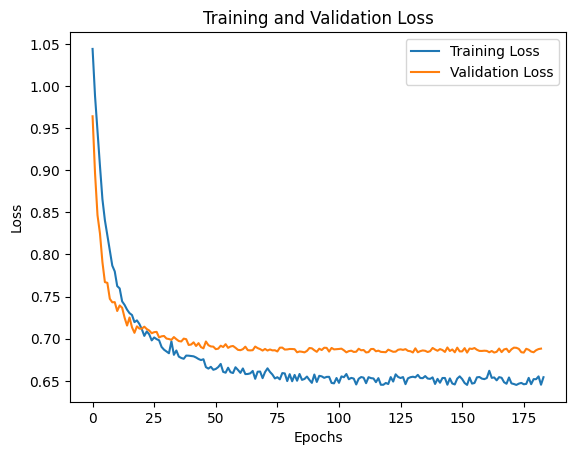

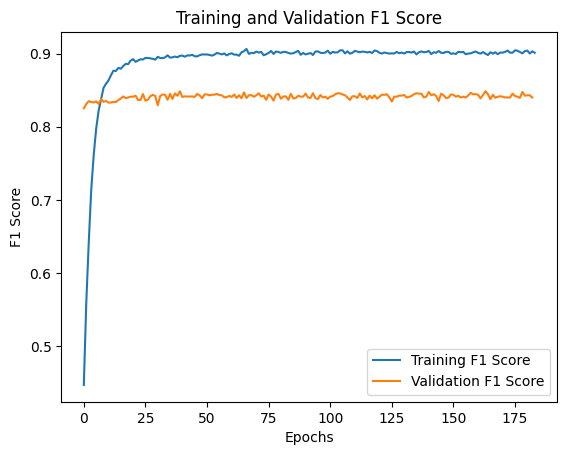

In [45]:
# Initialize MetaClassifier and move to device
feed_forward_NN = FeedForwardNN().to(device)

# HP definition
num_epochs = 200
batch_size = 128
lr = 1e-5
weight_decay = 1e-2
model_path = "FFNN.pth"

# Training loop
train_metaclassifier(feed_forward_NN, batch_size, num_epochs, lr, weight_decay, train_dataset, val_dataset, model_path)

In [46]:
FFNN = FeedForwardNN()
FFNN.load_state_dict(torch.load(model_path))
FFNN = FFNN.to(device)
evaluate_metaclassifier(FFNN, test_dataset)


Test Loss: 0.6585277020931244
Test Macro F1 Score: 0.8784784275841379
Test Weighted F1 Score: [0.89383562 0.90064903 0.84095064]
Test Accuracy: 0.8897256589564282


##### <b>Convolutional NN</b>

Here, I would like to try a Convolutional architecture.</br>The reason behind this choice is the hope that the model could be capable of extracting high-order features concerning the reliability of base models.

Let's try and see!

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_1d(nn.Module):
    def __init__(self):
        super(CNN_1d, self).__init__()

        self.conv1 = nn.Conv1d(1, 16, 3)  # Input tensor has shape [batch_size, 1, 6] after the unsqueeze
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.dropout1 = nn.Dropout(0.5)

        self.conv2 = nn.Conv1d(16, 32, 3)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(32 * 2, 64)
        self.dropout3 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(64, 3)

    def forward(self, x):
        x = x.unsqueeze(1)

        # First Convolutional Layer
        x = F.gelu(self.conv1(x))
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        # Second Convolutional Layer
        x = F.gelu(self.conv2(x))
        x = self.batch_norm2(x)
        x = self.dropout2(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # FCLayers
        x = F.selu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)

        return F.softmax(x, dim=1)

Epoch 0: 100%|██████████| 33/33 [00:01<00:00, 32.09it/s, training_loss=0.586]



Training Loss at end of epoch 0: 1.1190601804039695
Training F1 Score at end of epoch 0: 0.2897758590200397
New best model saved with validation loss: 1.1131865829229355

Validation Loss at end of epoch 0: 1.1131865829229355
Validation Macro F1 Score at end of epoch 0: 0.14517506404782238
Validation Weighted F1 Score at end of epoch 0: [0.43552519 0.         0.        ]


Epoch 1: 100%|██████████| 33/33 [00:00<00:00, 145.26it/s, training_loss=0.627]



Training Loss at end of epoch 1: 1.1145223704251377
Training F1 Score at end of epoch 1: 0.30537283423560646
New best model saved with validation loss: 1.0885559022426605

Validation Loss at end of epoch 1: 1.0885559022426605
Validation Macro F1 Score at end of epoch 1: 0.15194227994227996
Validation Weighted F1 Score at end of epoch 1: [0.43982684 0.         0.016     ]


Epoch 2: 100%|██████████| 33/33 [00:00<00:00, 148.82it/s, training_loss=0.469]



Training Loss at end of epoch 2: 1.0966901688864736
Training F1 Score at end of epoch 2: 0.3263410188876396
New best model saved with validation loss: 1.0762978345155716

Validation Loss at end of epoch 2: 1.0762978345155716
Validation Macro F1 Score at end of epoch 2: 0.23346644391060858
Validation Weighted F1 Score at end of epoch 2: [0.46709917 0.0066335  0.22666667]


Epoch 3: 100%|██████████| 33/33 [00:00<00:00, 145.35it/s, training_loss=0.550]



Training Loss at end of epoch 3: 1.0924901239799731
Training F1 Score at end of epoch 3: 0.3465586227074469
New best model saved with validation loss: 1.0681208372116089

Validation Loss at end of epoch 3: 1.0681208372116089
Validation Macro F1 Score at end of epoch 3: 0.41197102535891905
Validation Weighted F1 Score at end of epoch 3: [0.46927374 0.00738007 0.75925926]


Epoch 4: 100%|██████████| 33/33 [00:00<00:00, 148.66it/s, training_loss=0.550]



Training Loss at end of epoch 4: 1.084484248450308
Training F1 Score at end of epoch 4: 0.3643501486515633
New best model saved with validation loss: 1.0504087507724762

Validation Loss at end of epoch 4: 1.0504087507724762
Validation Macro F1 Score at end of epoch 4: 0.6029104612450246
Validation Weighted F1 Score at end of epoch 4: [0.5505618  0.47988904 0.77828054]


Epoch 5: 100%|██████████| 33/33 [00:00<00:00, 148.29it/s, training_loss=0.479]



Training Loss at end of epoch 5: 1.071547511852149
Training F1 Score at end of epoch 5: 0.3795693278071919
New best model saved with validation loss: 1.046455055475235

Validation Loss at end of epoch 5: 1.046455055475235
Validation Macro F1 Score at end of epoch 5: 0.6426859134953974
Validation Weighted F1 Score at end of epoch 5: [0.58194774 0.56584094 0.78026906]


Epoch 6: 100%|██████████| 33/33 [00:00<00:00, 147.80it/s, training_loss=0.529]



Training Loss at end of epoch 6: 1.0637431831070872
Training F1 Score at end of epoch 6: 0.406420831762589
New best model saved with validation loss: 1.0339697301387787

Validation Loss at end of epoch 6: 1.0339697301387787
Validation Macro F1 Score at end of epoch 6: 0.7977209941571625
Validation Weighted F1 Score at end of epoch 6: [0.74342105 0.84104628 0.80869565]


Epoch 7: 100%|██████████| 33/33 [00:00<00:00, 135.02it/s, training_loss=0.496]



Training Loss at end of epoch 7: 1.053847206361366
Training F1 Score at end of epoch 7: 0.4249385648480575
New best model saved with validation loss: 1.0186672061681747

Validation Loss at end of epoch 7: 1.0186672061681747
Validation Macro F1 Score at end of epoch 7: 0.8187010924522476
Validation Weighted F1 Score at end of epoch 7: [0.77642981 0.86744639 0.81222707]


Epoch 8: 100%|██████████| 33/33 [00:00<00:00, 146.71it/s, training_loss=0.440]



Training Loss at end of epoch 8: 1.0390897790590923
Training F1 Score at end of epoch 8: 0.4454005108383094
New best model saved with validation loss: 1.0114121735095978

Validation Loss at end of epoch 8: 1.0114121735095978
Validation Macro F1 Score at end of epoch 8: 0.8171030284246279
Validation Weighted F1 Score at end of epoch 8: [0.7804878  0.86905917 0.80176211]


Epoch 9: 100%|██████████| 33/33 [00:00<00:00, 148.97it/s, training_loss=0.578]



Training Loss at end of epoch 9: 1.0458937486012776
Training F1 Score at end of epoch 9: 0.44646237936718497
New best model saved with validation loss: 0.9964527115225792

Validation Loss at end of epoch 9: 0.9964527115225792
Validation Macro F1 Score at end of epoch 9: 0.8204294706649256
Validation Weighted F1 Score at end of epoch 9: [0.78787879 0.87164751 0.80176211]


Epoch 10: 100%|██████████| 33/33 [00:00<00:00, 148.53it/s, training_loss=0.495]



Training Loss at end of epoch 10: 1.0276693900426228
Training F1 Score at end of epoch 10: 0.4844806126741395
New best model saved with validation loss: 0.9887753650546074

Validation Loss at end of epoch 10: 0.9887753650546074
Validation Macro F1 Score at end of epoch 10: 0.830188578341895
Validation Weighted F1 Score at end of epoch 10: [0.80073801 0.88113208 0.80869565]


Epoch 11: 100%|██████████| 33/33 [00:00<00:00, 145.40it/s, training_loss=0.516]



Training Loss at end of epoch 11: 1.019704023996989
Training F1 Score at end of epoch 11: 0.4935939620057508
New best model saved with validation loss: 0.9770580604672432

Validation Loss at end of epoch 11: 0.9770580604672432
Validation Macro F1 Score at end of epoch 11: 0.8313870697888457
Validation Weighted F1 Score at end of epoch 11: [0.80754717 0.88141923 0.80519481]


Epoch 12: 100%|██████████| 33/33 [00:00<00:00, 148.09it/s, training_loss=0.470]



Training Loss at end of epoch 12: 1.0121122779268208
Training F1 Score at end of epoch 12: 0.506531339462663
New best model saved with validation loss: 0.9709666520357132

Validation Loss at end of epoch 12: 0.9709666520357132
Validation Macro F1 Score at end of epoch 12: 0.83723467091107
Validation Weighted F1 Score at end of epoch 12: [0.81765835 0.88207985 0.81196581]


Epoch 13: 100%|██████████| 33/33 [00:00<00:00, 148.09it/s, training_loss=0.549]



Training Loss at end of epoch 13: 1.0078826528606992
Training F1 Score at end of epoch 13: 0.5294511131402516
New best model saved with validation loss: 0.9556321352720261

Validation Loss at end of epoch 13: 0.9556321352720261
Validation Macro F1 Score at end of epoch 13: 0.8370574268402303
Validation Weighted F1 Score at end of epoch 13: [0.81624758 0.88457987 0.81034483]


Epoch 14: 100%|██████████| 33/33 [00:00<00:00, 148.41it/s, training_loss=0.467]



Training Loss at end of epoch 14: 0.9908180634180704
Training F1 Score at end of epoch 14: 0.5525035590459565
New best model saved with validation loss: 0.9441953077912331

Validation Loss at end of epoch 14: 0.9441953077912331
Validation Macro F1 Score at end of epoch 14: 0.8374244742425829
Validation Weighted F1 Score at end of epoch 14: [0.81941748 0.88766114 0.80519481]


Epoch 15: 100%|██████████| 33/33 [00:00<00:00, 135.50it/s, training_loss=0.536]



Training Loss at end of epoch 15: 0.991346456787803
Training F1 Score at end of epoch 15: 0.5619913411140084
New best model saved with validation loss: 0.9334332719445229

Validation Loss at end of epoch 15: 0.9334332719445229
Validation Macro F1 Score at end of epoch 15: 0.8363866513272833
Validation Weighted F1 Score at end of epoch 15: [0.81712062 0.88684453 0.80519481]


Epoch 16: 100%|██████████| 33/33 [00:00<00:00, 142.59it/s, training_loss=0.440]



Training Loss at end of epoch 16: 0.978611555966464
Training F1 Score at end of epoch 16: 0.5739531632722756
New best model saved with validation loss: 0.931997038424015

Validation Loss at end of epoch 16: 0.931997038424015
Validation Macro F1 Score at end of epoch 16: 0.8432976693809359
Validation Weighted F1 Score at end of epoch 16: [0.83266932 0.89213894 0.80508475]


Epoch 17: 100%|██████████| 33/33 [00:00<00:00, 141.16it/s, training_loss=0.398]



Training Loss at end of epoch 17: 0.968371261249889
Training F1 Score at end of epoch 17: 0.5887930253056401
New best model saved with validation loss: 0.9201304316520691

Validation Loss at end of epoch 17: 0.9201304316520691
Validation Macro F1 Score at end of epoch 17: 0.8419759214556587
Validation Weighted F1 Score at end of epoch 17: [0.82445759 0.89112534 0.81034483]


Epoch 18: 100%|██████████| 33/33 [00:00<00:00, 144.89it/s, training_loss=0.523]



Training Loss at end of epoch 18: 0.9634454105839585
Training F1 Score at end of epoch 18: 0.613504569878132
New best model saved with validation loss: 0.9080400466918945

Validation Loss at end of epoch 18: 0.9080400466918945
Validation Macro F1 Score at end of epoch 18: 0.8431586400588521
Validation Weighted F1 Score at end of epoch 18: [0.83003953 0.89092576 0.80851064]


Epoch 19: 100%|██████████| 33/33 [00:00<00:00, 140.41it/s, training_loss=0.665]



Training Loss at end of epoch 19: 0.9685067769252893
Training F1 Score at end of epoch 19: 0.6182849559223553
New best model saved with validation loss: 0.9009564593434334

Validation Loss at end of epoch 19: 0.9009564593434334
Validation Macro F1 Score at end of epoch 19: 0.8441889226731893
Validation Weighted F1 Score at end of epoch 19: [0.83433134 0.89315068 0.80508475]


Epoch 20: 100%|██████████| 33/33 [00:00<00:00, 135.66it/s, training_loss=0.517]



Training Loss at end of epoch 20: 0.9530242916309473
Training F1 Score at end of epoch 20: 0.6292230854950639
New best model saved with validation loss: 0.8874340876936913

Validation Loss at end of epoch 20: 0.8874340876936913
Validation Macro F1 Score at end of epoch 20: 0.8453768044661043
Validation Weighted F1 Score at end of epoch 20: [0.83101392 0.89315068 0.81196581]


Epoch 21: 100%|██████████| 33/33 [00:00<00:00, 142.00it/s, training_loss=0.387]



Training Loss at end of epoch 21: 0.9363596132307341
Training F1 Score at end of epoch 21: 0.648839021091033
New best model saved with validation loss: 0.879602275788784

Validation Loss at end of epoch 21: 0.879602275788784
Validation Macro F1 Score at end of epoch 21: 0.844032522708587
Validation Weighted F1 Score at end of epoch 21: [0.83366733 0.89334549 0.80508475]


Epoch 22: 100%|██████████| 33/33 [00:00<00:00, 141.53it/s, training_loss=0.458]



Training Loss at end of epoch 22: 0.9321713718501005
Training F1 Score at end of epoch 22: 0.6635779312558269
New best model saved with validation loss: 0.8738553449511528

Validation Loss at end of epoch 22: 0.8738553449511528
Validation Macro F1 Score at end of epoch 22: 0.8447768819795142
Validation Weighted F1 Score at end of epoch 22: [0.83266932 0.89315068 0.80851064]


Epoch 23: 100%|██████████| 33/33 [00:00<00:00, 146.63it/s, training_loss=0.463]



Training Loss at end of epoch 23: 0.923386705644203
Training F1 Score at end of epoch 23: 0.6899149880184582
New best model saved with validation loss: 0.8667163848876953

Validation Loss at end of epoch 23: 0.8667163848876953
Validation Macro F1 Score at end of epoch 23: 0.8452154866657211
Validation Weighted F1 Score at end of epoch 23: [0.83702213 0.89353958 0.80508475]


Epoch 24: 100%|██████████| 33/33 [00:00<00:00, 148.38it/s, training_loss=0.444]



Training Loss at end of epoch 24: 0.9174104116179727
Training F1 Score at end of epoch 24: 0.6807241543576962
New best model saved with validation loss: 0.856110468506813

Validation Loss at end of epoch 24: 0.856110468506813
Validation Macro F1 Score at end of epoch 24: 0.8444231941184185
Validation Weighted F1 Score at end of epoch 24: [0.831643   0.89311594 0.80851064]


Epoch 25: 100%|██████████| 33/33 [00:00<00:00, 147.75it/s, training_loss=0.406]



Training Loss at end of epoch 25: 0.9115976853804155
Training F1 Score at end of epoch 25: 0.6865751180715458
New best model saved with validation loss: 0.8499750867486

Validation Loss at end of epoch 25: 0.8499750867486
Validation Macro F1 Score at end of epoch 25: 0.8456403425599864
Validation Weighted F1 Score at end of epoch 25: [0.83467742 0.89373297 0.80851064]


Epoch 26: 100%|██████████| 33/33 [00:00<00:00, 139.32it/s, training_loss=0.480]



Training Loss at end of epoch 26: 0.9113293001146028
Training F1 Score at end of epoch 26: 0.6950458169591944
New best model saved with validation loss: 0.8433820381760597

Validation Loss at end of epoch 26: 0.8433820381760597
Validation Macro F1 Score at end of epoch 26: 0.8425925468305678
Validation Weighted F1 Score at end of epoch 26: [0.82857143 0.89069557 0.80851064]


Epoch 27: 100%|██████████| 33/33 [00:00<00:00, 147.85it/s, training_loss=0.569]



Training Loss at end of epoch 27: 0.9060743017630144
Training F1 Score at end of epoch 27: 0.7137223214883562
New best model saved with validation loss: 0.8330920860171318

Validation Loss at end of epoch 27: 0.8330920860171318
Validation Macro F1 Score at end of epoch 27: 0.8401041861681984
Validation Weighted F1 Score at end of epoch 27: [0.82231405 0.88948787 0.80851064]


Epoch 28: 100%|██████████| 33/33 [00:00<00:00, 143.03it/s, training_loss=0.414]



Training Loss at end of epoch 28: 0.8905693617734042
Training F1 Score at end of epoch 28: 0.7278616505377816

Validation Loss at end of epoch 28: 0.8360435217618942
Validation Macro F1 Score at end of epoch 28: 0.8440779971465892
Validation Weighted F1 Score at end of epoch 28: [0.82857143 0.89169675 0.81196581]


Epoch 29: 100%|██████████| 33/33 [00:00<00:00, 149.21it/s, training_loss=0.401]



Training Loss at end of epoch 29: 0.8827778371897611
Training F1 Score at end of epoch 29: 0.7299177988600064
New best model saved with validation loss: 0.8219786211848259

Validation Loss at end of epoch 29: 0.8219786211848259
Validation Macro F1 Score at end of epoch 29: 0.8425925468305678
Validation Weighted F1 Score at end of epoch 29: [0.82857143 0.89069557 0.80851064]


Epoch 30: 100%|██████████| 33/33 [00:00<00:00, 145.94it/s, training_loss=0.573]



Training Loss at end of epoch 30: 0.887009449077375
Training F1 Score at end of epoch 30: 0.7507407123146818
New best model saved with validation loss: 0.8094919621944427

Validation Loss at end of epoch 30: 0.8094919621944427
Validation Macro F1 Score at end of epoch 30: 0.8425925468305678
Validation Weighted F1 Score at end of epoch 30: [0.82857143 0.89069557 0.80851064]


Epoch 31: 100%|██████████| 33/33 [00:00<00:00, 147.44it/s, training_loss=0.408]



Training Loss at end of epoch 31: 0.8667222875537295
Training F1 Score at end of epoch 31: 0.7569143199603209
New best model saved with validation loss: 0.807970255613327

Validation Loss at end of epoch 31: 0.807970255613327
Validation Macro F1 Score at end of epoch 31: 0.8433622077628306
Validation Weighted F1 Score at end of epoch 31: [0.82926829 0.89230769 0.80851064]


Epoch 32: 100%|██████████| 33/33 [00:00<00:00, 147.08it/s, training_loss=0.682]



Training Loss at end of epoch 32: 0.8809417269446633
Training F1 Score at end of epoch 32: 0.7578038262144794
New best model saved with validation loss: 0.802498072385788

Validation Loss at end of epoch 32: 0.802498072385788
Validation Macro F1 Score at end of epoch 32: 0.8417114173604774
Validation Weighted F1 Score at end of epoch 32: [0.82328482 0.88988362 0.81196581]


Epoch 33: 100%|██████████| 33/33 [00:00<00:00, 146.83it/s, training_loss=0.350]



Training Loss at end of epoch 33: 0.8531577532941644
Training F1 Score at end of epoch 33: 0.7678289464440468
New best model saved with validation loss: 0.7985649779438972

Validation Loss at end of epoch 33: 0.7985649779438972
Validation Macro F1 Score at end of epoch 33: 0.8422534136786414
Validation Weighted F1 Score at end of epoch 33: [0.82716049 0.89108911 0.80851064]


Epoch 34: 100%|██████████| 33/33 [00:00<00:00, 142.84it/s, training_loss=0.436]



Training Loss at end of epoch 34: 0.85834196842078
Training F1 Score at end of epoch 34: 0.7700819703889289

Validation Loss at end of epoch 34: 0.798630528151989
Validation Macro F1 Score at end of epoch 34: 0.8433622077628306
Validation Weighted F1 Score at end of epoch 34: [0.82926829 0.89230769 0.80851064]


Epoch 35: 100%|██████████| 33/33 [00:00<00:00, 144.24it/s, training_loss=0.437]



Training Loss at end of epoch 35: 0.848584482164094
Training F1 Score at end of epoch 35: 0.7760159588371002
New best model saved with validation loss: 0.786722756922245

Validation Loss at end of epoch 35: 0.786722756922245
Validation Macro F1 Score at end of epoch 35: 0.8436942555116235
Validation Weighted F1 Score at end of epoch 35: [0.82744283 0.89167413 0.81196581]


Epoch 36: 100%|██████████| 33/33 [00:00<00:00, 142.26it/s, training_loss=0.424]



Training Loss at end of epoch 36: 0.8424795450586261
Training F1 Score at end of epoch 36: 0.792741957053413
New best model saved with validation loss: 0.786048524081707

Validation Loss at end of epoch 36: 0.786048524081707
Validation Macro F1 Score at end of epoch 36: 0.8453603706509581
Validation Weighted F1 Score at end of epoch 36: [0.82815735 0.89247312 0.81545064]


Epoch 37: 100%|██████████| 33/33 [00:00<00:00, 147.53it/s, training_loss=0.324]



Training Loss at end of epoch 37: 0.8340425184278777
Training F1 Score at end of epoch 37: 0.7888530457631621
New best model saved with validation loss: 0.7830314412713051

Validation Loss at end of epoch 37: 0.7830314412713051
Validation Macro F1 Score at end of epoch 37: 0.8436942555116235
Validation Weighted F1 Score at end of epoch 37: [0.82744283 0.89167413 0.81196581]


Epoch 38: 100%|██████████| 33/33 [00:00<00:00, 141.51it/s, training_loss=0.403]



Training Loss at end of epoch 38: 0.8333104126381151
Training F1 Score at end of epoch 38: 0.7924652928177482
New best model saved with validation loss: 0.7753269076347351

Validation Loss at end of epoch 38: 0.7753269076347351
Validation Macro F1 Score at end of epoch 38: 0.8422534136786414
Validation Weighted F1 Score at end of epoch 38: [0.82716049 0.89108911 0.80851064]


Epoch 39: 100%|██████████| 33/33 [00:00<00:00, 137.77it/s, training_loss=0.464]



Training Loss at end of epoch 39: 0.8303168903697621
Training F1 Score at end of epoch 39: 0.7952819620866443
New best model saved with validation loss: 0.7680138275027275

Validation Loss at end of epoch 39: 0.7680138275027275
Validation Macro F1 Score at end of epoch 39: 0.8435186297410434
Validation Weighted F1 Score at end of epoch 39: [0.82672234 0.89186774 0.81196581]


Epoch 40: 100%|██████████| 33/33 [00:00<00:00, 138.69it/s, training_loss=0.501]



Training Loss at end of epoch 40: 0.8269039157665137
Training F1 Score at end of epoch 40: 0.8118908848905496
New best model saved with validation loss: 0.7674276828765869

Validation Loss at end of epoch 40: 0.7674276828765869
Validation Macro F1 Score at end of epoch 40: 0.8407721962890724
Validation Weighted F1 Score at end of epoch 40: [0.82352941 0.89027654 0.80851064]


Epoch 41: 100%|██████████| 33/33 [00:00<00:00, 142.83it/s, training_loss=0.449]



Training Loss at end of epoch 41: 0.8219057700850747
Training F1 Score at end of epoch 41: 0.8158422116051777
New best model saved with validation loss: 0.7656745538115501

Validation Loss at end of epoch 41: 0.7656745538115501
Validation Macro F1 Score at end of epoch 41: 0.8435640549236109
Validation Weighted F1 Score at end of epoch 41: [0.82644628 0.89228007 0.81196581]


Epoch 42: 100%|██████████| 33/33 [00:00<00:00, 146.62it/s, training_loss=0.520]



Training Loss at end of epoch 42: 0.8218416788361289
Training F1 Score at end of epoch 42: 0.8107275210197242
New best model saved with validation loss: 0.7590354755520821

Validation Loss at end of epoch 42: 0.7590354755520821
Validation Macro F1 Score at end of epoch 42: 0.843160621298129
Validation Weighted F1 Score at end of epoch 42: [0.82526316 0.89225289 0.81196581]


Epoch 43: 100%|██████████| 33/33 [00:00<00:00, 139.07it/s, training_loss=0.494]



Training Loss at end of epoch 43: 0.8110531333721045
Training F1 Score at end of epoch 43: 0.8227153901162528
New best model saved with validation loss: 0.7514057084918022

Validation Loss at end of epoch 43: 0.7514057084918022
Validation Macro F1 Score at end of epoch 43: 0.844599317564434
Validation Weighted F1 Score at end of epoch 43: [0.82916667 0.89266547 0.81196581]


Epoch 44: 100%|██████████| 33/33 [00:00<00:00, 147.20it/s, training_loss=0.378]



Training Loss at end of epoch 44: 0.8029293869480942
Training F1 Score at end of epoch 44: 0.8207155079364236
New best model saved with validation loss: 0.750736728310585

Validation Loss at end of epoch 44: 0.750736728310585
Validation Macro F1 Score at end of epoch 44: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 44: [0.82352941 0.8912656  0.81196581]


Epoch 45: 100%|██████████| 33/33 [00:00<00:00, 145.87it/s, training_loss=0.450]



Training Loss at end of epoch 45: 0.8013710885336904
Training F1 Score at end of epoch 45: 0.8222809217251627
New best model saved with validation loss: 0.7499978467822075

Validation Loss at end of epoch 45: 0.7499978467822075
Validation Macro F1 Score at end of epoch 45: 0.8420698989418302
Validation Weighted F1 Score at end of epoch 45: [0.82278481 0.89145907 0.81196581]


Epoch 46: 100%|██████████| 33/33 [00:00<00:00, 147.73it/s, training_loss=0.370]



Training Loss at end of epoch 46: 0.7928170110240127
Training F1 Score at end of epoch 46: 0.8309310492804768
New best model saved with validation loss: 0.7487005069851875

Validation Loss at end of epoch 46: 0.7487005069851875
Validation Macro F1 Score at end of epoch 46: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 46: [0.82352941 0.8912656  0.81196581]


Epoch 47: 100%|██████████| 33/33 [00:00<00:00, 142.41it/s, training_loss=0.513]



Training Loss at end of epoch 47: 0.7998766537868616
Training F1 Score at end of epoch 47: 0.8316979662275861
New best model saved with validation loss: 0.742096945643425

Validation Loss at end of epoch 47: 0.742096945643425
Validation Macro F1 Score at end of epoch 47: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 47: [0.82352941 0.8912656  0.81196581]


Epoch 48: 100%|██████████| 33/33 [00:00<00:00, 148.44it/s, training_loss=0.361]



Training Loss at end of epoch 48: 0.7858629208622556
Training F1 Score at end of epoch 48: 0.8297131661055599
New best model saved with validation loss: 0.7403002977371216

Validation Loss at end of epoch 48: 0.7403002977371216
Validation Macro F1 Score at end of epoch 48: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 48: [0.82352941 0.8912656  0.81196581]


Epoch 49: 100%|██████████| 33/33 [00:00<00:00, 142.32it/s, training_loss=0.403]



Training Loss at end of epoch 49: 0.7843873735630151
Training F1 Score at end of epoch 49: 0.8379933670973623

Validation Loss at end of epoch 49: 0.7406665533781052
Validation Macro F1 Score at end of epoch 49: 0.843160621298129
Validation Weighted F1 Score at end of epoch 49: [0.82526316 0.89225289 0.81196581]


Epoch 50: 100%|██████████| 33/33 [00:00<00:00, 144.16it/s, training_loss=0.386]



Training Loss at end of epoch 50: 0.7793173988660177
Training F1 Score at end of epoch 50: 0.8398113054710824
New best model saved with validation loss: 0.7365996688604355

Validation Loss at end of epoch 50: 0.7365996688604355
Validation Macro F1 Score at end of epoch 50: 0.8446507452784205
Validation Weighted F1 Score at end of epoch 50: [0.82526316 0.89323843 0.81545064]


Epoch 51: 100%|██████████| 33/33 [00:00<00:00, 147.79it/s, training_loss=0.460]



Training Loss at end of epoch 51: 0.7828174377932693
Training F1 Score at end of epoch 51: 0.8384318733356394
New best model saved with validation loss: 0.7352422773838043

Validation Loss at end of epoch 51: 0.7352422773838043
Validation Macro F1 Score at end of epoch 51: 0.8446507452784205
Validation Weighted F1 Score at end of epoch 51: [0.82526316 0.89323843 0.81545064]


Epoch 52: 100%|██████████| 33/33 [00:00<00:00, 150.27it/s, training_loss=0.493]



Training Loss at end of epoch 52: 0.7801393649794839
Training F1 Score at end of epoch 52: 0.8462385596492162
New best model saved with validation loss: 0.7323344796895981

Validation Loss at end of epoch 52: 0.7323344796895981
Validation Macro F1 Score at end of epoch 52: 0.8435186297410434
Validation Weighted F1 Score at end of epoch 52: [0.82672234 0.89186774 0.81196581]


Epoch 53: 100%|██████████| 33/33 [00:00<00:00, 141.52it/s, training_loss=0.352]



Training Loss at end of epoch 53: 0.7686434568780841
Training F1 Score at end of epoch 53: 0.8486589928939364

Validation Loss at end of epoch 53: 0.7342166677117348
Validation Macro F1 Score at end of epoch 53: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 53: [0.82352941 0.8912656  0.81196581]


Epoch 54: 100%|██████████| 33/33 [00:00<00:00, 145.92it/s, training_loss=0.300]



Training Loss at end of epoch 54: 0.7622661879568389
Training F1 Score at end of epoch 54: 0.8477748212239922
New best model saved with validation loss: 0.7310207635164261

Validation Loss at end of epoch 54: 0.7310207635164261
Validation Macro F1 Score at end of epoch 54: 0.843160621298129
Validation Weighted F1 Score at end of epoch 54: [0.82526316 0.89225289 0.81196581]


Epoch 55: 100%|██████████| 33/33 [00:00<00:00, 138.77it/s, training_loss=0.300]



Training Loss at end of epoch 55: 0.7579095977725405
Training F1 Score at end of epoch 55: 0.8542233463226981
New best model saved with validation loss: 0.7299411222338676

Validation Loss at end of epoch 55: 0.7299411222338676
Validation Macro F1 Score at end of epoch 55: 0.844599317564434
Validation Weighted F1 Score at end of epoch 55: [0.82916667 0.89266547 0.81196581]


Epoch 56: 100%|██████████| 33/33 [00:00<00:00, 145.60it/s, training_loss=0.329]



Training Loss at end of epoch 56: 0.7611033735853253
Training F1 Score at end of epoch 56: 0.8453549223202822
New best model saved with validation loss: 0.7279787808656693

Validation Loss at end of epoch 56: 0.7279787808656693
Validation Macro F1 Score at end of epoch 56: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 56: [0.82352941 0.8912656  0.81196581]


Epoch 57: 100%|██████████| 33/33 [00:00<00:00, 139.16it/s, training_loss=0.400]



Training Loss at end of epoch 57: 0.7621697476415923
Training F1 Score at end of epoch 57: 0.8514645425110747
New best model saved with validation loss: 0.7263333350419998

Validation Loss at end of epoch 57: 0.7263333350419998
Validation Macro F1 Score at end of epoch 57: 0.843160621298129
Validation Weighted F1 Score at end of epoch 57: [0.82526316 0.89225289 0.81196581]


Epoch 58: 100%|██████████| 33/33 [00:00<00:00, 147.36it/s, training_loss=0.416]



Training Loss at end of epoch 58: 0.7601869810711254
Training F1 Score at end of epoch 58: 0.8511841735098886
New best model saved with validation loss: 0.7224080413579941

Validation Loss at end of epoch 58: 0.7224080413579941
Validation Macro F1 Score at end of epoch 58: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 58: [0.82352941 0.8912656  0.81196581]


Epoch 59: 100%|██████████| 33/33 [00:00<00:00, 65.35it/s, training_loss=0.311]



Training Loss at end of epoch 59: 0.7512107690175375
Training F1 Score at end of epoch 59: 0.8526693934168543
New best model saved with validation loss: 0.721370056271553

Validation Loss at end of epoch 59: 0.721370056271553
Validation Macro F1 Score at end of epoch 59: 0.8437443165251226
Validation Weighted F1 Score at end of epoch 59: [0.82352941 0.89225289 0.81545064]


Epoch 60: 100%|██████████| 33/33 [00:00<00:00, 132.27it/s, training_loss=0.309]



Training Loss at end of epoch 60: 0.7464443318771593
Training F1 Score at end of epoch 60: 0.860800349342016

Validation Loss at end of epoch 60: 0.7219275012612343
Validation Macro F1 Score at end of epoch 60: 0.8443404487618998
Validation Weighted F1 Score at end of epoch 60: [0.82180294 0.89225289 0.81896552]


Epoch 61: 100%|██████████| 33/33 [00:00<00:00, 140.74it/s, training_loss=0.500]



Training Loss at end of epoch 61: 0.7556902441111478
Training F1 Score at end of epoch 61: 0.8561564646560179
New best model saved with validation loss: 0.7161136418581009

Validation Loss at end of epoch 61: 0.7161136418581009
Validation Macro F1 Score at end of epoch 61: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 61: [0.82352941 0.8912656  0.81196581]


Epoch 62: 100%|██████████| 33/33 [00:00<00:00, 146.00it/s, training_loss=0.331]



Training Loss at end of epoch 62: 0.741384997512355
Training F1 Score at end of epoch 62: 0.8591195795899312

Validation Loss at end of epoch 62: 0.7176608368754387
Validation Macro F1 Score at end of epoch 62: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 62: [0.82352941 0.8912656  0.81196581]


Epoch 63: 100%|██████████| 33/33 [00:00<00:00, 134.94it/s, training_loss=0.382]



Training Loss at end of epoch 63: 0.7448040102467393
Training F1 Score at end of epoch 63: 0.8627022235812705
New best model saved with validation loss: 0.7142705991864204

Validation Loss at end of epoch 63: 0.7142705991864204
Validation Macro F1 Score at end of epoch 63: 0.8424661639574619
Validation Weighted F1 Score at end of epoch 63: [0.82029598 0.89165187 0.81545064]


Epoch 64: 100%|██████████| 33/33 [00:00<00:00, 136.58it/s, training_loss=0.487]



Training Loss at end of epoch 64: 0.7475964806296609
Training F1 Score at end of epoch 64: 0.8648393707777843
New best model saved with validation loss: 0.7134232893586159

Validation Loss at end of epoch 64: 0.7134232893586159
Validation Macro F1 Score at end of epoch 64: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 64: [0.82352941 0.8912656  0.81196581]


Epoch 65: 100%|██████████| 33/33 [00:00<00:00, 143.54it/s, training_loss=0.328]



Training Loss at end of epoch 65: 0.7349548303719723
Training F1 Score at end of epoch 65: 0.8650525068809699
New best model saved with validation loss: 0.7119406536221504

Validation Loss at end of epoch 65: 0.7119406536221504
Validation Macro F1 Score at end of epoch 65: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 65: [0.82352941 0.8912656  0.81196581]


Epoch 66: 100%|██████████| 33/33 [00:00<00:00, 141.52it/s, training_loss=0.302]



Training Loss at end of epoch 66: 0.7313918543584419
Training F1 Score at end of epoch 66: 0.8661262104317969

Validation Loss at end of epoch 66: 0.7124120816588402
Validation Macro F1 Score at end of epoch 66: 0.843160621298129
Validation Weighted F1 Score at end of epoch 66: [0.82526316 0.89225289 0.81196581]


Epoch 67: 100%|██████████| 33/33 [00:00<00:00, 143.28it/s, training_loss=0.302]



Training Loss at end of epoch 67: 0.7322523322972384
Training F1 Score at end of epoch 67: 0.8590160601185177
New best model saved with validation loss: 0.708945520222187

Validation Loss at end of epoch 67: 0.708945520222187
Validation Macro F1 Score at end of epoch 67: 0.8433407597395277
Validation Weighted F1 Score at end of epoch 67: [0.82599581 0.89206066 0.81196581]


Epoch 68: 100%|██████████| 33/33 [00:00<00:00, 139.42it/s, training_loss=0.419]



Training Loss at end of epoch 68: 0.7372889211683562
Training F1 Score at end of epoch 68: 0.862100705790194
New best model saved with validation loss: 0.7079551815986633

Validation Loss at end of epoch 68: 0.7079551815986633
Validation Macro F1 Score at end of epoch 68: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 68: [0.82352941 0.8912656  0.81196581]


Epoch 69: 100%|██████████| 33/33 [00:00<00:00, 141.86it/s, training_loss=0.307]



Training Loss at end of epoch 69: 0.7272844639691439
Training F1 Score at end of epoch 69: 0.8704202307216159

Validation Loss at end of epoch 69: 0.7095760032534599
Validation Macro F1 Score at end of epoch 69: 0.8437443165251226
Validation Weighted F1 Score at end of epoch 69: [0.82352941 0.89225289 0.81545064]


Epoch 70: 100%|██████████| 33/33 [00:00<00:00, 138.03it/s, training_loss=0.369]



Training Loss at end of epoch 70: 0.7308094086069049
Training F1 Score at end of epoch 70: 0.8655775427420239
New best model saved with validation loss: 0.7077868580818176

Validation Loss at end of epoch 70: 0.7077868580818176
Validation Macro F1 Score at end of epoch 70: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 70: [0.82352941 0.8912656  0.81196581]


Epoch 71: 100%|██████████| 33/33 [00:00<00:00, 136.28it/s, training_loss=0.427]



Training Loss at end of epoch 71: 0.7330160321611346
Training F1 Score at end of epoch 71: 0.8662939113888554
New best model saved with validation loss: 0.707270972430706

Validation Loss at end of epoch 71: 0.707270972430706
Validation Macro F1 Score at end of epoch 71: 0.8433407597395277
Validation Weighted F1 Score at end of epoch 71: [0.82599581 0.89206066 0.81196581]


Epoch 72: 100%|██████████| 33/33 [00:00<00:00, 143.74it/s, training_loss=0.403]



Training Loss at end of epoch 72: 0.7268479069073995
Training F1 Score at end of epoch 72: 0.8683565051165703
New best model saved with validation loss: 0.706309013068676

Validation Loss at end of epoch 72: 0.706309013068676
Validation Macro F1 Score at end of epoch 72: 0.8424661639574619
Validation Weighted F1 Score at end of epoch 72: [0.82029598 0.89165187 0.81545064]


Epoch 73: 100%|██████████| 33/33 [00:00<00:00, 147.09it/s, training_loss=0.501]



Training Loss at end of epoch 73: 0.7310108831434539
Training F1 Score at end of epoch 73: 0.8693358046450635
New best model saved with validation loss: 0.705045111477375

Validation Loss at end of epoch 73: 0.705045111477375
Validation Macro F1 Score at end of epoch 73: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 73: [0.82352941 0.8912656  0.81196581]


Epoch 74: 100%|██████████| 33/33 [00:00<00:00, 144.85it/s, training_loss=0.304]



Training Loss at end of epoch 74: 0.7176135236566717
Training F1 Score at end of epoch 74: 0.8706331796020499

Validation Loss at end of epoch 74: 0.7068125233054161
Validation Macro F1 Score at end of epoch 74: 0.8424661639574619
Validation Weighted F1 Score at end of epoch 74: [0.82029598 0.89165187 0.81545064]


Epoch 75: 100%|██████████| 33/33 [00:00<00:00, 144.84it/s, training_loss=0.379]



Training Loss at end of epoch 75: 0.719948643987829
Training F1 Score at end of epoch 75: 0.8741111869437201
New best model saved with validation loss: 0.7036200612783432

Validation Loss at end of epoch 75: 0.7036200612783432
Validation Macro F1 Score at end of epoch 75: 0.8437443165251226
Validation Weighted F1 Score at end of epoch 75: [0.82352941 0.89225289 0.81545064]


Epoch 76: 100%|██████████| 33/33 [00:00<00:00, 144.81it/s, training_loss=0.310]



Training Loss at end of epoch 76: 0.7141549478877675
Training F1 Score at end of epoch 76: 0.8750252466480285

Validation Loss at end of epoch 76: 0.7037596926093102
Validation Macro F1 Score at end of epoch 76: 0.8424661639574619
Validation Weighted F1 Score at end of epoch 76: [0.82029598 0.89165187 0.81545064]


Epoch 77: 100%|██████████| 33/33 [00:00<00:00, 145.14it/s, training_loss=0.591]



Training Loss at end of epoch 77: 0.7309344013532003
Training F1 Score at end of epoch 77: 0.870144591450407
New best model saved with validation loss: 0.7030843272805214

Validation Loss at end of epoch 77: 0.7030843272805214
Validation Macro F1 Score at end of epoch 77: 0.8409761539063864
Validation Weighted F1 Score at end of epoch 77: [0.82029598 0.89066667 0.81196581]


Epoch 78: 100%|██████████| 33/33 [00:00<00:00, 146.68it/s, training_loss=0.292]



Training Loss at end of epoch 78: 0.7112571163610979
Training F1 Score at end of epoch 78: 0.874048975663348

Validation Loss at end of epoch 78: 0.7033083811402321
Validation Macro F1 Score at end of epoch 78: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 78: [0.82352941 0.8912656  0.81196581]


Epoch 79: 100%|██████████| 33/33 [00:00<00:00, 142.96it/s, training_loss=0.333]



Training Loss at end of epoch 79: 0.7119890939105641
Training F1 Score at end of epoch 79: 0.8736474280635403
New best model saved with validation loss: 0.7008699923753738

Validation Loss at end of epoch 79: 0.7008699923753738
Validation Macro F1 Score at end of epoch 79: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 79: [0.82352941 0.8912656  0.81196581]


Epoch 80: 100%|██████████| 33/33 [00:00<00:00, 146.18it/s, training_loss=0.507]



Training Loss at end of epoch 80: 0.7195209644057534
Training F1 Score at end of epoch 80: 0.8735124167281509
New best model saved with validation loss: 0.7003612890839577

Validation Loss at end of epoch 80: 0.7003612890839577
Validation Macro F1 Score at end of epoch 80: 0.8424661639574619
Validation Weighted F1 Score at end of epoch 80: [0.82029598 0.89165187 0.81545064]


Epoch 81: 100%|██████████| 33/33 [00:00<00:00, 147.75it/s, training_loss=0.311]



Training Loss at end of epoch 81: 0.7089057889851657
Training F1 Score at end of epoch 81: 0.8724080975620364
New best model saved with validation loss: 0.6994753479957581

Validation Loss at end of epoch 81: 0.6994753479957581
Validation Macro F1 Score at end of epoch 81: 0.8415609037624575
Validation Weighted F1 Score at end of epoch 81: [0.8185654  0.89066667 0.81545064]


Epoch 82: 100%|██████████| 33/33 [00:00<00:00, 145.94it/s, training_loss=0.306]



Training Loss at end of epoch 82: 0.7074050505956014
Training F1 Score at end of epoch 82: 0.872327742339443

Validation Loss at end of epoch 82: 0.6997373327612877
Validation Macro F1 Score at end of epoch 82: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 82: [0.82352941 0.8912656  0.81196581]


Epoch 83: 100%|██████████| 33/33 [00:00<00:00, 143.04it/s, training_loss=0.319]



Training Loss at end of epoch 83: 0.7061468489242323
Training F1 Score at end of epoch 83: 0.8717387134318796
New best model saved with validation loss: 0.6987039223313332

Validation Loss at end of epoch 83: 0.6987039223313332
Validation Macro F1 Score at end of epoch 83: 0.8437443165251226
Validation Weighted F1 Score at end of epoch 83: [0.82352941 0.89225289 0.81545064]


Epoch 84: 100%|██████████| 33/33 [00:00<00:00, 142.46it/s, training_loss=0.334]



Training Loss at end of epoch 84: 0.7066764470302698
Training F1 Score at end of epoch 84: 0.8754642713089181
New best model saved with validation loss: 0.6983356475830078

Validation Loss at end of epoch 84: 0.6983356475830078
Validation Macro F1 Score at end of epoch 84: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 84: [0.82352941 0.8912656  0.81196581]


Epoch 85: 100%|██████████| 33/33 [00:00<00:00, 141.14it/s, training_loss=0.340]



Training Loss at end of epoch 85: 0.7045443563750295
Training F1 Score at end of epoch 85: 0.8755952641429406
New best model saved with validation loss: 0.697405681014061

Validation Loss at end of epoch 85: 0.697405681014061
Validation Macro F1 Score at end of epoch 85: 0.8437443165251226
Validation Weighted F1 Score at end of epoch 85: [0.82352941 0.89225289 0.81545064]


Epoch 86: 100%|██████████| 33/33 [00:00<00:00, 145.01it/s, training_loss=0.373]



Training Loss at end of epoch 86: 0.7057068781419233
Training F1 Score at end of epoch 86: 0.8759215932313915
New best model saved with validation loss: 0.6965750157833099

Validation Loss at end of epoch 86: 0.6965750157833099
Validation Macro F1 Score at end of epoch 86: 0.8437443165251226
Validation Weighted F1 Score at end of epoch 86: [0.82352941 0.89225289 0.81545064]


Epoch 87: 100%|██████████| 33/33 [00:00<00:00, 135.10it/s, training_loss=0.478]



Training Loss at end of epoch 87: 0.7079131946419225
Training F1 Score at end of epoch 87: 0.8791850431605303

Validation Loss at end of epoch 87: 0.6972208321094513
Validation Macro F1 Score at end of epoch 87: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 87: [0.82352941 0.8912656  0.81196581]


Epoch 88: 100%|██████████| 33/33 [00:00<00:00, 145.90it/s, training_loss=0.332]



Training Loss at end of epoch 88: 0.7009140939423533
Training F1 Score at end of epoch 88: 0.8769364808501762

Validation Loss at end of epoch 88: 0.6967360377311707
Validation Macro F1 Score at end of epoch 88: 0.8424661639574619
Validation Weighted F1 Score at end of epoch 88: [0.82029598 0.89165187 0.81545064]


Epoch 89: 100%|██████████| 33/33 [00:00<00:00, 144.43it/s, training_loss=0.283]



Training Loss at end of epoch 89: 0.6957077076940825
Training F1 Score at end of epoch 89: 0.8790099518114064
New best model saved with validation loss: 0.6964154317975044

Validation Loss at end of epoch 89: 0.6964154317975044
Validation Macro F1 Score at end of epoch 89: 0.8424661639574619
Validation Weighted F1 Score at end of epoch 89: [0.82029598 0.89165187 0.81545064]


Epoch 90: 100%|██████████| 33/33 [00:00<00:00, 145.66it/s, training_loss=0.282]



Training Loss at end of epoch 90: 0.6947355956742258
Training F1 Score at end of epoch 90: 0.8788153522706871
New best model saved with validation loss: 0.6953125

Validation Loss at end of epoch 90: 0.6953125
Validation Macro F1 Score at end of epoch 90: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 90: [0.82352941 0.8912656  0.81196581]


Epoch 91: 100%|██████████| 33/33 [00:00<00:00, 139.85it/s, training_loss=0.298]



Training Loss at end of epoch 91: 0.6961695064197887
Training F1 Score at end of epoch 91: 0.878612472389729

Validation Loss at end of epoch 91: 0.6965984329581261
Validation Macro F1 Score at end of epoch 91: 0.8437443165251226
Validation Weighted F1 Score at end of epoch 91: [0.82352941 0.89225289 0.81545064]


Epoch 92: 100%|██████████| 33/33 [00:00<00:00, 144.60it/s, training_loss=0.568]



Training Loss at end of epoch 92: 0.7102884090307987
Training F1 Score at end of epoch 92: 0.8804378437323902

Validation Loss at end of epoch 92: 0.6974097192287445
Validation Macro F1 Score at end of epoch 92: 0.8424661639574619
Validation Weighted F1 Score at end of epoch 92: [0.82029598 0.89165187 0.81545064]


Epoch 93: 100%|██████████| 33/33 [00:00<00:00, 145.39it/s, training_loss=0.502]



Training Loss at end of epoch 93: 0.7058738759069731
Training F1 Score at end of epoch 93: 0.8820281179762318
New best model saved with validation loss: 0.6949106305837631

Validation Loss at end of epoch 93: 0.6949106305837631
Validation Macro F1 Score at end of epoch 93: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 93: [0.82352941 0.8912656  0.81196581]


Epoch 94: 100%|██████████| 33/33 [00:00<00:00, 140.09it/s, training_loss=0.363]



Training Loss at end of epoch 94: 0.6954209009806315
Training F1 Score at end of epoch 94: 0.8839357889216447

Validation Loss at end of epoch 94: 0.6954874098300934
Validation Macro F1 Score at end of epoch 94: 0.8424661639574619
Validation Weighted F1 Score at end of epoch 94: [0.82029598 0.89165187 0.81545064]


Epoch 95: 100%|██████████| 33/33 [00:00<00:00, 139.82it/s, training_loss=0.628]



Training Loss at end of epoch 95: 0.7110598285992941
Training F1 Score at end of epoch 95: 0.8781070085760128

Validation Loss at end of epoch 95: 0.6949160173535347
Validation Macro F1 Score at end of epoch 95: 0.8424661639574619
Validation Weighted F1 Score at end of epoch 95: [0.82029598 0.89165187 0.81545064]


Epoch 96: 100%|██████████| 33/33 [00:00<00:00, 140.85it/s, training_loss=0.300]



Training Loss at end of epoch 96: 0.6909442995533799
Training F1 Score at end of epoch 96: 0.8770352390721037
New best model saved with validation loss: 0.6941288560628891

Validation Loss at end of epoch 96: 0.6941288560628891
Validation Macro F1 Score at end of epoch 96: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 96: [0.82352941 0.8912656  0.81196581]


Epoch 97: 100%|██████████| 33/33 [00:00<00:00, 143.15it/s, training_loss=0.280]



Training Loss at end of epoch 97: 0.686149082400582
Training F1 Score at end of epoch 97: 0.8829123897015156

Validation Loss at end of epoch 97: 0.6944022178649902
Validation Macro F1 Score at end of epoch 97: 0.8409761539063864
Validation Weighted F1 Score at end of epoch 97: [0.82029598 0.89066667 0.81196581]


Epoch 98: 100%|██████████| 33/33 [00:00<00:00, 146.56it/s, training_loss=0.372]



Training Loss at end of epoch 98: 0.6936079119191025
Training F1 Score at end of epoch 98: 0.8811284381941835

Validation Loss at end of epoch 98: 0.6942667067050934
Validation Macro F1 Score at end of epoch 98: 0.8415609037624575
Validation Weighted F1 Score at end of epoch 98: [0.8185654  0.89066667 0.81545064]


Epoch 99: 100%|██████████| 33/33 [00:00<00:00, 137.41it/s, training_loss=0.527]



Training Loss at end of epoch 99: 0.701347271601359
Training F1 Score at end of epoch 99: 0.8802575245017845
New best model saved with validation loss: 0.6932483687996864

Validation Loss at end of epoch 99: 0.6932483687996864
Validation Macro F1 Score at end of epoch 99: 0.8415609037624575
Validation Weighted F1 Score at end of epoch 99: [0.8185654  0.89066667 0.81545064]


Epoch 100: 100%|██████████| 33/33 [00:00<00:00, 139.19it/s, training_loss=0.356]



Training Loss at end of epoch 100: 0.6907295765298785
Training F1 Score at end of epoch 100: 0.8810729878245082
New best model saved with validation loss: 0.6930499523878098

Validation Loss at end of epoch 100: 0.6930499523878098
Validation Macro F1 Score at end of epoch 100: 0.8415609037624575
Validation Weighted F1 Score at end of epoch 100: [0.8185654  0.89066667 0.81545064]


Epoch 101: 100%|██████████| 33/33 [00:00<00:00, 141.83it/s, training_loss=0.497]



Training Loss at end of epoch 101: 0.6981420571153815
Training F1 Score at end of epoch 101: 0.8807981083251275
New best model saved with validation loss: 0.6929635629057884

Validation Loss at end of epoch 101: 0.6929635629057884
Validation Macro F1 Score at end of epoch 101: 0.8424661639574619
Validation Weighted F1 Score at end of epoch 101: [0.82029598 0.89165187 0.81545064]


Epoch 102: 100%|██████████| 33/33 [00:00<00:00, 138.81it/s, training_loss=0.295]



Training Loss at end of epoch 102: 0.6849130392074585
Training F1 Score at end of epoch 102: 0.8820369707148968
New best model saved with validation loss: 0.6922260671854019

Validation Loss at end of epoch 102: 0.6922260671854019
Validation Macro F1 Score at end of epoch 102: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 102: [0.82352941 0.8912656  0.81196581]


Epoch 103: 100%|██████████| 33/33 [00:00<00:00, 145.57it/s, training_loss=0.302]



Training Loss at end of epoch 103: 0.6852025805097638
Training F1 Score at end of epoch 103: 0.8842573045685137
New best model saved with validation loss: 0.6909412443637848

Validation Loss at end of epoch 103: 0.6909412443637848
Validation Macro F1 Score at end of epoch 103: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 103: [0.82352941 0.8912656  0.81196581]


Epoch 104: 100%|██████████| 33/33 [00:00<00:00, 138.55it/s, training_loss=0.344]



Training Loss at end of epoch 104: 0.6863098379337427
Training F1 Score at end of epoch 104: 0.8837954916557654

Validation Loss at end of epoch 104: 0.6916376575827599
Validation Macro F1 Score at end of epoch 104: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 104: [0.82352941 0.8912656  0.81196581]


Epoch 105: 100%|██████████| 33/33 [00:00<00:00, 139.65it/s, training_loss=0.469]



Training Loss at end of epoch 105: 0.6937488859350031
Training F1 Score at end of epoch 105: 0.8817527370930813

Validation Loss at end of epoch 105: 0.6917629167437553
Validation Macro F1 Score at end of epoch 105: 0.8411634645594434
Validation Weighted F1 Score at end of epoch 105: [0.82105263 0.89047195 0.81196581]


Epoch 106: 100%|██████████| 33/33 [00:00<00:00, 132.16it/s, training_loss=0.439]



Training Loss at end of epoch 106: 0.6902486555504076
Training F1 Score at end of epoch 106: 0.8861771972997943
New best model saved with validation loss: 0.6908992752432823

Validation Loss at end of epoch 106: 0.6908992752432823
Validation Macro F1 Score at end of epoch 106: 0.8415609037624575
Validation Weighted F1 Score at end of epoch 106: [0.8185654  0.89066667 0.81545064]


Epoch 107: 100%|██████████| 33/33 [00:00<00:00, 136.21it/s, training_loss=0.494]



Training Loss at end of epoch 107: 0.6927580923745127
Training F1 Score at end of epoch 107: 0.884896700357829
New best model saved with validation loss: 0.6907108128070831

Validation Loss at end of epoch 107: 0.6907108128070831
Validation Macro F1 Score at end of epoch 107: 0.8437443165251226
Validation Weighted F1 Score at end of epoch 107: [0.82352941 0.89225289 0.81545064]


Epoch 108: 100%|██████████| 33/33 [00:00<00:00, 134.60it/s, training_loss=0.290]



Training Loss at end of epoch 108: 0.6806205402721058
Training F1 Score at end of epoch 108: 0.8836358202863058

Validation Loss at end of epoch 108: 0.6914945170283318
Validation Macro F1 Score at end of epoch 108: 0.8424661639574619
Validation Weighted F1 Score at end of epoch 108: [0.82029598 0.89165187 0.81545064]


Epoch 109: 100%|██████████| 33/33 [00:00<00:00, 142.72it/s, training_loss=0.339]



Training Loss at end of epoch 109: 0.6818598274028662
Training F1 Score at end of epoch 109: 0.8833526059301051
New best model saved with validation loss: 0.6904183775186539

Validation Loss at end of epoch 109: 0.6904183775186539
Validation Macro F1 Score at end of epoch 109: 0.8433407597395277
Validation Weighted F1 Score at end of epoch 109: [0.82599581 0.89206066 0.81196581]


Epoch 110: 100%|██████████| 33/33 [00:00<00:00, 145.30it/s, training_loss=0.303]



Training Loss at end of epoch 110: 0.6803285262801431
Training F1 Score at end of epoch 110: 0.8874648224250367

Validation Loss at end of epoch 110: 0.690707840025425
Validation Macro F1 Score at end of epoch 110: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 110: [0.82352941 0.8912656  0.81196581]


Epoch 111: 100%|██████████| 33/33 [00:00<00:00, 145.28it/s, training_loss=0.297]



Training Loss at end of epoch 111: 0.6770162094723094
Training F1 Score at end of epoch 111: 0.8895173611655807

Validation Loss at end of epoch 111: 0.6905026063323021
Validation Macro F1 Score at end of epoch 111: 0.8437443165251226
Validation Weighted F1 Score at end of epoch 111: [0.82352941 0.89225289 0.81545064]


Epoch 112: 100%|██████████| 33/33 [00:00<00:00, 142.26it/s, training_loss=0.296]



Training Loss at end of epoch 112: 0.678567678639383
Training F1 Score at end of epoch 112: 0.8856607996628382
New best model saved with validation loss: 0.6897624582052231

Validation Loss at end of epoch 112: 0.6897624582052231
Validation Macro F1 Score at end of epoch 112: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 112: [0.82352941 0.8912656  0.81196581]


Epoch 113: 100%|██████████| 33/33 [00:00<00:00, 145.88it/s, training_loss=0.516]



Training Loss at end of epoch 113: 0.6912438743042223
Training F1 Score at end of epoch 113: 0.8831295769081654

Validation Loss at end of epoch 113: 0.6908820942044258
Validation Macro F1 Score at end of epoch 113: 0.8415609037624575
Validation Weighted F1 Score at end of epoch 113: [0.8185654  0.89066667 0.81545064]


Epoch 114: 100%|██████████| 33/33 [00:00<00:00, 138.38it/s, training_loss=0.306]



Training Loss at end of epoch 114: 0.6769852963360873
Training F1 Score at end of epoch 114: 0.8846117638262152

Validation Loss at end of epoch 114: 0.690647728741169
Validation Macro F1 Score at end of epoch 114: 0.8424661639574619
Validation Weighted F1 Score at end of epoch 114: [0.82029598 0.89165187 0.81545064]


Epoch 115: 100%|██████████| 33/33 [00:00<00:00, 137.92it/s, training_loss=0.312]



Training Loss at end of epoch 115: 0.6788042079318654
Training F1 Score at end of epoch 115: 0.8840825070527919
New best model saved with validation loss: 0.6891577243804932

Validation Loss at end of epoch 115: 0.6891577243804932
Validation Macro F1 Score at end of epoch 115: 0.8415609037624575
Validation Weighted F1 Score at end of epoch 115: [0.8185654  0.89066667 0.81545064]


Epoch 116: 100%|██████████| 33/33 [00:00<00:00, 141.85it/s, training_loss=0.294]



Training Loss at end of epoch 116: 0.675102250142531
Training F1 Score at end of epoch 116: 0.8877674993755337
New best model saved with validation loss: 0.6890529841184616

Validation Loss at end of epoch 116: 0.6890529841184616
Validation Macro F1 Score at end of epoch 116: 0.8433407597395277
Validation Weighted F1 Score at end of epoch 116: [0.82599581 0.89206066 0.81196581]


Epoch 117: 100%|██████████| 33/33 [00:00<00:00, 140.62it/s, training_loss=0.466]



Training Loss at end of epoch 117: 0.6856581659028025
Training F1 Score at end of epoch 117: 0.8844450666758547
New best model saved with validation loss: 0.6882679462432861

Validation Loss at end of epoch 117: 0.6882679462432861
Validation Macro F1 Score at end of epoch 117: 0.8437443165251226
Validation Weighted F1 Score at end of epoch 117: [0.82352941 0.89225289 0.81545064]


Epoch 118: 100%|██████████| 33/33 [00:00<00:00, 138.84it/s, training_loss=0.291]



Training Loss at end of epoch 118: 0.6737169280196681
Training F1 Score at end of epoch 118: 0.8847457611355378

Validation Loss at end of epoch 118: 0.6886504739522934
Validation Macro F1 Score at end of epoch 118: 0.8415609037624575
Validation Weighted F1 Score at end of epoch 118: [0.8185654  0.89066667 0.81545064]


Epoch 119: 100%|██████████| 33/33 [00:00<00:00, 140.92it/s, training_loss=0.287]



Training Loss at end of epoch 119: 0.67522952412114
Training F1 Score at end of epoch 119: 0.8850482139637812

Validation Loss at end of epoch 119: 0.6893488764762878
Validation Macro F1 Score at end of epoch 119: 0.8426541166962891
Validation Weighted F1 Score at end of epoch 119: [0.82105263 0.89145907 0.81545064]


Epoch 120: 100%|██████████| 33/33 [00:00<00:00, 147.00it/s, training_loss=0.282]



Training Loss at end of epoch 120: 0.6718834945649812
Training F1 Score at end of epoch 120: 0.8874446169291786

Validation Loss at end of epoch 120: 0.6893921941518784
Validation Macro F1 Score at end of epoch 120: 0.8415609037624575
Validation Weighted F1 Score at end of epoch 120: [0.8185654  0.89066667 0.81545064]


Epoch 121: 100%|██████████| 33/33 [00:00<00:00, 141.88it/s, training_loss=0.279]



Training Loss at end of epoch 121: 0.6718493158167059
Training F1 Score at end of epoch 121: 0.8886526590580938

Validation Loss at end of epoch 121: 0.6886254474520683
Validation Macro F1 Score at end of epoch 121: 0.8433407597395277
Validation Weighted F1 Score at end of epoch 121: [0.82599581 0.89206066 0.81196581]


Epoch 122: 100%|██████████| 33/33 [00:00<00:00, 68.29it/s, training_loss=0.392]



Training Loss at end of epoch 122: 0.6793508674159194
Training F1 Score at end of epoch 122: 0.8870248143666482

Validation Loss at end of epoch 122: 0.6883441582322121
Validation Macro F1 Score at end of epoch 122: 0.8437443165251226
Validation Weighted F1 Score at end of epoch 122: [0.82352941 0.89225289 0.81545064]


Epoch 123: 100%|██████████| 33/33 [00:00<00:00, 142.14it/s, training_loss=0.310]



Training Loss at end of epoch 123: 0.6731517603903105
Training F1 Score at end of epoch 123: 0.8865206506655182
New best model saved with validation loss: 0.6882025822997093

Validation Loss at end of epoch 123: 0.6882025822997093
Validation Macro F1 Score at end of epoch 123: 0.8433407597395277
Validation Weighted F1 Score at end of epoch 123: [0.82599581 0.89206066 0.81196581]


Epoch 124: 100%|██████████| 33/33 [00:00<00:00, 148.05it/s, training_loss=0.384]



Training Loss at end of epoch 124: 0.6760203007495764
Training F1 Score at end of epoch 124: 0.887466797640494

Validation Loss at end of epoch 124: 0.6886863633990288
Validation Macro F1 Score at end of epoch 124: 0.8415609037624575
Validation Weighted F1 Score at end of epoch 124: [0.8185654  0.89066667 0.81545064]


Epoch 125: 100%|██████████| 33/33 [00:00<00:00, 136.28it/s, training_loss=0.326]



Training Loss at end of epoch 125: 0.6733055186994148
Training F1 Score at end of epoch 125: 0.8845374583023934

Validation Loss at end of epoch 125: 0.6887639313936234
Validation Macro F1 Score at end of epoch 125: 0.8424661639574619
Validation Weighted F1 Score at end of epoch 125: [0.82029598 0.89165187 0.81545064]


Epoch 126: 100%|██████████| 33/33 [00:00<00:00, 142.90it/s, training_loss=0.519]



Training Loss at end of epoch 126: 0.6829806674610485
Training F1 Score at end of epoch 126: 0.8879194187249091

Validation Loss at end of epoch 126: 0.6884984150528908
Validation Macro F1 Score at end of epoch 126: 0.8415609037624575
Validation Weighted F1 Score at end of epoch 126: [0.8185654  0.89066667 0.81545064]


Epoch 127: 100%|██████████| 33/33 [00:00<00:00, 143.84it/s, training_loss=0.277]



Training Loss at end of epoch 127: 0.6700125679825292
Training F1 Score at end of epoch 127: 0.8856143102915727

Validation Loss at end of epoch 127: 0.6885596290230751
Validation Macro F1 Score at end of epoch 127: 0.8415609037624575
Validation Weighted F1 Score at end of epoch 127: [0.8185654  0.89066667 0.81545064]


Epoch 128: 100%|██████████| 33/33 [00:00<00:00, 147.22it/s, training_loss=0.449]



Training Loss at end of epoch 128: 0.6789903983925328
Training F1 Score at end of epoch 128: 0.8847147615235187
New best model saved with validation loss: 0.6876289397478104

Validation Loss at end of epoch 128: 0.6876289397478104
Validation Macro F1 Score at end of epoch 128: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 128: [0.82352941 0.8912656  0.81196581]


Epoch 129: 100%|██████████| 33/33 [00:00<00:00, 144.00it/s, training_loss=0.472]



Training Loss at end of epoch 129: 0.6797922831593137
Training F1 Score at end of epoch 129: 0.8889033799530072
New best model saved with validation loss: 0.686982698738575

Validation Loss at end of epoch 129: 0.686982698738575
Validation Macro F1 Score at end of epoch 129: 0.8433407597395277
Validation Weighted F1 Score at end of epoch 129: [0.82599581 0.89206066 0.81196581]


Epoch 130: 100%|██████████| 33/33 [00:00<00:00, 144.53it/s, training_loss=0.288]



Training Loss at end of epoch 130: 0.6687606771787008
Training F1 Score at end of epoch 130: 0.8855668616360295

Validation Loss at end of epoch 130: 0.6873035877943039
Validation Macro F1 Score at end of epoch 130: 0.8433407597395277
Validation Weighted F1 Score at end of epoch 130: [0.82599581 0.89206066 0.81196581]


Epoch 131: 100%|██████████| 33/33 [00:00<00:00, 145.06it/s, training_loss=0.490]



Training Loss at end of epoch 131: 0.6794915199279785
Training F1 Score at end of epoch 131: 0.8883290761375658

Validation Loss at end of epoch 131: 0.687344990670681
Validation Macro F1 Score at end of epoch 131: 0.8415609037624575
Validation Weighted F1 Score at end of epoch 131: [0.8185654  0.89066667 0.81545064]


Epoch 132: 100%|██████████| 33/33 [00:00<00:00, 143.48it/s, training_loss=0.284]



Training Loss at end of epoch 132: 0.6683098186146129
Training F1 Score at end of epoch 132: 0.8863389720879647

Validation Loss at end of epoch 132: 0.6871471628546715
Validation Macro F1 Score at end of epoch 132: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 132: [0.82352941 0.8912656  0.81196581]


Epoch 133: 100%|██████████| 33/33 [00:00<00:00, 145.54it/s, training_loss=0.349]



Training Loss at end of epoch 133: 0.6707497835159302
Training F1 Score at end of epoch 133: 0.8881596584061563

Validation Loss at end of epoch 133: 0.6871948912739754
Validation Macro F1 Score at end of epoch 133: 0.8422536069594893
Validation Weighted F1 Score at end of epoch 133: [0.82352941 0.8912656  0.81196581]


Epoch 134: 100%|██████████| 33/33 [00:00<00:00, 142.38it/s, training_loss=0.285]



Training Loss at end of epoch 134: 0.6654788634993813
Training F1 Score at end of epoch 134: 0.888069478725391
New best model saved with validation loss: 0.6866634339094162

Validation Loss at end of epoch 134: 0.6866634339094162
Validation Macro F1 Score at end of epoch 134: 0.8444249458893811
Validation Weighted F1 Score at end of epoch 134: [0.82845188 0.89285714 0.81196581]


Epoch 135: 100%|██████████| 33/33 [00:00<00:00, 134.95it/s, training_loss=0.283]



Training Loss at end of epoch 135: 0.6666479544206099
Training F1 Score at end of epoch 135: 0.8868380333849686
New best model saved with validation loss: 0.6864729672670364

Validation Loss at end of epoch 135: 0.6864729672670364
Validation Macro F1 Score at end of epoch 135: 0.8444249458893811
Validation Weighted F1 Score at end of epoch 135: [0.82845188 0.89285714 0.81196581]


Epoch 136: 100%|██████████| 33/33 [00:00<00:00, 142.49it/s, training_loss=0.290]



Training Loss at end of epoch 136: 0.6652477293303518
Training F1 Score at end of epoch 136: 0.8894063186239093
New best model saved with validation loss: 0.6864562630653381

Validation Loss at end of epoch 136: 0.6864562630653381
Validation Macro F1 Score at end of epoch 136: 0.8433407597395277
Validation Weighted F1 Score at end of epoch 136: [0.82599581 0.89206066 0.81196581]


Epoch 137: 100%|██████████| 33/33 [00:00<00:00, 142.46it/s, training_loss=0.283]



Training Loss at end of epoch 137: 0.6649043849020293
Training F1 Score at end of epoch 137: 0.8910132818198829

Validation Loss at end of epoch 137: 0.6866545304656029
Validation Macro F1 Score at end of epoch 137: 0.8444249458893811
Validation Weighted F1 Score at end of epoch 137: [0.82845188 0.89285714 0.81196581]


Epoch 138: 100%|██████████| 33/33 [00:00<00:00, 143.53it/s, training_loss=0.351]



Training Loss at end of epoch 138: 0.669864459471269
Training F1 Score at end of epoch 138: 0.887124728754677

Validation Loss at end of epoch 138: 0.687419556081295
Validation Macro F1 Score at end of epoch 138: 0.8424661639574619
Validation Weighted F1 Score at end of epoch 138: [0.82029598 0.89165187 0.81545064]


Epoch 139: 100%|██████████| 33/33 [00:00<00:00, 143.55it/s, training_loss=0.384]



Training Loss at end of epoch 139: 0.6700100374944282
Training F1 Score at end of epoch 139: 0.8908860988142872

Validation Loss at end of epoch 139: 0.6869744956493378
Validation Macro F1 Score at end of epoch 139: 0.8415609037624575
Validation Weighted F1 Score at end of epoch 139: [0.8185654  0.89066667 0.81545064]


Epoch 140: 100%|██████████| 33/33 [00:00<00:00, 143.67it/s, training_loss=0.486]



Training Loss at end of epoch 140: 0.6757207169677272
Training F1 Score at end of epoch 140: 0.8901209164059258
New best model saved with validation loss: 0.6864158138632774

Validation Loss at end of epoch 140: 0.6864158138632774
Validation Macro F1 Score at end of epoch 140: 0.8437443165251226
Validation Weighted F1 Score at end of epoch 140: [0.82352941 0.89225289 0.81545064]


Epoch 141: 100%|██████████| 33/33 [00:00<00:00, 142.09it/s, training_loss=0.289]



Training Loss at end of epoch 141: 0.6652528011437618
Training F1 Score at end of epoch 141: 0.8865135982564661

Validation Loss at end of epoch 141: 0.686614103615284
Validation Macro F1 Score at end of epoch 141: 0.8426541166962891
Validation Weighted F1 Score at end of epoch 141: [0.82105263 0.89145907 0.81545064]


Epoch 142: 100%|██████████| 33/33 [00:00<00:00, 144.84it/s, training_loss=0.280]



Training Loss at end of epoch 142: 0.6625954111417135
Training F1 Score at end of epoch 142: 0.88774726386126
New best model saved with validation loss: 0.6858637109398842

Validation Loss at end of epoch 142: 0.6858637109398842
Validation Macro F1 Score at end of epoch 142: 0.8433407597395277
Validation Weighted F1 Score at end of epoch 142: [0.82599581 0.89206066 0.81196581]


Epoch 143: 100%|██████████| 33/33 [00:00<00:00, 146.24it/s, training_loss=0.284]



Training Loss at end of epoch 143: 0.663203320719979
Training F1 Score at end of epoch 143: 0.8899631910486033

Validation Loss at end of epoch 143: 0.6860542744398117
Validation Macro F1 Score at end of epoch 143: 0.8437443165251226
Validation Weighted F1 Score at end of epoch 143: [0.82352941 0.89225289 0.81545064]


Epoch 144: 100%|██████████| 33/33 [00:00<00:00, 147.69it/s, training_loss=0.283]



Training Loss at end of epoch 144: 0.6627029595953046
Training F1 Score at end of epoch 144: 0.8900600123259567

Validation Loss at end of epoch 144: 0.6863944679498672
Validation Macro F1 Score at end of epoch 144: 0.8426541166962891
Validation Weighted F1 Score at end of epoch 144: [0.82105263 0.89145907 0.81545064]


Epoch 145: 100%|██████████| 33/33 [00:00<00:00, 136.86it/s, training_loss=0.280]



Training Loss at end of epoch 145: 0.662765647425796
Training F1 Score at end of epoch 145: 0.8849009169226073
New best model saved with validation loss: 0.6857577189803123

Validation Loss at end of epoch 145: 0.6857577189803123
Validation Macro F1 Score at end of epoch 145: 0.8433407597395277
Validation Weighted F1 Score at end of epoch 145: [0.82599581 0.89206066 0.81196581]


Epoch 146: 100%|██████████| 33/33 [00:00<00:00, 141.41it/s, training_loss=0.278]



Training Loss at end of epoch 146: 0.6602782787698688
Training F1 Score at end of epoch 146: 0.8909792677664733

Validation Loss at end of epoch 146: 0.6863666623830795
Validation Macro F1 Score at end of epoch 146: 0.8426541166962891
Validation Weighted F1 Score at end of epoch 146: [0.82105263 0.89145907 0.81545064]


Epoch 147: 100%|██████████| 33/33 [00:00<00:00, 135.64it/s, training_loss=0.284]



Training Loss at end of epoch 147: 0.6614919178413622
Training F1 Score at end of epoch 147: 0.8884843936982761
New best model saved with validation loss: 0.6854979768395424

Validation Loss at end of epoch 147: 0.6854979768395424
Validation Macro F1 Score at end of epoch 147: 0.8437443165251226
Validation Weighted F1 Score at end of epoch 147: [0.82352941 0.89225289 0.81545064]


Epoch 148: 100%|██████████| 33/33 [00:00<00:00, 140.74it/s, training_loss=0.279]



Training Loss at end of epoch 148: 0.6608233253161112
Training F1 Score at end of epoch 148: 0.8894674159504792

Validation Loss at end of epoch 148: 0.687073640525341
Validation Macro F1 Score at end of epoch 148: 0.8424661639574619
Validation Weighted F1 Score at end of epoch 148: [0.82029598 0.89165187 0.81545064]


Epoch 149: 100%|██████████| 33/33 [00:00<00:00, 135.31it/s, training_loss=0.293]



Training Loss at end of epoch 149: 0.6631155573960507
Training F1 Score at end of epoch 149: 0.8873161045314029

Validation Loss at end of epoch 149: 0.6856783330440521
Validation Macro F1 Score at end of epoch 149: 0.8444249458893811
Validation Weighted F1 Score at end of epoch 149: [0.82845188 0.89285714 0.81196581]


Epoch 150: 100%|██████████| 33/33 [00:00<00:00, 135.29it/s, training_loss=0.286]



Training Loss at end of epoch 150: 0.66033018357826
Training F1 Score at end of epoch 150: 0.8923484664825043

Validation Loss at end of epoch 150: 0.6858024746179581
Validation Macro F1 Score at end of epoch 150: 0.8433407597395277
Validation Weighted F1 Score at end of epoch 150: [0.82599581 0.89206066 0.81196581]


Epoch 151: 100%|██████████| 33/33 [00:00<00:00, 130.54it/s, training_loss=0.314]



Training Loss at end of epoch 151: 0.6618504632603038
Training F1 Score at end of epoch 151: 0.8918410693894719

Validation Loss at end of epoch 151: 0.6863964945077896
Validation Macro F1 Score at end of epoch 151: 0.8415609037624575
Validation Weighted F1 Score at end of epoch 151: [0.8185654  0.89066667 0.81545064]


Epoch 152: 100%|██████████| 33/33 [00:00<00:00, 137.22it/s, training_loss=0.277]



Training Loss at end of epoch 152: 0.6602784684210112
Training F1 Score at end of epoch 152: 0.8885620731499745

Validation Loss at end of epoch 152: 0.6855956763029099
Validation Macro F1 Score at end of epoch 152: 0.8426541166962891
Validation Weighted F1 Score at end of epoch 152: [0.82105263 0.89145907 0.81545064]


Epoch 153: 100%|██████████| 33/33 [00:00<00:00, 146.46it/s, training_loss=0.523]



Training Loss at end of epoch 153: 0.6750306035533096
Training F1 Score at end of epoch 153: 0.8867161962380529

Validation Loss at end of epoch 153: 0.6862556412816048
Validation Macro F1 Score at end of epoch 153: 0.8415609037624575
Validation Weighted F1 Score at end of epoch 153: [0.8185654  0.89066667 0.81545064]


Epoch 154: 100%|██████████| 33/33 [00:00<00:00, 147.20it/s, training_loss=0.280]



Training Loss at end of epoch 154: 0.6592018441720442
Training F1 Score at end of epoch 154: 0.888112437520753

Validation Loss at end of epoch 154: 0.6863075867295265
Validation Macro F1 Score at end of epoch 154: 0.8415609037624575
Validation Weighted F1 Score at end of epoch 154: [0.8185654  0.89066667 0.81545064]


Epoch 155: 100%|██████████| 33/33 [00:00<00:00, 146.59it/s, training_loss=0.282]



Training Loss at end of epoch 155: 0.659872318759109
Training F1 Score at end of epoch 155: 0.8904068114652254

Validation Loss at end of epoch 155: 0.6860423013567924
Validation Macro F1 Score at end of epoch 155: 0.8395667106364781
Validation Weighted F1 Score at end of epoch 155: [0.81606765 0.89066667 0.81196581]


Epoch 156: 100%|██████████| 33/33 [00:00<00:00, 142.77it/s, training_loss=0.307]



Training Loss at end of epoch 156: 0.6585494550791654
Training F1 Score at end of epoch 156: 0.8943206880291599
New best model saved with validation loss: 0.6851228624582291

Validation Loss at end of epoch 156: 0.6851228624582291
Validation Macro F1 Score at end of epoch 156: 0.8444249458893811
Validation Weighted F1 Score at end of epoch 156: [0.82845188 0.89285714 0.81196581]


Epoch 157: 100%|██████████| 33/33 [00:00<00:00, 144.48it/s, training_loss=0.283]



Training Loss at end of epoch 157: 0.6573928341721044
Training F1 Score at end of epoch 157: 0.8927729990544568
New best model saved with validation loss: 0.6850169524550438

Validation Loss at end of epoch 157: 0.6850169524550438
Validation Macro F1 Score at end of epoch 157: 0.8444249458893811
Validation Weighted F1 Score at end of epoch 157: [0.82845188 0.89285714 0.81196581]


Epoch 158: 100%|██████████| 33/33 [00:00<00:00, 141.39it/s, training_loss=0.495]



Training Loss at end of epoch 158: 0.6727191516847322
Training F1 Score at end of epoch 158: 0.8892992520448214
New best model saved with validation loss: 0.6849693208932877

Validation Loss at end of epoch 158: 0.6849693208932877
Validation Macro F1 Score at end of epoch 158: 0.8433407597395277
Validation Weighted F1 Score at end of epoch 158: [0.82599581 0.89206066 0.81196581]


Epoch 159: 100%|██████████| 33/33 [00:00<00:00, 147.69it/s, training_loss=0.290]



Training Loss at end of epoch 159: 0.6578152703516411
Training F1 Score at end of epoch 159: 0.8918015273610355
New best model saved with validation loss: 0.6847153156995773

Validation Loss at end of epoch 159: 0.6847153156995773
Validation Macro F1 Score at end of epoch 159: 0.8444249458893811
Validation Weighted F1 Score at end of epoch 159: [0.82845188 0.89285714 0.81196581]


Epoch 160: 100%|██████████| 33/33 [00:00<00:00, 145.22it/s, training_loss=0.295]



Training Loss at end of epoch 160: 0.6578194210023591
Training F1 Score at end of epoch 160: 0.8918999294635311
New best model saved with validation loss: 0.6846566498279572

Validation Loss at end of epoch 160: 0.6846566498279572
Validation Macro F1 Score at end of epoch 160: 0.8444249458893811
Validation Weighted F1 Score at end of epoch 160: [0.82845188 0.89285714 0.81196581]


Epoch 161: 100%|██████████| 33/33 [00:00<00:00, 147.96it/s, training_loss=0.328]



Training Loss at end of epoch 161: 0.6600307569359288
Training F1 Score at end of epoch 161: 0.8934476191965665
New best model saved with validation loss: 0.6845571622252464

Validation Loss at end of epoch 161: 0.6845571622252464
Validation Macro F1 Score at end of epoch 161: 0.8426541166962891
Validation Weighted F1 Score at end of epoch 161: [0.82105263 0.89145907 0.81545064]


Epoch 162: 100%|██████████| 33/33 [00:00<00:00, 142.65it/s, training_loss=0.475]



Training Loss at end of epoch 162: 0.6683895840789332
Training F1 Score at end of epoch 162: 0.8898085256708722

Validation Loss at end of epoch 162: 0.6845980584621429
Validation Macro F1 Score at end of epoch 162: 0.8444249458893811
Validation Weighted F1 Score at end of epoch 162: [0.82845188 0.89285714 0.81196581]


Epoch 163: 100%|██████████| 33/33 [00:00<00:00, 141.14it/s, training_loss=0.413]



Training Loss at end of epoch 163: 0.6648457610245907
Training F1 Score at end of epoch 163: 0.8900356491996665
New best model saved with validation loss: 0.6844332963228226

Validation Loss at end of epoch 163: 0.6844332963228226
Validation Macro F1 Score at end of epoch 163: 0.8444249458893811
Validation Weighted F1 Score at end of epoch 163: [0.82845188 0.89285714 0.81196581]


Epoch 164: 100%|██████████| 33/33 [00:00<00:00, 139.83it/s, training_loss=0.316]



Training Loss at end of epoch 164: 0.6578602068351976
Training F1 Score at end of epoch 164: 0.8904353988131825

Validation Loss at end of epoch 164: 0.6845660358667374
Validation Macro F1 Score at end of epoch 164: 0.8448315264156508
Validation Weighted F1 Score at end of epoch 164: [0.82599581 0.89304813 0.81545064]


Epoch 165: 100%|██████████| 33/33 [00:00<00:00, 143.84it/s, training_loss=0.453]



Training Loss at end of epoch 165: 0.6663790832866322
Training F1 Score at end of epoch 165: 0.8915474029712441

Validation Loss at end of epoch 165: 0.6857728809118271
Validation Macro F1 Score at end of epoch 165: 0.8415609037624575
Validation Weighted F1 Score at end of epoch 165: [0.8185654  0.89066667 0.81545064]


Epoch 166: 100%|██████████| 33/33 [00:00<00:00, 139.61it/s, training_loss=0.278]



Training Loss at end of epoch 166: 0.6569580688621058
Training F1 Score at end of epoch 166: 0.890775881283953

Validation Loss at end of epoch 166: 0.6844511032104492
Validation Macro F1 Score at end of epoch 166: 0.8444249458893811
Validation Weighted F1 Score at end of epoch 166: [0.82845188 0.89285714 0.81196581]


Epoch 167: 100%|██████████| 33/33 [00:00<00:00, 142.73it/s, training_loss=0.328]



Training Loss at end of epoch 167: 0.6599653182607709
Training F1 Score at end of epoch 167: 0.8905926000873711

Validation Loss at end of epoch 167: 0.6854139342904091
Validation Macro F1 Score at end of epoch 167: 0.8415609037624575
Validation Weighted F1 Score at end of epoch 167: [0.8185654  0.89066667 0.81545064]


Epoch 168: 100%|██████████| 33/33 [00:00<00:00, 144.24it/s, training_loss=0.277]



Training Loss at end of epoch 168: 0.6556551944125782
Training F1 Score at end of epoch 168: 0.8906047665241207

Validation Loss at end of epoch 168: 0.6855311840772629
Validation Macro F1 Score at end of epoch 168: 0.8415609037624575
Validation Weighted F1 Score at end of epoch 168: [0.8185654  0.89066667 0.81545064]


Epoch 169: 100%|██████████| 33/33 [00:00<00:00, 145.90it/s, training_loss=0.290]



Training Loss at end of epoch 169: 0.6555292497981678
Training F1 Score at end of epoch 169: 0.8910646962683936
New best model saved with validation loss: 0.6843626126646996

Validation Loss at end of epoch 169: 0.6843626126646996
Validation Macro F1 Score at end of epoch 169: 0.8444249458893811
Validation Weighted F1 Score at end of epoch 169: [0.82845188 0.89285714 0.81196581]


Epoch 170: 100%|██████████| 33/33 [00:00<00:00, 141.76it/s, training_loss=0.281]



Training Loss at end of epoch 170: 0.654596903107383
Training F1 Score at end of epoch 170: 0.8919892589915852

Validation Loss at end of epoch 170: 0.6853537186980247
Validation Macro F1 Score at end of epoch 170: 0.8415609037624575
Validation Weighted F1 Score at end of epoch 170: [0.8185654  0.89066667 0.81545064]


Epoch 171: 100%|██████████| 33/33 [00:00<00:00, 144.77it/s, training_loss=0.280]



Training Loss at end of epoch 171: 0.6536727981133894
Training F1 Score at end of epoch 171: 0.8919105775551158

Validation Loss at end of epoch 171: 0.6854880452156067
Validation Macro F1 Score at end of epoch 171: 0.8415609037624575
Validation Weighted F1 Score at end of epoch 171: [0.8185654  0.89066667 0.81545064]


Epoch 172: 100%|██████████| 33/33 [00:00<00:00, 140.10it/s, training_loss=0.285]



Training Loss at end of epoch 172: 0.6549546194799019
Training F1 Score at end of epoch 172: 0.8929547448850426

Validation Loss at end of epoch 172: 0.6851557418704033
Validation Macro F1 Score at end of epoch 172: 0.8426541166962891
Validation Weighted F1 Score at end of epoch 172: [0.82105263 0.89145907 0.81545064]


Epoch 173: 100%|██████████| 33/33 [00:00<00:00, 141.44it/s, training_loss=0.277]



Training Loss at end of epoch 173: 0.6542668794140671
Training F1 Score at end of epoch 173: 0.8927276499463432

Validation Loss at end of epoch 173: 0.6850448250770569
Validation Macro F1 Score at end of epoch 173: 0.8426541166962891
Validation Weighted F1 Score at end of epoch 173: [0.82105263 0.89145907 0.81545064]


Epoch 174: 100%|██████████| 33/33 [00:00<00:00, 142.00it/s, training_loss=0.286]



Training Loss at end of epoch 174: 0.6555283557284962
Training F1 Score at end of epoch 174: 0.8883570186589561
New best model saved with validation loss: 0.6841540038585663

Validation Loss at end of epoch 174: 0.6841540038585663
Validation Macro F1 Score at end of epoch 174: 0.8448315264156508
Validation Weighted F1 Score at end of epoch 174: [0.82599581 0.89304813 0.81545064]


Epoch 175: 100%|██████████| 33/33 [00:00<00:00, 140.19it/s, training_loss=0.276]



Training Loss at end of epoch 175: 0.6542813362497272
Training F1 Score at end of epoch 175: 0.8925836459122651

Validation Loss at end of epoch 175: 0.6843138858675957
Validation Macro F1 Score at end of epoch 175: 0.8448315264156508
Validation Weighted F1 Score at end of epoch 175: [0.82599581 0.89304813 0.81545064]


Epoch 176: 100%|██████████| 33/33 [00:00<00:00, 144.98it/s, training_loss=0.277]



Training Loss at end of epoch 176: 0.6530885588039052
Training F1 Score at end of epoch 176: 0.8910892192919831

Validation Loss at end of epoch 176: 0.6849994584918022
Validation Macro F1 Score at end of epoch 176: 0.8426541166962891
Validation Weighted F1 Score at end of epoch 176: [0.82105263 0.89145907 0.81545064]


Epoch 177: 100%|██████████| 33/33 [00:00<00:00, 142.99it/s, training_loss=0.457]



Training Loss at end of epoch 177: 0.6629864699912794
Training F1 Score at end of epoch 177: 0.8939716900109457

Validation Loss at end of epoch 177: 0.684507429599762
Validation Macro F1 Score at end of epoch 177: 0.8424545294276325
Validation Weighted F1 Score at end of epoch 177: [0.82599581 0.89285714 0.80851064]


Epoch 178: 100%|██████████| 33/33 [00:00<00:00, 143.05it/s, training_loss=0.285]



Training Loss at end of epoch 178: 0.6530960418961265
Training F1 Score at end of epoch 178: 0.8936621198099611

Validation Loss at end of epoch 178: 0.6843323335051537
Validation Macro F1 Score at end of epoch 178: 0.8444249458893811
Validation Weighted F1 Score at end of epoch 178: [0.82845188 0.89285714 0.81196581]


Epoch 179: 100%|██████████| 33/33 [00:00<00:00, 146.68it/s, training_loss=0.313]



Training Loss at end of epoch 179: 0.6534141753659104
Training F1 Score at end of epoch 179: 0.8932664480391829

Validation Loss at end of epoch 179: 0.6843190714716911
Validation Macro F1 Score at end of epoch 179: 0.8444249458893811
Validation Weighted F1 Score at end of epoch 179: [0.82845188 0.89285714 0.81196581]


Epoch 180: 100%|██████████| 33/33 [00:00<00:00, 144.19it/s, training_loss=0.282]



Training Loss at end of epoch 180: 0.6525865413925864
Training F1 Score at end of epoch 180: 0.8911462580391012
New best model saved with validation loss: 0.6841468140482903

Validation Loss at end of epoch 180: 0.6841468140482903
Validation Macro F1 Score at end of epoch 180: 0.8444249458893811
Validation Weighted F1 Score at end of epoch 180: [0.82845188 0.89285714 0.81196581]


Epoch 181: 100%|██████████| 33/33 [00:00<00:00, 136.31it/s, training_loss=0.548]



Training Loss at end of epoch 181: 0.6703322836847017
Training F1 Score at end of epoch 181: 0.8895803726941599

Validation Loss at end of epoch 181: 0.6847059726715088
Validation Macro F1 Score at end of epoch 181: 0.8406634291809301
Validation Weighted F1 Score at end of epoch 181: [0.8185654  0.89145907 0.81196581]


Epoch 182: 100%|██████████| 33/33 [00:00<00:00, 140.80it/s, training_loss=0.287]



Training Loss at end of epoch 182: 0.653247331127976
Training F1 Score at end of epoch 182: 0.891142539764702

Validation Loss at end of epoch 182: 0.6848961710929871
Validation Macro F1 Score at end of epoch 182: 0.8426541166962891
Validation Weighted F1 Score at end of epoch 182: [0.82105263 0.89145907 0.81545064]


Epoch 183: 100%|██████████| 33/33 [00:00<00:00, 143.19it/s, training_loss=0.319]



Training Loss at end of epoch 183: 0.6554154392444727
Training F1 Score at end of epoch 183: 0.8900193476805791

Validation Loss at end of epoch 183: 0.6841847077012062
Validation Macro F1 Score at end of epoch 183: 0.8424545294276325
Validation Weighted F1 Score at end of epoch 183: [0.82599581 0.89285714 0.80851064]


Epoch 184: 100%|██████████| 33/33 [00:00<00:00, 137.82it/s, training_loss=0.458]



Training Loss at end of epoch 184: 0.663131007642457
Training F1 Score at end of epoch 184: 0.8911877722615528
New best model saved with validation loss: 0.6838007420301437

Validation Loss at end of epoch 184: 0.6838007420301437
Validation Macro F1 Score at end of epoch 184: 0.8444249458893811
Validation Weighted F1 Score at end of epoch 184: [0.82845188 0.89285714 0.81196581]


Epoch 185: 100%|██████████| 33/33 [00:00<00:00, 65.67it/s, training_loss=0.591]



Training Loss at end of epoch 185: 0.6717486489902843
Training F1 Score at end of epoch 185: 0.8911589534807526

Validation Loss at end of epoch 185: 0.6838221698999405
Validation Macro F1 Score at end of epoch 185: 0.8444249458893811
Validation Weighted F1 Score at end of epoch 185: [0.82845188 0.89285714 0.81196581]


Epoch 186: 100%|██████████| 33/33 [00:00<00:00, 140.19it/s, training_loss=0.276]



Training Loss at end of epoch 186: 0.6511340213544441
Training F1 Score at end of epoch 186: 0.896663159329353
New best model saved with validation loss: 0.6837227195501328

Validation Loss at end of epoch 186: 0.6837227195501328
Validation Macro F1 Score at end of epoch 186: 0.8459157693557168
Validation Weighted F1 Score at end of epoch 186: [0.82845188 0.89384478 0.81545064]


Epoch 187: 100%|██████████| 33/33 [00:00<00:00, 140.49it/s, training_loss=0.520]



Training Loss at end of epoch 187: 0.6659667672532977
Training F1 Score at end of epoch 187: 0.8938830217473219

Validation Loss at end of epoch 187: 0.6841300576925278
Validation Macro F1 Score at end of epoch 187: 0.8459157693557168
Validation Weighted F1 Score at end of epoch 187: [0.82845188 0.89384478 0.81545064]


Epoch 188: 100%|██████████| 33/33 [00:00<00:00, 142.26it/s, training_loss=0.339]



Training Loss at end of epoch 188: 0.654650704427199
Training F1 Score at end of epoch 188: 0.8960040621677758

Validation Loss at end of epoch 188: 0.6855765581130981
Validation Macro F1 Score at end of epoch 188: 0.8395667106364781
Validation Weighted F1 Score at end of epoch 188: [0.81606765 0.89066667 0.81196581]


Epoch 189: 100%|██████████| 33/33 [00:00<00:00, 138.37it/s, training_loss=0.295]



Training Loss at end of epoch 189: 0.6520786375710459
Training F1 Score at end of epoch 189: 0.8917821044281716

Validation Loss at end of epoch 189: 0.683888666331768
Validation Macro F1 Score at end of epoch 189: 0.8459157693557168
Validation Weighted F1 Score at end of epoch 189: [0.82845188 0.89384478 0.81545064]


Epoch 190: 100%|██████████| 33/33 [00:00<00:00, 131.26it/s, training_loss=0.276]



Training Loss at end of epoch 190: 0.6511732664975253
Training F1 Score at end of epoch 190: 0.8885296466857943

Validation Loss at end of epoch 190: 0.68393374979496
Validation Macro F1 Score at end of epoch 190: 0.8424545294276325
Validation Weighted F1 Score at end of epoch 190: [0.82599581 0.89285714 0.80851064]


Epoch 191: 100%|██████████| 33/33 [00:00<00:00, 134.04it/s, training_loss=0.494]



Training Loss at end of epoch 191: 0.6649517218271891
Training F1 Score at end of epoch 191: 0.8910545642353368
New best model saved with validation loss: 0.6836767345666885

Validation Loss at end of epoch 191: 0.6836767345666885
Validation Macro F1 Score at end of epoch 191: 0.8424545294276325
Validation Weighted F1 Score at end of epoch 191: [0.82599581 0.89285714 0.80851064]


Epoch 192: 100%|██████████| 33/33 [00:00<00:00, 139.93it/s, training_loss=0.299]



Training Loss at end of epoch 192: 0.652234263492353
Training F1 Score at end of epoch 192: 0.894264266601312
New best model saved with validation loss: 0.6836398392915726

Validation Loss at end of epoch 192: 0.6836398392915726
Validation Macro F1 Score at end of epoch 192: 0.8459157693557168
Validation Weighted F1 Score at end of epoch 192: [0.82845188 0.89384478 0.81545064]


Epoch 193: 100%|██████████| 33/33 [00:00<00:00, 133.42it/s, training_loss=0.383]



Training Loss at end of epoch 193: 0.6584145191944006
Training F1 Score at end of epoch 193: 0.8892021875839644
New best model saved with validation loss: 0.6835768148303032

Validation Loss at end of epoch 193: 0.6835768148303032
Validation Macro F1 Score at end of epoch 193: 0.8444249458893811
Validation Weighted F1 Score at end of epoch 193: [0.82845188 0.89285714 0.81196581]


Epoch 194: 100%|██████████| 33/33 [00:00<00:00, 141.65it/s, training_loss=0.302]



Training Loss at end of epoch 194: 0.652259217970299
Training F1 Score at end of epoch 194: 0.8914135081280318
New best model saved with validation loss: 0.6834972202777863

Validation Loss at end of epoch 194: 0.6834972202777863
Validation Macro F1 Score at end of epoch 194: 0.8459157693557168
Validation Weighted F1 Score at end of epoch 194: [0.82845188 0.89384478 0.81545064]


Epoch 195: 100%|██████████| 33/33 [00:00<00:00, 141.64it/s, training_loss=0.518]



Training Loss at end of epoch 195: 0.6648361321651575
Training F1 Score at end of epoch 195: 0.8945871902167329
New best model saved with validation loss: 0.683369480073452

Validation Loss at end of epoch 195: 0.683369480073452
Validation Macro F1 Score at end of epoch 195: 0.8459157693557168
Validation Weighted F1 Score at end of epoch 195: [0.82845188 0.89384478 0.81545064]


Epoch 196: 100%|██████████| 33/33 [00:00<00:00, 139.23it/s, training_loss=0.287]



Training Loss at end of epoch 196: 0.6514281305399808
Training F1 Score at end of epoch 196: 0.8912193518502397

Validation Loss at end of epoch 196: 0.6845314279198647
Validation Macro F1 Score at end of epoch 196: 0.8426541166962891
Validation Weighted F1 Score at end of epoch 196: [0.82105263 0.89145907 0.81545064]


Epoch 197: 100%|██████████| 33/33 [00:00<00:00, 141.02it/s, training_loss=0.277]



Training Loss at end of epoch 197: 0.6494464928453619
Training F1 Score at end of epoch 197: 0.894080165417872

Validation Loss at end of epoch 197: 0.6843754723668098
Validation Macro F1 Score at end of epoch 197: 0.8428477840242546
Validation Weighted F1 Score at end of epoch 197: [0.82352941 0.89304813 0.81196581]


Epoch 198: 100%|██████████| 33/33 [00:00<00:00, 143.56it/s, training_loss=0.278]



Training Loss at end of epoch 198: 0.6517774390451836
Training F1 Score at end of epoch 198: 0.8890481837628794

Validation Loss at end of epoch 198: 0.6843572556972504
Validation Macro F1 Score at end of epoch 198: 0.8415609037624575
Validation Weighted F1 Score at end of epoch 198: [0.8185654  0.89066667 0.81545064]


Epoch 199: 100%|██████████| 33/33 [00:00<00:00, 141.54it/s, training_loss=0.451]



Training Loss at end of epoch 199: 0.6607110572583748
Training F1 Score at end of epoch 199: 0.8928765736164402

Validation Loss at end of epoch 199: 0.6834391877055168
Validation Macro F1 Score at end of epoch 199: 0.8459157693557168
Validation Weighted F1 Score at end of epoch 199: [0.82845188 0.89384478 0.81545064]


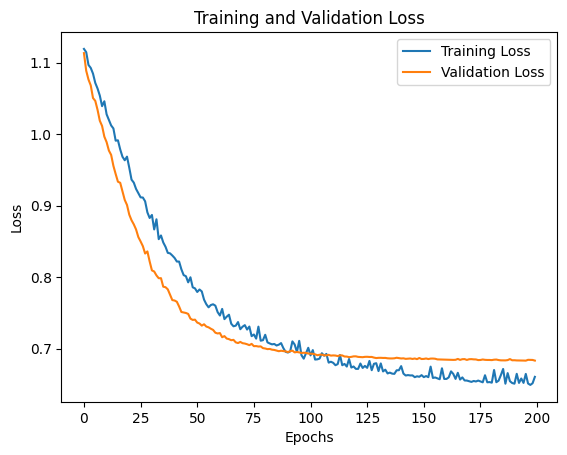

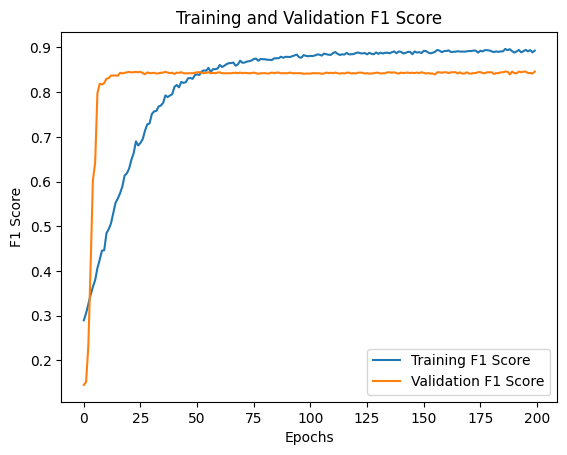

In [49]:
# Initialize MetaClassifier and move to device
CNN_1D = CNN_1d().to(device)

# HP definition
num_epochs = 200
batch_size = 256
lr = 1e-5
weight_decay = 1e-3
model_path = "CNN.pth"

# Training loop
train_metaclassifier(CNN_1D, batch_size, num_epochs, lr, weight_decay, train_dataset, val_dataset, model_path)

A bit of overfitting can be seen by means of the two plots above. The model's generalization capabilities seems to find a plateau pretty early in the training loop, but this is probably due to the simplicity of the input tensor.

In [50]:
CNN_model = CNN_1d()
CNN_model.load_state_dict(torch.load(model_path))
CNN_model = CNN_model.to(device)

evaluate_metaclassifier(CNN_model, test_dataset)


Test Loss: 0.6585306147734324
Test Macro F1 Score: 0.8765650130125332
Test Weighted F1 Score: [0.88831169 0.90064261 0.84074074]
Test Accuracy: 0.8881118881118881
